# Business Problem

A local real estate investor has contracted our company wanting us to build a model to predict housing prices in King County, Washington. They want to be able to determine if a current home sale price is below the market value in order to make a decision to buy or not.


---------------------------------------------

We are provided with data from another company that represents home sales for Kings County (where Seattle is located) to build our model.

# Beginning EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

raw_data = pd.read_csv('data\kc_house_data.csv')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

The sale data from homes in King County, WA with 21 features and 21,597 entries

In [2]:
raw_data.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

As we do our data exploration, we will make sure to deal with these null values.
____
We will quickly take a look at the numerical features of our dataset

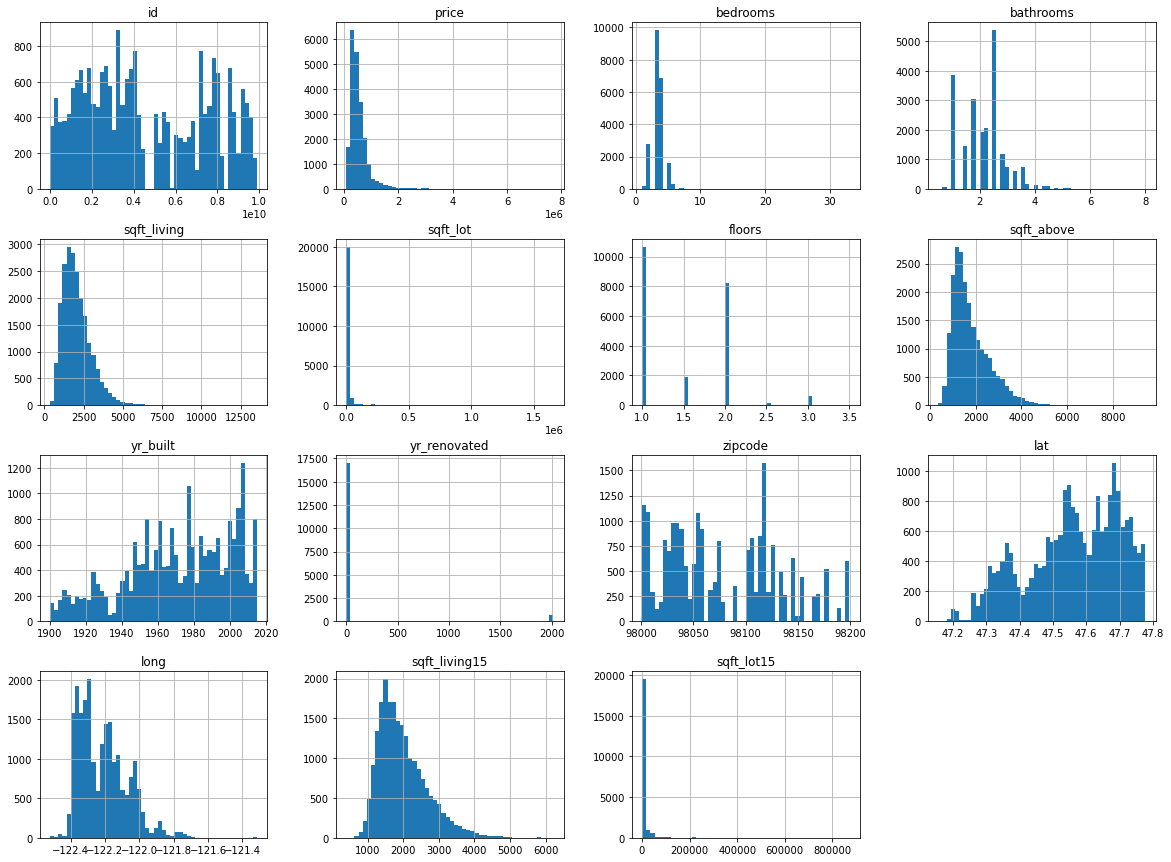

In [3]:
raw_data.hist(bins=50, figsize=(20,15))
plt.show()

Right away we can see some differences in what data we have. 'bedrooms' and 'bathrooms' look to be discrete counts of those home features, as does 'floors'. The features that begin with 'sqft' all look to be continuous, as does 'price'.  'lat' and 'long' are the location data for the home. 'yr_renovated' looks funny because they must use 0 for homes with no renovation. We will dive deeper into each feature in section 3.
______
Since we have latitude and longitude data for our homes, we can also print a quick scatterplot that will function as a map. We have included a color palate based on price to see if that gives us any clues about price density

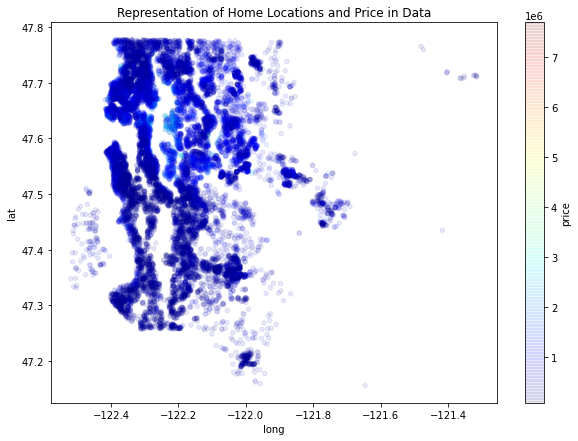

In [4]:
raw_data.plot(kind='scatter', x='long', y='lat', alpha=0.09, figsize=(10,7),
             c='price', cmap=plt.get_cmap('jet'), colorbar=True,
             sharex=False)
plt.title('Representation of Home Locations and Price in Data');

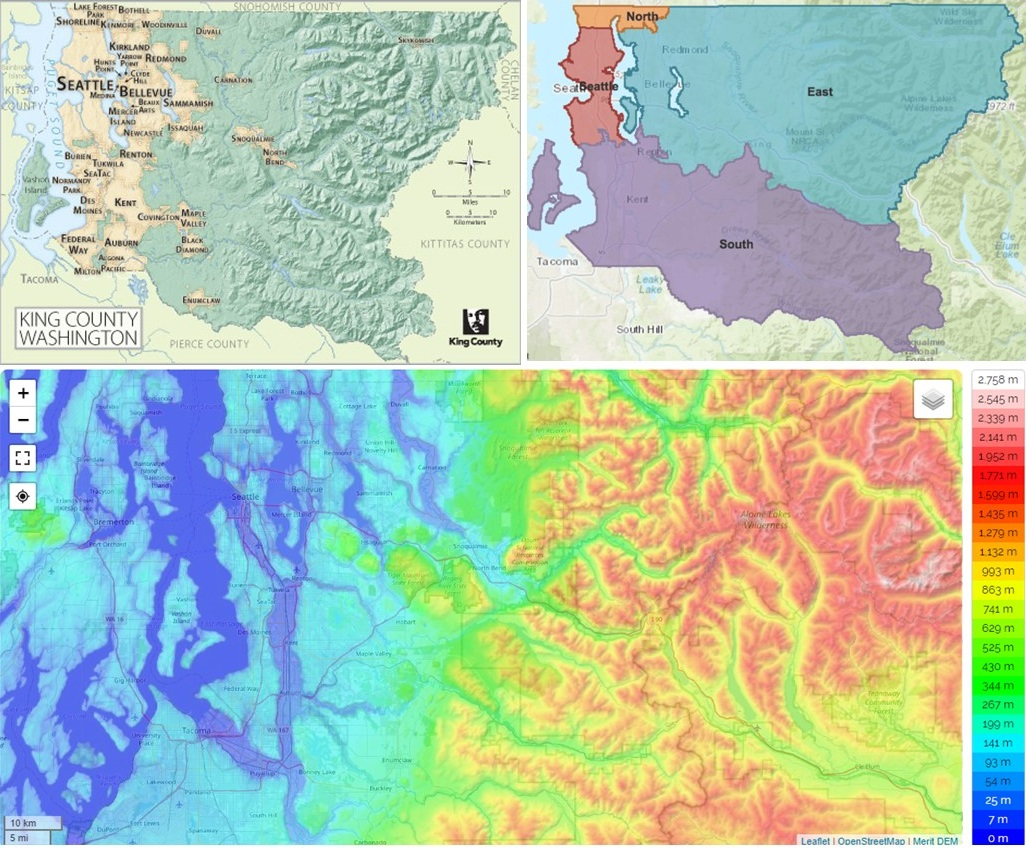

In [5]:
from IPython.display import Image
Image(filename='images\king_co_maps.jpg')

We can see that our homes in the dataset follow the topography and water features of the map of the county. You can also see the smaller towns east and southeast of Seattle, as well as Skykomish in the top right of the scatterplot, and Vashon island (the light cluster on the left edge, middle).

It looks like the more expensive homes are all in the Seattle area, which makes sense as it's a large, metropolitan area.

Research shows that King County is generally divided into four major regions:
- Seattle
- North
- South
- East

The north region is quite small compared to the other three. Looking at google maps, we can see continuing suburban sprawl north of the county line where the 'north' region is.  The geography of the eastern portions of both of the 'south' and 'east' regions does not support much development.

We may want to consider using region information as we continue modeling.
________
Our modeling target it the price of a home, so we can use a correlation matrix to identify features that correlate with 'price'

In [6]:
corr_matrix = raw_data.corr()
corr_matrix['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.701917
sqft_above       0.605368
sqft_living15    0.585241
bathrooms        0.525906
bedrooms         0.308787
lat              0.306692
floors           0.256804
yr_renovated     0.129599
sqft_lot         0.089876
sqft_lot15       0.082845
yr_built         0.053953
long             0.022036
id              -0.016772
zipcode         -0.053402
Name: price, dtype: float64

Initial correlation results do not represent all features yet, there are still categorical features to convert.

**High correlation** (corr coefficient > 0.7)
- 'sqft_living', which makes a lot of sense. While the total square footage isn't the only feature of a home, it is a strong predictor of price.

**Moderate correlation** (corr coefficient > 0.5):

- 'sqft_above' which makes sense in exactly the same way as 'sqft_living'. The documentation with the data says this is the square footage of the home minus any basement space. There is likely some multicollinearity here with 'sqft_living'

- 'sqft_living15' is the average square footage of the 15 nearest homes to the home in question. Generally neighborhoods see similar sized homes within them, so it makes sense that if the square footage of a home is correlated with the price, and surrounding homes are similar in size, then that value would also correlate.

- 'bathrooms' makes sense in relationship to price. As homes get bigger, there is a greater need for bathrooms, and those homes likely are more expensive. There may be multicollinearity here too.

**Low correlation** (corr coefficient > 0.3):

- 'bedrooms' makes sense in the same way that bathrooms does, but it's likely that bathrooms are more important to value because they represent a universal need for both home residents and guests. There are sometimes bathrooms assigned for use by guests that are not used by residents. Bedrooms on the other hand almost solely exist for use by the residents. Also curious about multicollinearity here.

- 'Lat' also makes sense, with a much higher correlation than 'long'. Most of the homes are north and south along the east side of the Puget Sound, which is the western border of the county. Very few homes to the east part of the county due to mountains and rivers.

**Negligible correlation** (corr coefficient < 0.3):

- 'floors' will need to be investigated to figure out how to use the data more effectively

- 'yr_renovated' likely will not be included as raw data, but will need to engineer additional features derived from them.

- Below that we see the 'sqft_lot' and 'sqft_lot15'. We will look more closely at this, but these features on their own don't seem that interesting. It makes sense because a large lot does not guarantee a home with a high price.

- 'yr_built' on its own it may not be interesting, but we may use it to engineer other features.

- 'id' is a unique identifier used from the data collection, it makes sense there is no correlation there.

- Also 'zipcode', even though it's numerical in value, is categorical in nature, so it also makes sense that there is no correlation.

**Features which did not represent in the matrix due to being categorical**:
- 'date'
- 'waterfront'
- 'view'
- 'condition'
- 'grade'
- 'sqft_basement' <<< suspicious, should be numerical
_____________
We will leave the raw data from import just in case we need to return to it, and make a copy to use moving forward.


In [7]:
df = raw_data.copy()

In [8]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Home data shows the **AVERAGE**:
- Sale price: \\$540,296
- Bedrooms: 3.37
- Bathrooms: 2.11
- Sqft_living: 2,080
- Sqft_lot: 15,099
- Floors: 1.49
- Sqft_above: 1,788
- Year built: 1970

# Feature investigation

As we investigate each feature, there are likely ones that we will not use in modeling at all. We will keep a **running list** of features to drop, that way the feature stays in our dataframe but gets dropped from the predictors before modeling. Important for feature engineering later.

## 'id'

Though we won't be using it in any analysis, keeping the unique identifier may come in handy later if we are dropping some data or our feature engineering gets complex and we need to merge data back together.

In [9]:
features_to_drop = ['id']

## 'date'

First we will convert the column to a datetime object, which will make it easy to engineer other features based on the relationship to sale date.

In [10]:
df.date = pd.to_datetime(df.date)

In [11]:
df.date.describe(datetime_is_numeric=True)

count                            21597
mean     2014-10-29 04:20:38.171968512
min                2014-05-02 00:00:00
25%                2014-07-22 00:00:00
50%                2014-10-16 00:00:00
75%                2015-02-17 00:00:00
max                2015-05-27 00:00:00
Name: date, dtype: object

The sale dates range from 5/2/2014 to 5/27/2015.

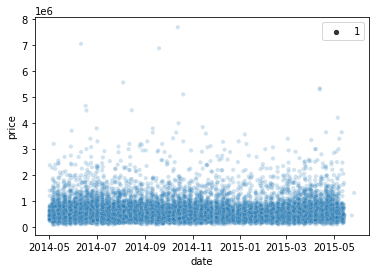

In [12]:
sns.scatterplot(data=df, x='date', y='price', size=1, alpha=0.2);

There, unsuprisingly, does not seem to be any linear relationship between sale date and price. But again, we may want to use the sale date information to engineer new features.

In [13]:
features_to_drop.extend(['date'])

## 'price' **(TARGET)**

In [14]:
df.price.describe().round()

count      21597.0
mean      540297.0
std       367368.0
min        78000.0
25%       322000.0
50%       450000.0
75%       645000.0
max      7700000.0
Name: price, dtype: float64

The average home price in our dataset is \\$540,297 but if you look at the 50th percentile it's significantly lower at \\$450,000. We also definitely have some mansions in our data, our max price is $7.7 million

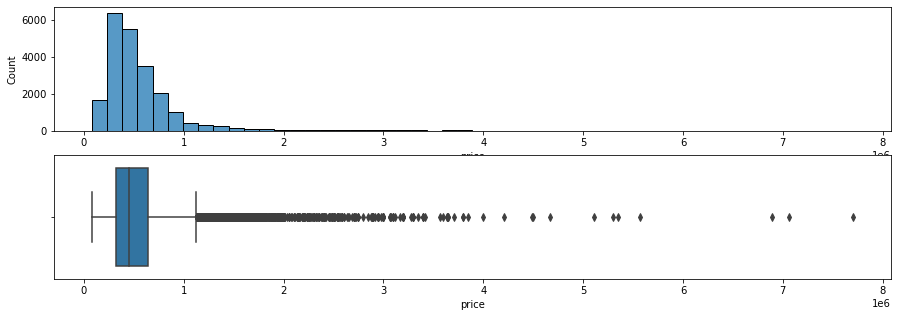

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,5))
sns.histplot(data=df, x='price', bins=50, ax=ax[0])
sns.boxplot(data=df, x='price', ax=ax[1]);

In [16]:
upper_limit_price = df.price.mean() + 3*df.price.std()
upper_limit_price

1642400.9938097603

If we define outliers as more than 3x the standard deviation away from the mean, then outliers are considered homes over $1,642,401

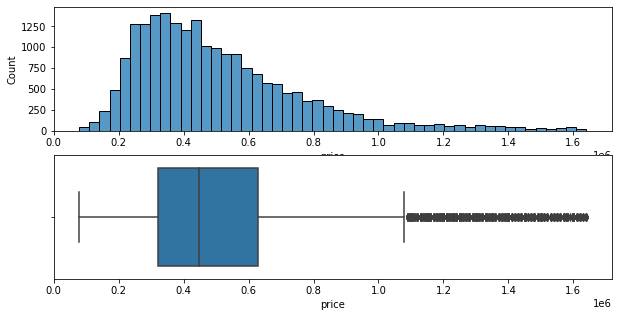

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,5))
sns.histplot(data=df[df.price<upper_limit_price], x='price', bins=50,
             ax=ax[0])
sns.boxplot(data=df[df.price<upper_limit_price], x='price', ax=ax[1]);

In [18]:
df[df.price<upper_limit_price].describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.119100e+04,2.119100e+04,21191.000000,21191.000000,21191.000000,2.119100e+04,21191.000000,21191.000000,21191.000000,17425.000000,21191.000000,21191.000000,21191.000000,21191.000000,21191.000000
mean,4.592327e+09,5.070103e+05,3.356095,2.087514,2032.486103,1.482673e+04,1.486858,1751.498938,1970.926525,79.373142,98078.289651,47.558989,-122.213732,1960.388656,12631.720589
std,2.878225e+09,2.594622e+05,0.917527,0.736021,836.738586,4.040095e+04,0.538297,772.205310,29.285262,390.038728,53.407481,0.139455,0.141433,655.151335,27193.757002
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.125400e+09,3.200000e+05,3.000000,1.500000,1410.000000,5.005500e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.467050,-122.329000,1480.000000,5080.000000
50%,3.905040e+09,4.470000e+05,3.000000,2.250000,1890.000000,7.560000e+03,1.000000,1544.000000,1975.000000,0.000000,98065.000000,47.569900,-122.231000,1820.000000,7576.000000
75%,7.334500e+09,6.276500e+05,4.000000,2.500000,2500.000000,1.049050e+04,2.000000,2170.000000,1996.000000,0.000000,98118.000000,47.678800,-122.124000,2330.000000,10000.000000
max,9.900000e+09,1.640000e+06,33.000000,7.500000,7480.000000,1.651359e+06,3.500000,7320.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,5790.000000,871200.000000


With outliers removed the features averages are still pretty similar with one difference: the price. It's dropped from \\$540k to \\$507k USD

In [19]:
price_outliers_df = df[df.price>upper_limit_price]

In [20]:
price_outliers_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,4.060000e+02,4.060000e+02,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,330.000000,406.000000,406.000000,406.000000,406.000000,406.000000
mean,3.961826e+09,2.277660e+06,4.266010,3.593596,4577.088670,29331.751232,1.871921,3724.906404,1974.817734,308.769697,98060.320197,47.617712,-122.227039,3355.770936,19364.182266
std,2.730670e+09,7.683480e+05,0.944472,0.978400,1395.281825,76438.853377,0.473599,1227.548725,33.560136,723.297575,56.069630,0.052030,0.095943,815.442995,30513.711245
min,4.610035e+07,1.650000e+06,2.000000,1.750000,2360.000000,1880.000000,1.000000,1520.000000,1900.000000,0.000000,98004.000000,47.416900,-122.416000,1490.000000,2199.000000
25%,1.652500e+09,1.792500e+06,4.000000,3.000000,3715.000000,8864.500000,2.000000,2880.000000,1950.000000,0.000000,98006.000000,47.582975,-122.284000,2870.000000,8557.250000
50%,3.528000e+09,2.000000e+06,4.000000,3.500000,4325.000000,14754.000000,2.000000,3590.000000,1988.000000,0.000000,98040.000000,47.625900,-122.223500,3290.000000,13224.500000
75%,5.663328e+09,2.497500e+06,5.000000,4.250000,5150.000000,21241.000000,2.000000,4320.000000,2004.000000,0.000000,98112.000000,47.639725,-122.202000,3847.500000,19273.250000
max,9.831200e+09,7.700000e+06,8.000000,8.000000,13540.000000,920423.000000,3.500000,9410.000000,2015.000000,2014.000000,98199.000000,47.762400,-121.756000,6210.000000,411962.000000


- There are 406 homes in our dataset that meet this definition of outlier. 
- These homes average \\$2.2 million USD
- They have on average 4 bedrooms and 3.5 baths
- They are also on average about 4,570 ft$^{2}$


Baseline modeling we will use everything, but this is one option for restricting our dataset to improve modeling. 

We may need to consider scaling and normalizing also.
_______________
'price' is the target variable for our model, so we will add this to the features to drop list.

In [21]:
features_to_drop.extend(['price'])

## 'bedrooms'


In [22]:
df.bedrooms.describe()

count    21597.000000
mean         3.373200
std          0.926299
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64

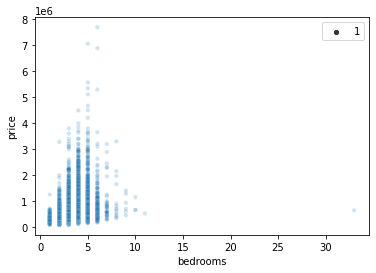

In [23]:
sns.scatterplot(data=df, x='bedrooms', y='price', alpha=0.2, size=1);

In [24]:
df[df.bedrooms == 33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,NO,NONE,...,7 Average,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700


This outlier in number of bedrooms is interesting. I doubt very much there are 33 bedrooms in a 1,600 ft$^{2}$ home. We suspect an entry error and are going change it to 3, which is much more likely.

In [25]:
df.at[15856,'bedrooms'] = 3

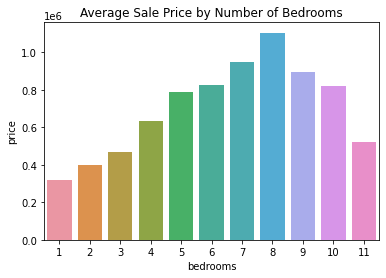

In [26]:
bedrooms_df = df.groupby('bedrooms').mean()[['price']]
bedrooms_df.reset_index(inplace=True)
sns.barplot(data=bedrooms_df, x='bedrooms', y='price')
plt.title('Average Sale Price by Number of Bedrooms');

In [27]:
df.bedrooms.value_counts()

3     9825
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
Name: bedrooms, dtype: int64

It looks like there are only 10 homes out of over 21,000 that have more than 8 bedrooms, and only 61 homes that have over 6 bedrooms.

>After baseline modeling it may be something to consider dropping all homes over 6 bedrooms to see if the model improves. The model will do a worse job at predicting larger homes like mansions, but will be better at predicting the majority of more normal homes.

## 'bathrooms'

In [28]:
df.bathrooms.describe()

count    21597.000000
mean         2.115826
std          0.768984
min          0.500000
25%          1.750000
50%          2.250000
75%          2.500000
max          8.000000
Name: bathrooms, dtype: float64

In [29]:
df.bathrooms.value_counts().sort_index()

0.50       4
0.75      71
1.00    3851
1.25       9
1.50    1445
1.75    3048
2.00    1930
2.25    2047
2.50    5377
2.75    1185
3.00     753
3.25     589
3.50     731
3.75     155
4.00     136
4.25      79
4.50     100
4.75      23
5.00      21
5.25      13
5.50      10
5.75       4
6.00       6
6.25       2
6.50       2
6.75       2
7.50       1
7.75       1
8.00       2
Name: bathrooms, dtype: int64

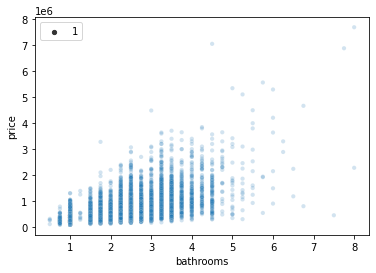

In [30]:
sns.scatterplot(data=df, x='bathrooms', y='price', alpha=0.2, size=1);

The range of values was unexpected. 

After some research, learned that a bathroom is considered 'full' with 4 parts, each worth a quarter:
- sink
- toilet
- shower
- bathtub


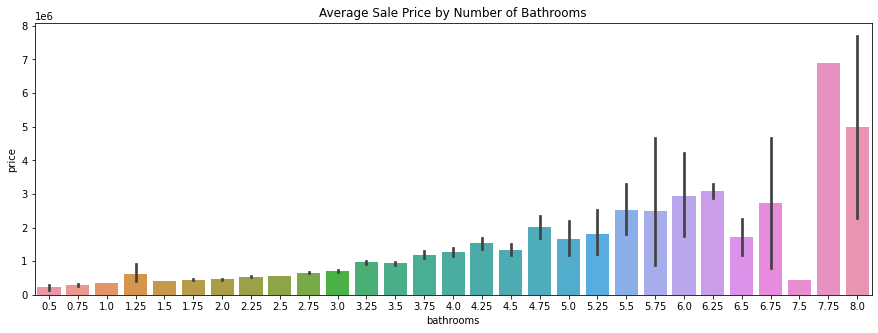

In [31]:
fig = plt.subplots(figsize=(15,5))
sns.barplot(data=df, x='bathrooms', y='price')
plt.title('Average Sale Price by Number of Bathrooms');

Things fall apart in the relationship between bathroom count and price average. If you look at the value counts above you see that each count of bathrooms equal to or greater than 5.5 is represented by 10 or less homes.

In fact, homes with more than 4 bathrooms account for only 266 entries in our dataframe, about 1.2%.

In [32]:
bathrooms_df = df[['price', 'bathrooms']].copy()

Because the 'bathrooms' feature is the total bathrooms in the home, and each bathroom is represented as a quarter-step percentage, it's difficult to know the actual makeup of the bathrooms in the home.
> 2.5 bathrooms is our most frequent value. The makeup of that number could be:
> - 10 quarter baths
> - 8 quarters and a half bath
> - 7 quarters and a 3/4 bath
> - 6 quarters and 2 half baths
> - 6 quarters and a full bath
> - 5 quarters, a 3/4 bath and a half bath
> - 4 quarters and two 3/4 bath
> - 4 quarters, a half, and a full
> - 3 quarters, a 3/4 bath and a full
> - 2 quarters and 4 half baths
> - 2 quarters, 2 half baths, and a whole
> - 2 quarters, two 3/4
> - 1 quarter and 3 3/4 baths
> - 2 half bath and two 3/4 bath
> - 2 half bath and two full bath


If we round each bathroom count up to the next whole number, we may be able to have a better approximation of the number of bathrooms in the home, regardless of what constitutes each bathroom.

The average value for bathrooms from the entire dataset is 2.11, which if we rounded up would be 3 baths.

Also this is a feature that may be able to be related to 'sqft_living' to engineer new features that may be more interesting. We could also use the count of bathrooms and bedrooms to get an average room size for the home, which may also be interesting.

In [33]:
import math

bathrooms_df['bathrooms'] = bathrooms_df.bathrooms.map(lambda x: math.ceil(x))

In [34]:
bathrooms_df.bathrooms.value_counts().sort_index()

1    3926
2    6432
3    9362
4    1611
5     223
6      33
7       6
8       4
Name: bathrooms, dtype: int64

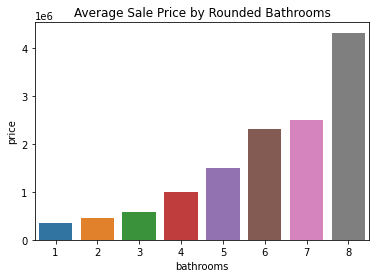

In [35]:
bathrooms_df = bathrooms_df.groupby('bathrooms').mean()[['price']]
bathrooms_df.reset_index(inplace=True)
sns.barplot(data=bathrooms_df, x='bathrooms', y='price')
plt.title('Average Sale Price by Rounded Bathrooms');

We've only got 43 homes that represent bathroom counts of 6, 7, and 8. This is what drive the average up so high for those values, you can see this when you look at the scatter plot above as well.

After baseline modeling we may consider rounding and/or dropping some homes based on number of bathrooms.

## 'sqft_living'

In [36]:
df.sqft_living.describe()

count    21597.000000
mean      2080.321850
std        918.106125
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

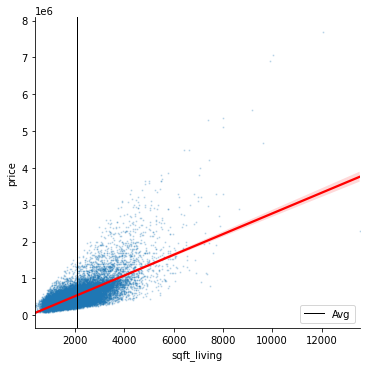

In [37]:
sns.lmplot(data=df, x='sqft_living', y='price', line_kws={'color':'red'},
           scatter_kws={'s':1,'alpha':0.2})
plt.axvline(x=df.sqft_living.mean(), color='black', lw=1, label='Avg')
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.legend();

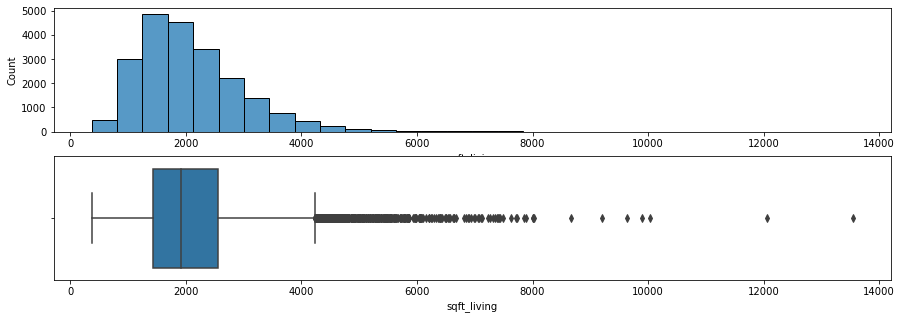

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,5))
sns.histplot(data=df, x='sqft_living', bins=30, ax=ax[0])
sns.boxplot(data=df, x='sqft_living', ax=ax[1]);

In [39]:
upper_limit_sqft_living = df.sqft_living.mean() + 3*df.sqft_living.std()
upper_limit_sqft_living

4834.640225497227

The price data is skewed, looks like we have lots of large homes in our dataset

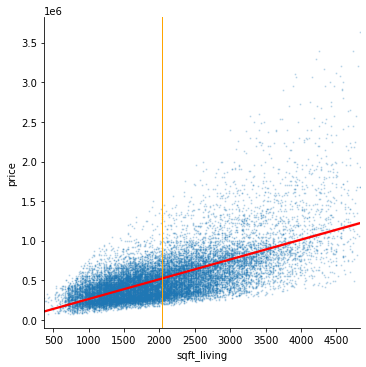

In [40]:
sns.lmplot(data=df[df.sqft_living<upper_limit_sqft_living], x='sqft_living',
           y='price', line_kws={'color':'red'},
           scatter_kws={'s':1,'alpha':0.2})
plt.axvline(x=df[df.sqft_living<upper_limit_sqft_living].sqft_living.mean(),
            color='orange', lw=1)
plt.ticklabel_format(style='plain', axis='x',useOffset=False);

Even removing outliers it's clear that it gets more difficult to predict price as the square footage gets large. There are certainly other factors responsible.

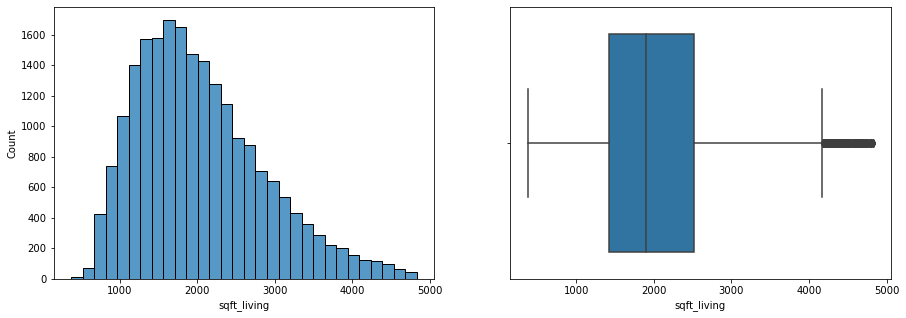

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.histplot(data=df[df.sqft_living<upper_limit_sqft_living], x='sqft_living',
             bins=30, ax=ax[0])
sns.boxplot(data=df[df.sqft_living<upper_limit_sqft_living], x='sqft_living',
            ax=ax[1]);

In [42]:
df[df.sqft_living<upper_limit_sqft_living].describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.134900e+04,2.134900e+04,21349.000000,21349.000000,21349.000000,2.134900e+04,21349.000000,21349.000000,21349.000000,17551.000000,21349.000000,21349.000000,21349.000000,21349.000000,21349.000000
mean,4.583236e+09,5.235488e+05,3.357253,2.092264,2036.837182,1.464966e+04,1.488688,1755.366715,1970.796056,83.469033,98078.256171,47.559795,-122.214729,1966.775634,12431.305354
std,2.876796e+09,3.122114e+05,0.893689,0.733955,820.674600,3.999190e+04,0.538586,762.723544,29.343347,399.556272,53.507426,0.138961,0.140686,656.618177,25510.449235
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123700e+09,3.200000e+05,3.000000,1.500000,1420.000000,5.021000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.469500,-122.329000,1480.000000,5098.000000
50%,3.904940e+09,4.499500e+05,3.000000,2.250000,1900.000000,7.561000e+03,1.500000,1550.000000,1974.000000,0.000000,98065.000000,47.571600,-122.232000,1830.000000,7592.000000
75%,7.312400e+09,6.350000e+05,4.000000,2.500000,2520.000000,1.050000e+04,2.000000,2180.000000,1996.000000,0.000000,98118.000000,47.678400,-122.126000,2340.000000,10000.000000
max,9.900000e+09,3.640000e+06,11.000000,7.500000,4830.000000,1.651359e+06,3.500000,4830.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,5790.000000,560617.000000


In [43]:
sqft_living_outliers_df = df[df.sqft_living>upper_limit_sqft_living]
sqft_living_outliers_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.480000e+02,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,204.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,4.342769e+09,1.982025e+06,4.625000,4.144153,5823.685484,53815.677419,1.959677,4649.201613,1988.528226,98.068627,98051.754032,47.585771,-122.149730,3694.943548,40906.092742
std,2.867339e+09,1.124242e+06,0.917939,0.982455,1120.504588,100972.182168,0.417709,1147.377001,26.760885,433.012480,47.226733,0.093724,0.128806,908.584661,89385.480918
min,4.610035e+07,4.520000e+05,2.000000,1.750000,4850.000000,4600.000000,1.000000,2560.000000,1904.000000,0.000000,98001.000000,47.263000,-122.412000,1280.000000,4080.000000
25%,1.925817e+09,1.240000e+06,4.000000,3.500000,5127.500000,12961.250000,2.000000,3805.000000,1984.000000,0.000000,98006.000000,47.546375,-122.233000,3037.500000,11063.000000
50%,3.757801e+09,1.680000e+06,4.500000,4.000000,5480.000000,20292.500000,2.000000,4495.000000,1999.000000,0.000000,98040.000000,47.592650,-122.151000,3700.000000,15755.500000
75%,7.237500e+09,2.472500e+06,5.000000,4.500000,6070.000000,41958.000000,2.000000,5240.000000,2005.000000,0.000000,98074.000000,47.641325,-122.075250,4300.000000,33655.000000
max,9.831200e+09,7.700000e+06,8.000000,8.000000,13540.000000,871200.000000,3.500000,9410.000000,2015.000000,2009.000000,98199.000000,47.766600,-121.764000,6210.000000,871200.000000


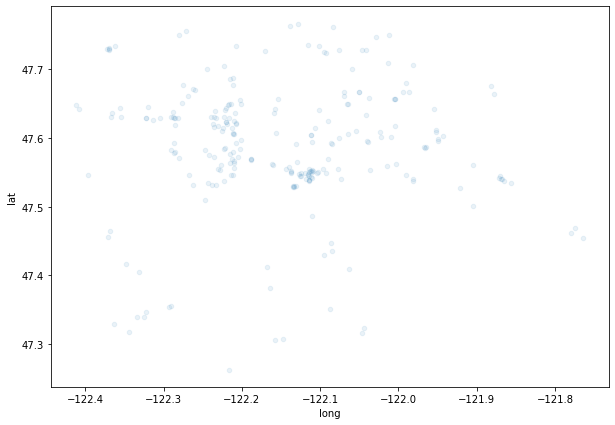

In [44]:
sqft_living_outliers_df.plot(kind='scatter', x='long', y='lat', alpha=0.09,
                          figsize=(10,7));

Plotting the outliers based on square footage shows that they are kind of all over the county. There does seem to be a concentration around Bellevue, and there are more in Seattle but not concentrated in any one neighborhood it seems.
_______
- 57% of homes are have below the average of 2,080 ft$^{2}$.

- 96% of homes are below 4,000 ft$^{2}$.

- Standard calculation shows outliers as any home greater than 4,834 ft$^{2}$

- Outliers constitute 248 homes out of the dataset, have an average sqft_living of 5,823 ft$^{2}$, tend to be newer with a basement, almost 5 bedrooms, 4 bathrooms and sold for an average of just under \\$2 million USD


The vast majority of our sqft_living data is grouped under 4,000 ft$^{2}$. There are some large homes out there, but our mean and median are pretty close (2,080 vs 1,910). The data looks normal except for the right skewedness.


Again, suspect that we have a subset of extremely large homes. This looks like a feature to use to restrict our dataset a bit to maybe improve the model? Maybe viewing large homes represented on a map vs all other sized homes will show neighborhoods that are more likely to hold large homes?

## 'sqft_lot'

In [45]:
df.sqft_lot.describe().round()

count      21597.0
mean       15099.0
std        41413.0
min          520.0
25%         5040.0
50%         7618.0
75%        10685.0
max      1651359.0
Name: sqft_lot, dtype: float64

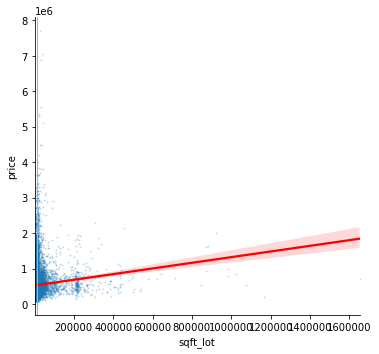

In [46]:
sns.lmplot(data=df, x='sqft_lot', y='price', line_kws={'color':'red'},
           scatter_kws={'s':1,'alpha':0.2})
plt.axvline(x=df.sqft_lot.mean(), color='orange', lw=1)
plt.ticklabel_format(style='plain', axis='x',useOffset=False);

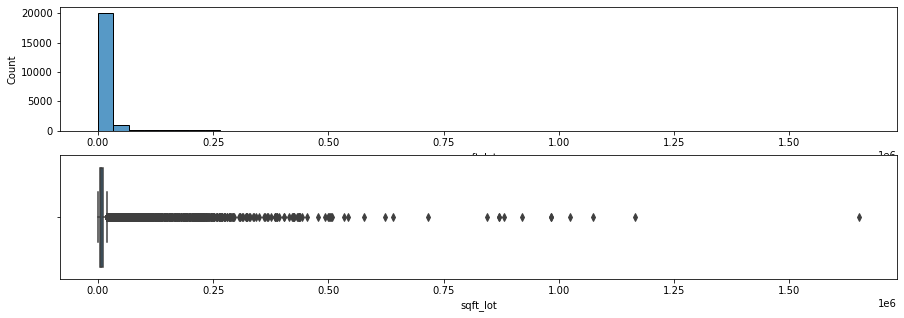

In [47]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,5))
sns.histplot(data=df, x='sqft_lot', bins=50, ax=ax[0])
sns.boxplot(data=df, x='sqft_lot', ax=ax[1]);

Even more so that 'sqft_living', the square footage of the lot has a relatively small number of huge outliers.

Three quarters of our data on 'sqft_lot' is under 10,685 ft$^{2}$, but the average lot is about 15,099 ft$^{2}$. The lot sizes are heavily positive skewed. 

In [48]:
# sqft is easy to estimate for inside home size, but more difficult to get a
# sense for. If we later want to conver to acres, divide sqft by 43560

In [49]:
upper_limit_sqft_lot = df.sqft_lot.mean() + 3*df.sqft_lot.std()
print(f'Upper limit for outlier cutoff is:\n-{round(upper_limit_sqft_lot, 2)}\
 ft2, or\n-{round(upper_limit_sqft_lot/43560, 2)} acres')

Upper limit for outlier cutoff is:
-139337.32 ft2, or
-3.2 acres


In [50]:
sqft_lot_outliers_df = df[df.sqft_lot>upper_limit_sqft_lot]
sqft_lot_outliers_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,3.460000e+02,3.460000e+02,346.000000,346.000000,346.000000,3.460000e+02,346.000000,346.000000,346.000000,299.000000,346.000000,346.000000,346.000000,346.000000,346.000000
mean,2.173847e+09,6.782525e+05,3.419075,2.507948,2890.358382,2.718045e+05,1.586705,2621.731214,1983.549133,86.618729,98043.052023,47.484841,-122.026402,2404.757225,150465.182081
std,1.706962e+09,3.581175e+05,0.904472,0.944152,1405.499739,1.689485e+05,0.494605,1230.521659,22.126492,406.965504,24.875287,0.167551,0.161932,702.414778,107019.943138
min,1.200590e+08,1.500000e+05,1.000000,1.000000,710.000000,1.393920e+05,1.000000,710.000000,1900.000000,0.000000,98001.000000,47.159300,-122.519000,1060.000000,3572.000000
25%,1.020569e+09,4.406250e+05,3.000000,1.750000,1982.500000,1.994248e+05,1.000000,1764.500000,1976.000000,0.000000,98022.000000,47.362400,-122.084750,1915.000000,61854.750000
50%,1.921569e+09,5.850000e+05,3.000000,2.500000,2665.000000,2.178025e+05,2.000000,2450.000000,1990.000000,0.000000,98038.000000,47.456300,-122.010500,2300.000000,150681.500000
75%,2.925822e+09,7.900000e+05,4.000000,3.000000,3460.000000,2.700132e+05,2.000000,3230.000000,2000.000000,0.000000,98063.500000,47.647175,-121.940250,2760.000000,217796.750000
max,9.206700e+09,2.280000e+06,7.000000,8.000000,13540.000000,1.651359e+06,3.000000,9410.000000,2014.000000,2008.000000,98092.000000,47.775400,-121.691000,5610.000000,871200.000000


346 homes would meet the condition of being an outlier in the sqft_lot feature. The average price is higher than that of the full dataset for these outliers
_______________
Lets look at the scatterplot from above with outliers removed.

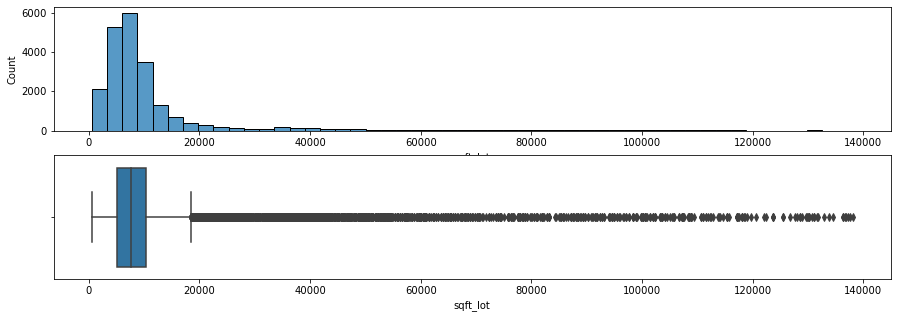

In [51]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,5))
sns.histplot(data=df[df.sqft_lot<upper_limit_sqft_lot], x='sqft_lot', bins=50,
             ax=ax[0])
sns.boxplot(data=df[df.sqft_lot<upper_limit_sqft_lot], x='sqft_lot',
            ax=ax[1]);

Still lots of homes considered outliers after removing the 'first round' of ouliers from the raw dataset. The 'sqft_lot' skewness is really bad.
______
Lets scatterplot the outliers and see where they are geographically

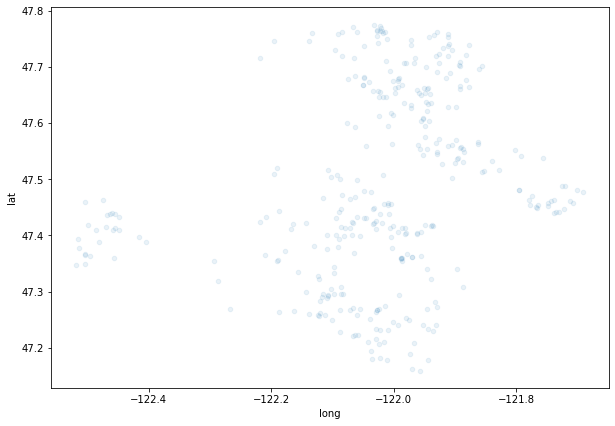

In [52]:
sqft_lot_outliers_df.plot(kind='scatter', x='long', y='lat', alpha=0.09,
                          figsize=(10,7));

You can see Vashon Island represented on the left of the figure, but then most of the larger lots are east and south/east of Seattle.

This figure does not represent the eastern-most section of the county. It appears that Skykomish does not have any homes on lots considered outliers. This makes sense, that part of the county is very mountainous and larger lots are less likely.
_______________

In [53]:
len(df[df.sqft_lot < 15099])/len(df)

0.8519238783164328

The large lot sizes are enormously large in comparison, and that may be fouling up our model later. This is another feature we may need to scale/normalize later on.

85% of homes have a lot less than the average of 15,099 ft$^{2}$. 

Lot size is not a guarantee of high home value. In fact in our first scatter plot, it looks like smaller lot sizes are **more** valuable than larger. Lots do not grow in size proportionately to the home, and larger lots tend to be further from commercial amenities.

> For now we are leaving everything in the baseline model, but this is a feature that may be re-engineered and dropped, as it doesn't share much of a linear relationship with price.

## 'floors'

In [54]:
df.floors.describe()

count    21597.000000
mean         1.494096
std          0.539683
min          1.000000
25%          1.000000
50%          1.500000
75%          2.000000
max          3.500000
Name: floors, dtype: float64

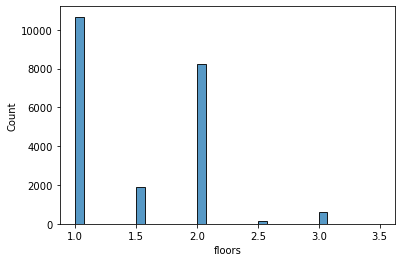

In [55]:
sns.histplot(data=df, x='floors');

In [56]:
df.floors.value_counts()

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

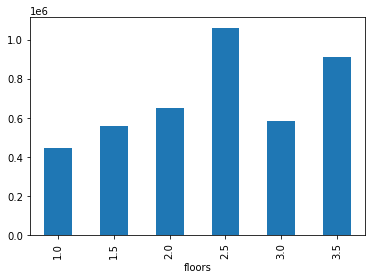

In [57]:
df.groupby('floors').mean()['price'].plot(kind='bar');

It initially looks like the average price increases with each half-floor increase until 2.5 floors, then goes down for 3 floors and back up for 3.5. Looking at the data shows we have a \\$3.3 million mansion with 3.5 floors that affects our average.
________
A half-storey house is a detached home that has an addition floor that is about half the size of the main floor(s), but is off to one side.

Most of our data is 1 or 2 floor homes, but we have some 1.5, 2.5, 3 and 3.5 in there too.

The relationship between average price and number of floors increases until 2.5 floors, decreases


>During initial EDA we saw that there was not much correlation between price and floors. One idea is to change this into a boolean for more than 1 floor, with 1 being if it's 1.5 and above and 0 being 1 floor. For baseline modeling we will leave it in.

>It could also be the case that by looking at the square footage divided by the floors we can get an idea of the footprint of the home, which may show that many of our multi-floor homes are actually townhomes.

## 'waterfront'

In importing we checked for null values, and there were some in the 'waterfront' feature.

In [58]:
df.waterfront.value_counts(normalize=True)

NO     0.992404
YES    0.007596
Name: waterfront, dtype: float64

There are only two options, waterfront or not. Less than 1% of homes are waterfront, so we assume that no value means no waterfront view, and set the value to 'NO'.

In [59]:
df['waterfront'].fillna('NO', inplace=True)

This is a simple categorical, if the home is considered waterfront or not. 

We will convert this to a numerical feature, YES being 1 and NO being 0.

In [60]:
# converted 'waterfront' feature (numeric boolean)
df['waterfront'] = df.waterfront.map({'NO': 0, 'YES': 1})

In [61]:
df.groupby('waterfront').mean()['price']

waterfront
0    5.322862e+05
1    1.717215e+06
Name: price, dtype: float64

Waterfront properties have, on average, 3x the value of properties that are not waterfront. This seems like a good predictor given the amount of waterfront property in the county.

## 'view'

In checking for null values, we also have some in the 'view' feature.

In [62]:
df.view.value_counts(normalize=True)

NONE         0.901923
AVERAGE      0.044441
GOOD         0.023591
FAIR         0.015325
EXCELLENT    0.014721
Name: view, dtype: float64

The values are categorical, and over 90% of homes have a view value of 'NONE'. The 63 missing values will be set to 'NONE'.

In [63]:
df['view'].fillna('NONE', inplace=True)

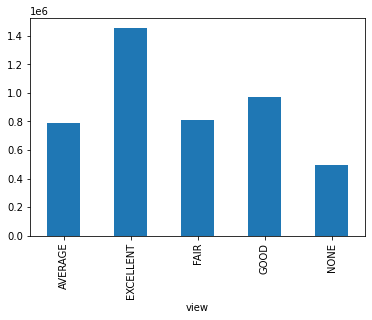

In [64]:
df.groupby('view').mean()['price'].plot(kind='bar');

The documentation describes this as the quality of view from a house. It will need to be converted to model.

Comparing the categories shows an increase in average price for a home as the quality of the view increases. However, 'fair' seems to be a bit higher on average than 'average' view.

One option is onehotencoding this feature, but 90% of this feature is 'NONE' (for no view), so we will convert this to a numerical boolean feature of 1 for having a view and 0 for not having a view.

In [65]:
# converted 'view' feature (numeric boolean)
df['has_view'] = df.view.map(lambda x: 0 if x == 'NONE' else 1)

In [66]:
df.groupby('has_view').mean()['price']

has_view
0    497210.714396
1    937800.344697
Name: price, dtype: float64

Properties that have any view, on average, almost double the value of properties that have no view. This seems like a better predictor for price.

In [67]:
features_to_drop.extend(['view'])

## 'condition'

Documentation with the dataset explains this feature is the overall condition of the home relative to ongoing maintenance.

In [68]:
df.condition.value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

Referencing the documentation, the condition can be graded numerically:

{'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1}

We will need to convert this column before modeling.

In [69]:
# converted 'condition' feature
condition_dict = {'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2,
                  'Poor': 1}
df['condition'] = df.condition.map(condition_dict)

In [70]:
df.condition.describe()

count    21597.000000
mean         3.409825
std          0.650546
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: condition, dtype: float64

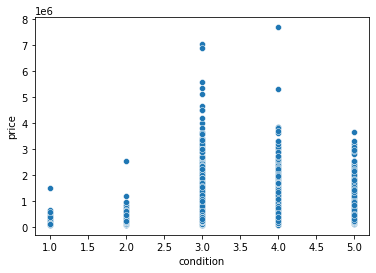

In [71]:
sns.scatterplot(data=df, x='condition', y='price');

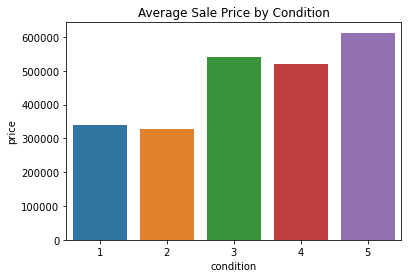

In [72]:
condition_df = df.groupby('condition').mean()[['price']]
condition_df.reset_index(inplace=True)
sns.barplot(data=condition_df, x='condition', y='price')
plt.title('Average Sale Price by Condition');

>Still trying to decide how to deal with this feature after baseline model. Staircase coding? One hot encoding? It seems there is no difference in average price for homes in condition 1 or 2, and little difference between 3 and 4. The difference between the average of 1 and 2 compared to the average of condition 5 is very large though. One other idea is to make the feature 'excellent_condition' and have a boolean 1 if it is or 0 if not, then drop the original condition feature.

## 'grade'

In [73]:
df.grade.value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

We will need to convert the column before encoding, we can just slice the string and take the first section, convert to numerical.

In [74]:
df['grade'] = df.grade.map(lambda x: x.split()[0]).astype('int')

In [75]:
list(zip(list(df[df.grade==3].columns),list(df[df.grade == 3].values[0])))

[('id', 2420069251),
 ('date', Timestamp('2015-02-25 00:00:00')),
 ('price', 262000.0),
 ('bedrooms', 1),
 ('bathrooms', 0.75),
 ('sqft_living', 520),
 ('sqft_lot', 12981),
 ('floors', 1.0),
 ('waterfront', 0),
 ('view', 'NONE'),
 ('condition', 5),
 ('grade', 3),
 ('sqft_above', 520),
 ('sqft_basement', '0.0'),
 ('yr_built', 1920),
 ('yr_renovated', 0.0),
 ('zipcode', 98022),
 ('lat', 47.2082),
 ('long', -121.995),
 ('sqft_living15', 1340),
 ('sqft_lot15', 12233),
 ('has_view', 0)]

Looking at our lonely grade 3 entry shows a well taken care of 1 bedroom very small home built in 1920, so it makes sense that the quality of construction/design is not great. This is a pre-Great Depression home, and a little research shows that the town it's in (Enumclaw) was not incorporated until 1913, so this home is quite old for the town.

In [76]:
df[df.yr_built == 1920]['grade'].value_counts()

7    54
6    26
8    10
5     6
3     1
4     1
Name: grade, dtype: int64

In [77]:
df.groupby('grade').mean()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,has_view
grade,,,,,,,,,,,,,,,,,,
3,2.420069e+09,2.620000e+05,1.000000,0.750000,520.000000,12981.000000,1.000000,0.000000,5.000000,520.000000,1920.000000,0.000000,98022.000000,47.208200,-121.995000,1340.000000,12233.000000,0.000000
4,4.344409e+09,2.120019e+05,1.592593,0.907407,680.740741,15614.777778,1.037037,0.000000,3.148148,673.333333,1936.259259,110.000000,98068.629630,47.496170,-122.165148,1486.666667,12896.629630,0.111111
5,3.887594e+09,2.485240e+05,2.388430,1.113636,983.326446,24019.909091,1.086777,0.016529,3.491736,944.607438,1935.454545,42.057895,98082.694215,47.499478,-122.199331,1380.570248,16122.433884,0.053719
6,4.442552e+09,3.019166e+05,2.685967,1.243499,1191.561335,12646.953876,1.108685,0.004907,3.539745,1068.647694,1942.471050,86.265318,98102.624632,47.533117,-122.262484,1389.247301,11020.924926,0.040726
7,4.527336e+09,4.025946e+05,3.254736,1.829953,1689.514932,11769.877089,1.296802,0.002340,3.491420,1408.425006,1963.615110,74.706601,98082.412525,47.553433,-122.232881,1679.280254,10615.995988,0.047248
8,4.775134e+09,5.429868e+05,3.481616,2.348928,2184.803627,13514.009068,1.667848,0.005276,3.355647,1867.309810,1980.393899,88.236510,98073.445837,47.565931,-122.208003,2067.075845,11371.257049,0.107832
9,4.651166e+09,7.737382e+05,3.773231,2.664340,2868.139962,20638.515488,1.849140,0.008413,3.266157,2554.395411,1988.419120,102.088235,98065.300574,47.575822,-122.165836,2613.460038,17401.707839,0.172849
10,4.404626e+09,1.072347e+06,3.907407,3.006393,3520.299824,28191.063492,1.892857,0.024691,3.232804,3112.086420,1989.569665,87.966774,98061.300705,47.590851,-122.151960,3036.892416,21334.663139,0.241623
11,4.164541e+09,1.497792e+06,4.160401,3.501880,4395.448622,38372.789474,1.961153,0.047619,3.195489,3853.182957,1992.145363,79.598160,98055.255639,47.599853,-122.150554,3532.110276,27743.160401,0.388471


In [78]:
df.grade.describe()

count    21597.000000
mean         7.657915
std          1.173200
min          3.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         13.000000
Name: grade, dtype: float64

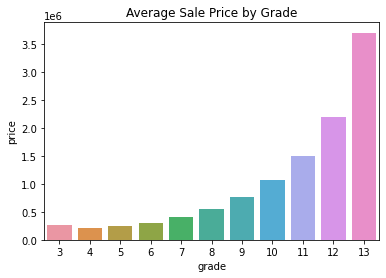

In [79]:
grade_df = df.groupby('grade').mean()[['price']]
grade_df.reset_index(inplace=True)
sns.barplot(data=grade_df, x='grade', y='price')
plt.title('Average Sale Price by Grade');

This feature, per the documentation, is the overall grade of the home relative to construction/design. This is a separate feature than condition, but we will have to see if there is any multicollinearity here. It could certainly be the case that a high graded home (good quality construction or design) could be left to disrepair and have a poor condition value.

>We will leave this as a ordinal feature for now, but it looks like we don't have any serious differences in average price until the middle grades 7 and 8. 

In [80]:
# # import OneHotEncoder
# from sklearn.preprocessing import OneHotEncoder

# # create temporary dataframe df_test with condition and grade features in it
# # df_test = df[['condition', 'grade']].copy()

# # create temporary dataframe df_test with grade feature in it
# df_test = df[['grade']].copy()

# # create a onehotencoder, fit to df_test
# ohe = OneHotEncoder().fit(df_test)

# # create the array
# onehotarray = ohe.transform(df_test).toarray()

# # generate column_names to match values, 'feature_{value}'
# column_names = []
# # for x in range(1,6):
# #     column_names.append(f'condition_{x}')
# for x in range(1,11):
#     column_names.append(f'grade_{x}')
    
# # create dataframe of array with correct column names
# ohe_df = pd.DataFrame(onehotarray, columns=column_names)

# # remove the column representing feature average from the dataframe
# ohe_df.drop(['condition_3', 'grade_4'], axis=1, inplace=True)

# # concat the main dataframe df with the onehotencoded df we just made
# df = pd.concat([df, ohe_df], axis=1)

# # add the original two features to the list of features to drop
# features_to_drop.extend(['condition', 'grade'])

# # df.drop(['condition', 'grade'], axis=1, inplace=True)

## 'sqft_above'

This is the square footage of the home apart from the basement. There is likely some multicollinearity with other features like 'sqft_living', and 'sqft_basement'.

In [81]:
df.sqft_above.describe()

count    21597.000000
mean      1788.596842
std        827.759761
min        370.000000
25%       1190.000000
50%       1560.000000
75%       2210.000000
max       9410.000000
Name: sqft_above, dtype: float64

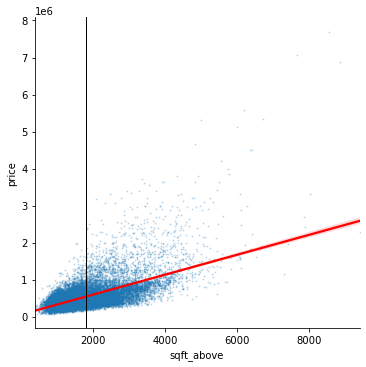

In [82]:
sns.lmplot(data=df, x='sqft_above', y='price', line_kws={'color':'red'},
           scatter_kws={'s':1,'alpha':0.2})
plt.axvline(x=df.sqft_above.mean(), color='black', lw=1, label='Avg')
plt.ticklabel_format(style='plain', axis='x',useOffset=False);

In [83]:
len(df[df.sqft_living == df.sqft_above]) / len(df)

0.6070287539936102

If we consider below that 60% of homes have no basement, then the relationship between 'sqft_living' and 'sqft_above' is likely very strong and probably experience high multicollinearity.

>We will likely drop this raw feature from modeling to reduce multicollinearity, but will likely use it to engineer different features.


## 'sqft_basement'

In [84]:
df.sqft_basement.value_counts(normalize=True)

0.0       0.593879
?         0.021021
600.0     0.010048
500.0     0.009677
700.0     0.009631
            ...   
2240.0    0.000046
1770.0    0.000046
2196.0    0.000046
1135.0    0.000046
3000.0    0.000046
Name: sqft_basement, Length: 304, dtype: float64

First, we need to address that not all of the values are numerical. 59% of the homes have 0.0 for basement square footage, meaning there is no basement. 2% of homes have a '?' value. We are going to assume that these question marks are also 0.0 values, that way we can have a numerical column.

In [85]:
df.sqft_basement.replace(to_replace='?', value=0.0, inplace=True)
df['sqft_basement'] = df.sqft_basement.astype('float')

In [86]:
df_hasbasement = df[df.sqft_basement > 0]
df_hasbasement.describe()['sqft_basement']

count    8317.000000
mean      741.928700
std       404.765113
min        10.000000
25%       450.000000
50%       700.000000
75%       980.000000
max      4820.000000
Name: sqft_basement, dtype: float64

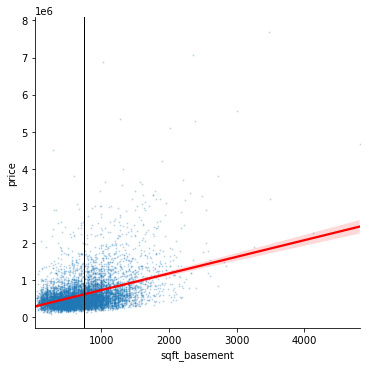

In [87]:
sns.lmplot(data=df_hasbasement, x='sqft_basement', y='price',
           line_kws={'color':'red'},
           scatter_kws={'s':1,'alpha':0.2})
plt.axvline(x=df_hasbasement.sqft_basement.mean(), color='black', lw=1,
            label='Avg')
plt.ticklabel_format(style='plain', axis='x',useOffset=False);

It's unclear if there will be multicollinearity with this feature or not. 40% of homes have basements, and those basements range from 10 to 4,800 ft$^{2}$.

It seems more likely that to include this feature we may need to engineer it as a numeric boolean for if the property has a basement or not, or perhaps bin the values in some way.

## 'yr_built'

In [88]:
df.yr_built.describe()

count    21597.000000
mean      1970.999676
std         29.375234
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64

Homes in our data were built between 1900 and 2015. Considering another feature is renovations and that is part of our business problem, it will be important to see the relationship between the build year, remodel year and sale year.

We don't need to do anything to this column

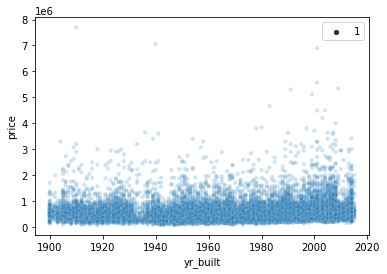

In [89]:
sns.scatterplot(data=df, x='yr_built', y='price', size=1, alpha=0.2);

On its own the feature is not particularly interesting. There is a slight increase in price as the age of the home decreases.

It's likely the case we will use this feature to engineer other, more interesting features.

## 'yr_renovated'

There are some null values in this feature we saw at import that we will need to decide what to do with.

In [90]:
df.yr_renovated.value_counts(normalize=True)

0.0       0.958096
2014.0    0.004112
2003.0    0.001746
2013.0    0.001746
2007.0    0.001690
            ...   
1948.0    0.000056
1951.0    0.000056
1971.0    0.000056
1934.0    0.000056
1944.0    0.000056
Name: yr_renovated, Length: 70, dtype: float64

Over 95% of homes in our dataset have a value of 0.0, meaning the home has never been renovated. We assume that the null values are homes not renovated and set the value to 0.0

In [91]:
df['yr_renovated'].fillna(0.0, inplace=True)

It would be interesting to see the relationship between year built and year renovated, so we leave feature in for now.

It may be the case that we separate out the feature into one that is a numerical boolean (which makes sense, because 96% of homes have not been renovated).

It may also be the case that we not consider a home renovated if the renovation took place years before the home sale. It looks like there are some homes which were renovated in the 1930s and 1940s, they should not be considered renovated now.

Some early research shows that to be considered 'renovations' it should have occurred within 15 years, so we may use that information to make more features about renovation status.

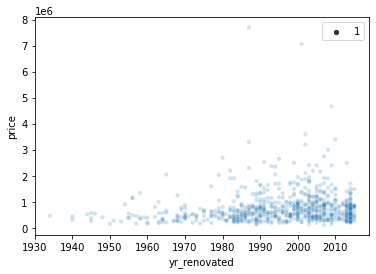

In [92]:
sns.scatterplot(data=df[df.yr_renovated > 0], x='yr_renovated', y='price',
                size=1, alpha=0.2);

We can see the density homes being renovated increases as our relative distance from sale decreases. As mentioned above, it's not honest to count a home as renovated if the renovations occur more than 15 years before the sale.

For baseline we will just leave it be, but likely need to engineer a feature to better represent if a home is renovated or not.

## 'zipcode'

In [93]:
df.zipcode.value_counts()

98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

There are 70 different zip codes in the county. Even the smallest zipcodes have 50 homes sold in the year our data was collected. 

If we are going to use zipcode data, we will need to convert it in some way. It may be worthwhile to look at converting zip codes into cities and look at the data collectively that way, the same with the 4 regions we learned about during research. For now, we will just add 'zipcode' to the features-to-drop list and engineer a solution after baseline modeling

In [94]:
features_to_drop.extend(['zipcode'])

In [95]:
# biggest_zip = int(df.zipcode.value_counts().index[0])
# biggest_zip = 'zip_' + str(biggest_zip)

In [96]:
# # import OHE
# from sklearn.preprocessing import OneHotEncoder

# # create temporary dataframe df_test with zipcode feature in it
# df_test = df[['zipcode']].copy()

# # create a onehotencoder, fit to df_test
# ohe = OneHotEncoder().fit(df_test)

# # create the array
# onehotarray = ohe.transform(df_test).toarray()

# # create a list of the sorted zipcodes to make column names
# ordered_zipcodes = sorted(list(df.zipcode.unique()))

# column_names = []
# # generate column_names to match values, 'zip_{zipcode}'
# for x in ordered_zipcodes:
#     column_names.append(f'zip_{x}')

# # create dataframe of array with correct column names
# ohe_df = pd.DataFrame(onehotarray, columns=column_names)

# # remove the column representing the most frequent value zipcode
# ohe_df.drop([biggest_zip], axis=1, inplace=True)

# # concat the main dataframe df with the onehotencoded df we just made
# df = pd.concat([df, ohe_df], axis=1)

# # add the original feature to the features to be dropped list
# features_to_drop.extend(['zipcode'])

## 'lat'

In [97]:
df.lat.describe()

count    21597.000000
mean        47.560093
std          0.138552
min         47.155900
25%         47.471100
50%         47.571800
75%         47.678000
max         47.777600
Name: lat, dtype: float64

Latitude goes from 47.155900 to 47.777600

We may use this in modeling, but no processing needed.

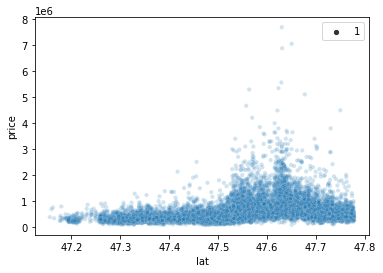

In [98]:
sns.scatterplot(data=df, x='lat', y='price', size=1, alpha=0.2);

There does seem to be some kind of relationship here, as the latitude goes up (we go north from the southern edge of the county), price tends to increase. This makes sense from our mapping in EDA, as we saw Seattle and its suburbs start around 47.5 degrees latitude.

## 'long'

In [99]:
df.long.describe()

count    21597.000000
mean      -122.213982
std          0.140724
min       -122.519000
25%       -122.328000
50%       -122.231000
75%       -122.125000
max       -121.315000
Name: long, dtype: float64

Longitude goes from -122.519000 to -121.315000.

Combined with 'lat' we can plot the locations of our our sold homes on a map and look for patterns

In terms of modeling, EDA showed that this feature is not very correlated with price

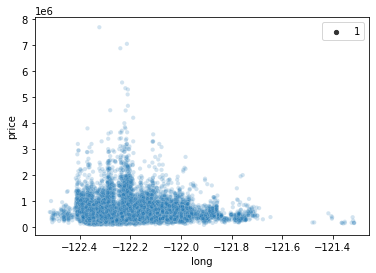

In [100]:
sns.scatterplot(data=df, x='long', y='price', size=1, alpha=0.2);

As we saw in mapping, as we go west in the county (decrease our longitude) we see most of our home. There was not very much correlation here, and that makes sense because the geography of the county restricts most development to the western part. Once you are in the better longitude, there is variation moving north and south that we saw in latitude.

## 'sqft_living15'

In [101]:
df.sqft_living15.describe()

count    21597.000000
mean      1986.620318
std        685.230472
min        399.000000
25%       1490.000000
50%       1840.000000
75%       2360.000000
max       6210.000000
Name: sqft_living15, dtype: float64

Per the data notes, these values are the square footage of interior housing living space for the nearest 15 neighbors. It looks to already be an average value, we do not need to engineer anything.

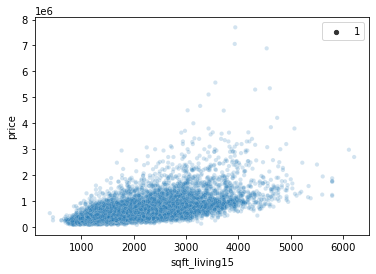

In [102]:
sns.scatterplot(data=df, x='sqft_living15', y='price', alpha=0.2, size=1);

There looks to be a slight relationship between the size of homes around the particular home and the sale price. We will see how the baseline model reacts to the data. It did show higher correlation from the matrix, but we do suspect multicollinearity.

## 'sqft_lot15'

In [103]:
df.sqft_lot15.describe()

count     21597.000000
mean      12758.283512
std       27274.441950
min         651.000000
25%        5100.000000
50%        7620.000000
75%       10083.000000
max      871200.000000
Name: sqft_lot15, dtype: float64

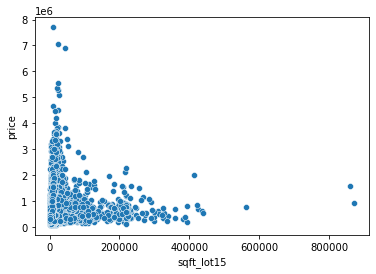

In [104]:
sns.scatterplot(data=df, x='sqft_lot15', y='price');

Again, based on data notes and experience with the dataset (and values from the other 'sqft_lot' feature), these values are the average lot for the 15 nearest neighbors to the property.

During EDA we saw there was barely any correlation between this feature and price. The plot of this feature with price doesn't seem to be linear, so on it's own the feature is likely not going to help the model.

What it may help us do is categorize neighborhoods, or create a feature where the home is more likely to be around homes of similar sizes.

In [105]:
# because we are using statsmodels to create our model, we need to add a
# constant. Before, we were adding the constant inside our helper function
# and that is why we were unable to predict on X_test: X_test didn't have a
# constant added to it. So what we are going to do is add it here rather than
# in our helper function, so we won't forget it when train/test splitting.

In [106]:
df = sm.add_constant(df)

In [107]:
df.columns

Index(['const', 'id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'has_view'],
      dtype='object')

In [108]:
# just in case we need to revert to original dropped features list
# features_to_drop = ['id', 'date', 'price', 'view', 'zipcode']

# Baseline model

In [109]:
# new helper using sklearn alongside statsmodels OLS for predictions
def model_evaluation(X, y):
    """
    This helper function sets up a linear regression model, evaluates the r^2
    score and reports on the features' coefficients and p-values, and any
    recommendations for removal based on p-value or multicollinearity.
    
    It takes in an already created X (set of predictors) and y (target). This
    way the function can be used before and after test_train_splits or any
    scaling or other preprocessing
    
    It prints the adjusted r2 score from the model, and gives a brief on any
    features to be removed based on their coefficients' high p-value.
    
    It also creates a table of VIF scores for features relative o 
    """
    # old sklearn lin_reg stuff
#     lin_reg = LinearRegression()
#     lin_reg.fit(X, y)
#     y_pred = lin_reg.predict(X)
#     r2score = r2_score(y, y_pred)
#     print('r^2 adjusted score:', r2score, '\n')
    
    # making statsmodels OLS model
#     X_const = sm.add_constant(X) <<< this is where I used to add constant
    model = sm.OLS(y, X).fit()

    # dataframe of predictors, their coefficients and p-values
    predictors = pd.DataFrame([])
    predictors['coeff'] = model.params
    predictors['pvalue'] = model.pvalues
    
    # highlight predictors with higher than threshold p-values
    print('Predictors where coefficient pvalue is > 0.05:')
    if len(predictors[predictors.pvalue > 0.05]) > 0:
        print(list(predictors[predictors.pvalue > 0.05].index))
    else:
        print('0')
        
    # inner function to calculate VIF for features relative to target
    # to check for multicollinearity.
    def calc_vif(feat):
        vif = pd.DataFrame()
        # removing first column
        x = feat.iloc[: , 1:]
        vif['variables'] = x.columns
        vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
        return(vif)
    
    # create the VIG table for predictors, to be returned by function
    vif = calc_vif(X)
    
    display(model.summary())

    return model, predictors, vif

Our baseline model is all predictors with the exception of: id, date, and zipcode. 'view' was engineered into a new feature 'has_view' but we wanted to keep the original in place.

In [110]:
X = df.drop(features_to_drop, axis=1)
y = df.price

bl_model, bl_predictors, bl_vif = model_evaluation(X, y)

Predictors where coefficient pvalue is > 0.05:
['floors']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     2886.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:34:29   Log-Likelihood:            -2.9459e+05
No. Observations:               21597   AIC:                         5.892e+05
Df Residuals:                   21579   BIC:                         5.894e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.683e+07    1.6e+06    -23.005      0.000      -4e+07   -3.37e+07
bedrooms      -3.807e+04   1995.793    -19.076      0.000    -4.2e+04   -3.42e+04
bathrooms      4.379e+04   3297.643     13.279      0.000    3.73e+04    5.03e+04
sqft_living     100.7294     18.249      5.520      0.000      64.961     136.498
sqft_lot          0.1311      0.048      2.710      0.007       0.036       0.226
floors         1740.0219   3617.663      0.481      0.631   -5350.866    8830.910
waterfront     6.972e+05   1.75e+04     39.828      0.000    6.63e+05    7.31e+05
condition      3.158e+04   2353.406     13.419      0.000     2.7e+04    3.62e+04
grade           9.86e+04   2179.680     45.234      0.000    9.43e+04    1.03e+05
sqft_above       80.3181     18.237      4.404      0.000      44.572     116.064
sqft_basement    50.6676     18.073      2.804      0.005      15.244      86.091
yr_built      -2502.6709     72.055    -34.733      0.000   -2643.903   -2361.438
yr_renovated     25.2837      4.013      6.300      0.000      17.417      33.150
lat            5.551e+05   1.06e+04     52.503      0.000    5.34e+05    5.76e+05
long          -1.197e+05    1.2e+04     -9.936      0.000   -1.43e+05   -9.61e+04
sqft_living15    28.3567      3.470      8.172      0.000      21.555      35.158
sqft_lot15       -0.4004      0.074     -5.408      0.000      -0.546      -0.255
has_view       1.073e+05   5232.578     20.499      0.000     9.7e+04    1.18e+05
==============================================================================
Omnibus:                    18422.014   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1818110.030
Skew:                           3.594   Prob(JB):                         0.00
Kurtosis:                      47.371   Cond. No.                     5.86e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.86e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Checking assumptions

1) Independence - Durbin-Watson Score
- [Acceptable](https://www.investopedia.com/terms/d/durbin-watson-statistic.asp#:~:text=A%20rule%20of%20thumb%20is,not%20applicable%20in%20certain%20situations.) Durbin-Watson score is between 1.5 and 2.5, so we will report that in our assumptions test

2) Normality - QQ Plotting / Jarque-Bera Score
- Check the QQ plot, the points should follow the angled line.

3) Homoscedasticity - Scatter Plotting / Goldfeld-Quandt
- Look at the spread of the points relative to the horizontal line. There should be no coning
______
Here we implement a helper function to streamline checking our assumptions

In [111]:
def assumptions(model):

    # this other helper function within the assumptions checker was sourced
    # from https://stackoverflow.com/questions/51734180/converting-statsmodels
    #-summary-object-to-pandas-dataframe
    # It takes in a model and outputs a dictionary with which you can pull
    # values from the summary
    def get_metrics(res):

        model_results_df = []
        coefficient_df = None
        for i, tab in enumerate(res.summary().tables):
            header, index_col = None, None
            if i == 1:
                coefficient_df = pd.read_html(tab.as_html(), header=0, index_col=0)[0]
            else:
                df = pd.read_html(tab.as_html())[0]
                model_results_df += [df.iloc[:,0:2], df.iloc[:,2:4]]

        model_results_df = pd.DataFrame(np.concatenate(model_results_df), columns=['metric', 'value'])
        model_results_df.dropna(inplace=True, axis=0)
        model_results_df.metric = model_results_df.metric.apply(lambda x : x.lower().replace(' (', '_')
                                                                .replace('.', '').replace('(', '_')
                                                                .replace(')', '').replace('-', '_')
                                                               .replace(':', '').replace(' ', '_'))

        res_dict = dict(zip(model_results_df.metric.values, model_results_df.value.values))
        return res_dict
    
    metrics = get_metrics(model)
    
    testing_df = pd.DataFrame()
    testing_df['predicted'] = model.predict()
    testing_df['resid'] = model.resid
    
    durbin_watson = metrics['durbin_watson']
    if ((durbin_watson >= 1.5) & (durbin_watson <= 2.5)):
        dw_passes = 'passed'
    else:
        dw_passes = 'failed'
    
    print('Reporting on Assumptions of Linear Regression')
    print('---------------------------------------------', '\n')
    print('Assumption 1: Independence of Residuals')
    print('---------------------------------------------')
    print('Evaluated by Durbin-Watson Score between 1.5 and 2.5')
    print(f'Score: {durbin_watson}\tAssumption: {dw_passes}.', '\n')
    
    print('Assumption 2: Normal Distribution of Residuals')
    print('---------------------------------------------')
    from scipy import stats
    stats.probplot(model.resid, dist='norm', plot=plt)
    plt.show()
    print('Assumption 3: Homoscedasticity in Residuals')
    print('---------------------------------------------')
    sns.lmplot(data=testing_df, x='predicted', y='resid')
    plt.show();

Reporting on Assumptions of Linear Regression
--------------------------------------------- 

Assumption 1: Independence of Residuals
---------------------------------------------
Evaluated by Durbin-Watson Score between 1.5 and 2.5
Score: 1.99	Assumption: passed. 

Assumption 2: Normal Distribution of Residuals
---------------------------------------------


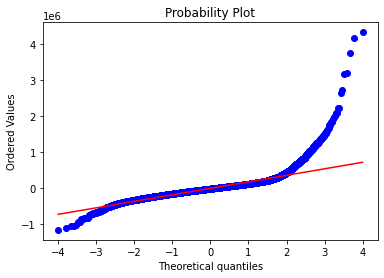

Assumption 3: Homoscedasticity in Residuals
---------------------------------------------


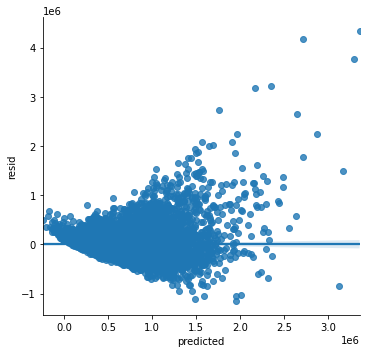

In [112]:
assumptions(bl_model)

Most certainly not meeting the last 2 assumptions, we will need to continue to modify our predictors

## Exploring coefficient p-values

Now we can pull out all features whose coefficients' p-value was greater than the threshold (0.05)
_______
We will add these features to our features-to-drop list and work on engineering later

In [113]:
features_to_drop.extend(list(bl_predictors[bl_predictors.pvalue > 0.05].index))

## Identify multicollinearity

Using a VIF cutoff value of 5, we can see if there are features with extremely high multicollinearity that might be eligible for removal from the model.

In [114]:
bl_vif

,variables,VIF
0,bedrooms,25.370848
1,bathrooms,28.781497
2,sqft_living,900.809434
3,sqft_lot,2.362915
4,floors,16.750671
5,waterfront,1.084047
6,condition,34.528871
7,grade,142.881225
8,sqft_above,674.560903
9,sqft_basement,47.021961


In [115]:
bl_vif[bl_vif.VIF>5]

,variables,VIF
0,bedrooms,25.370848
1,bathrooms,28.781497
2,sqft_living,900.809434
4,floors,16.750671
6,condition,34.528871
7,grade,142.881225
8,sqft_above,674.560903
9,sqft_basement,47.021961
10,yr_built,8382.411042
12,lat,119893.803485


We already suspected that 'sqft_above' and 'sqft_basement' would experience multicollinearity. 'lat' and 'long' for obvious reasons. 'yr_built' also seems to probably just not have a relationship with price. Adding these 5 features to the drop list.

In [116]:
features_to_drop.extend(['sqft_above','sqft_basement','yr_built','lat','long'])

# Model v1 - dropping features

We have been keeping track of features to drop so far:
- based on the p-value of the coefficient from the OLS baseline model and
- the test for multicollinearity that was performed

In [117]:
X = df.drop(features_to_drop, axis=1)
y = df.price

model_v1, predictors_v1, vif_v1 = model_evaluation(X, y)

Predictors where coefficient pvalue is > 0.05:
['sqft_lot']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     3078.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:34:31   Log-Likelihood:            -2.9720e+05
No. Observations:               21597   AIC:                         5.944e+05
Df Residuals:                   21585   BIC:                         5.945e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -7.107e+05   1.73e+04    -41.125      0.000   -7.45e+05   -6.77e+05
bedrooms      -3.805e+04   2243.472    -16.959      0.000   -4.24e+04   -3.36e+04
bathrooms     -1.638e+04   3263.655     -5.020      0.000   -2.28e+04   -9987.014
sqft_living     197.1035      3.769     52.302      0.000     189.717     204.490
sqft_lot          0.0212      0.054      0.390      0.697      -0.085       0.128
waterfront      6.87e+05   1.97e+04     34.792      0.000    6.48e+05    7.26e+05
condition      6.101e+04   2463.750     24.763      0.000    5.62e+04    6.58e+04
grade          9.919e+04   2288.122     43.351      0.000    9.47e+04    1.04e+05
yr_renovated     77.6691      4.329     17.940      0.000      69.183      86.155
sqft_living15    11.2608      3.731      3.018      0.003       3.948      18.573
sqft_lot15       -0.7781      0.083     -9.375      0.000      -0.941      -0.615
has_view        1.38e+05   5686.401     24.275      0.000    1.27e+05    1.49e+05
==============================================================================
Omnibus:                    15545.676   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           906200.372
Skew:                           2.876   Prob(JB):                         0.00
Kurtosis:                      34.208   Cond. No.                     6.41e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Reporting on Assumptions of Linear Regression
--------------------------------------------- 

Assumption 1: Independence of Residuals
---------------------------------------------
Evaluated by Durbin-Watson Score between 1.5 and 2.5
Score: 1.98	Assumption: passed. 

Assumption 2: Normal Distribution of Residuals
---------------------------------------------


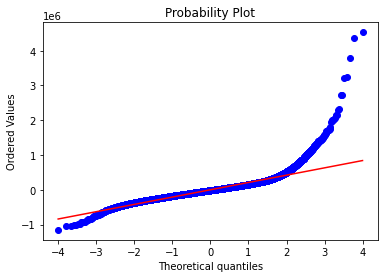

Assumption 3: Homoscedasticity in Residuals
---------------------------------------------


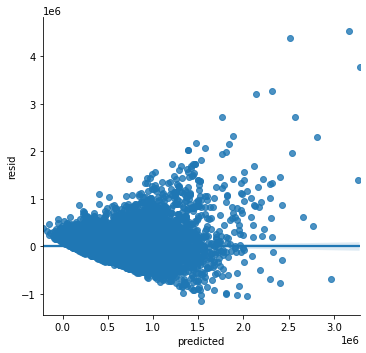

In [118]:
assumptions(model_v1)

In [119]:
vif_v1

,variables,VIF
0,bedrooms,22.140619
1,bathrooms,22.173024
2,sqft_living,24.351235
3,sqft_lot,2.355287
4,waterfront,1.082677
5,condition,19.858058
6,grade,54.711372
7,yr_renovated,1.050508
8,sqft_living15,25.235325
9,sqft_lot15,2.562710


Dropping 'sqft_lot' due to the high p-value of the coefficient. We will also drop 'bedrooms', 'bathrooms', 'grade', and 'sqft_living15' based on VIF scores. Leaving 'condition' for now.

In [120]:
features_to_drop.extend(['sqft_lot','bedrooms', 'bathrooms', 'grade','sqft_living15'])

In [121]:
X = df.drop(features_to_drop, axis=1)
y = df.price

model_v2, predictors_v2, vif_v2 = model_evaluation(X, y)

Predictors where coefficient pvalue is > 0.05:
0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     4554.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:34:33   Log-Likelihood:            -2.9856e+05
No. Observations:               21597   AIC:                         5.971e+05
Df Residuals:                   21590   BIC:                         5.972e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -1.6e+05   9931.157    -16.109      0.000   -1.79e+05   -1.41e+05
sqft_living    263.9801      1.915    137.878      0.000     260.227     267.733
waterfront    7.054e+05    2.1e+04     33.623      0.000    6.64e+05    7.47e+05
condition     3.944e+04   2567.886     15.360      0.000    3.44e+04    4.45e+04
yr_renovated    66.3027      4.595     14.429      0.000      57.296      75.309
sqft_lot15      -0.7058      0.062    -11.388      0.000      -0.827      -0.584
has_view      1.667e+05   5988.154     27.839      0.000    1.55e+05    1.78e+05
==============================================================================
Omnibus:                    13395.001   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           476890.381
Skew:                           2.432   Prob(JB):                         0.00
Kurtosis:                      25.501   Cond. No.                     3.81e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.81e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Reporting on Assumptions of Linear Regression
--------------------------------------------- 

Assumption 1: Independence of Residuals
---------------------------------------------
Evaluated by Durbin-Watson Score between 1.5 and 2.5
Score: 1.977	Assumption: passed. 

Assumption 2: Normal Distribution of Residuals
---------------------------------------------


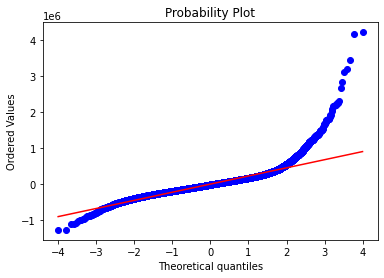

Assumption 3: Homoscedasticity in Residuals
---------------------------------------------


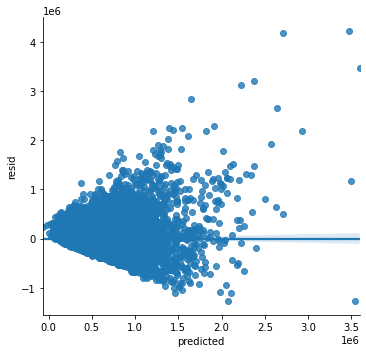

In [122]:
assumptions(model_v2)

We have pruned features from our model based on p-values and multicollinearity, but our r${^2}$ score is not great at 55. We will now work on engineering new features from the dropped ones to improve the model

# Feature Engineering

Other than 'date' and 'price', these are the features dropped through the first two OLS linear regression models due to multicollinearity and/or high coefficient p-values. On their own these features do not help predict the price of a home, but perhaps we can use the information to engineer new features that will.

Just to be sure we are working from a copy of our dataframe that we will call df_v2. We also will set up dataframes for each subsection of engineered features as we work on them and then will add them into df_v2 for modeling and evaluation.

In [123]:
df_v2 = df.copy()

In [124]:
sorted(features_to_drop)

['bathrooms',
 'bedrooms',
 'date',
 'floors',
 'grade',
 'id',
 'lat',
 'long',
 'price',
 'sqft_above',
 'sqft_basement',
 'sqft_living15',
 'sqft_lot',
 'view',
 'yr_built',
 'zipcode']

## Model v3 - rooms

The number of bedrooms and bathrooms must be important to cost. There are some other ways of thinking about how the rooms relate to the rest of the home, and what else you can say about the features of that home.

In [125]:
room_features = df_v2[['price','sqft_living','bedrooms',
                           'bathrooms']].copy()

One idea is to look at the the density of the room type based on total square footage and see if that has any relationship to price.

In [126]:
room_features['bath_per_ft2'] = room_features.bathrooms/room_features.sqft_living
room_features['bed_per_ft2'] = room_features.bedrooms/room_features.sqft_living

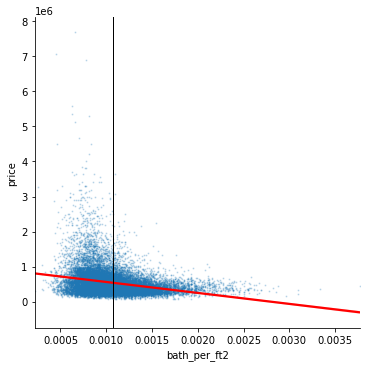

In [127]:
sns.lmplot(data=room_features, x='bath_per_ft2', y='price',
           line_kws={'color':'red'},
           scatter_kws={'s':1,'alpha':0.2})
plt.axvline(x=room_features.bath_per_ft2.mean(), color='black', lw=1,
            label='Avg');

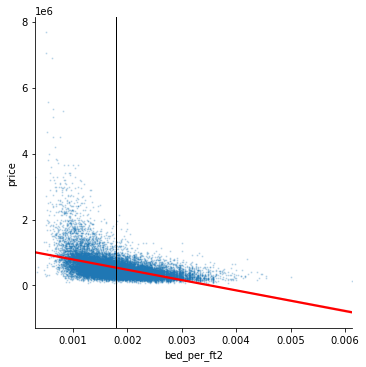

In [128]:
sns.lmplot(data=room_features, x='bed_per_ft2', y='price',
           line_kws={'color':'red'},
           scatter_kws={'s':1,'alpha':0.2})
plt.axvline(x=room_features.bed_per_ft2.mean(), color='black', lw=1,
            label='Avg');

It seems that as the density for either room increases, price tends to decrease. If we think about this, there gets to be a point at which there would be too many bedrooms or bathrooms and not enough space in the rest of the home to enjoy.
___________________
Research shows that the ratio of bedrooms to bathrooms in a home is generally at 3:2. Using this information, we will see if there is anything interesting in the data. The data for bathroom count is a float, we are going to look at two interpretations: one where the bathrooms is rounded to the next whole number, and one where it is not.

In [129]:
#rounding up bathrooms
def bathbedratio(df):
    expected_bathrooms = math.ceil(df.bedrooms*(2/3))
    if math.ceil(df.bathrooms) > expected_bathrooms:
        return 1
    elif math.ceil(df.bathrooms) < expected_bathrooms:
        return -1
    elif math.ceil(df.bathrooms) == expected_bathrooms:
        return 0
    
#not rounding up    
def nrbathbedratio(df):
    expected_bathrooms = df.bedrooms*(2/3)
    if df.bathrooms > expected_bathrooms:
        return 1
    elif df.bathrooms < expected_bathrooms:
        return -1
    elif df.bathrooms == expected_bathrooms:
        return 0

In [130]:
room_features['bathbedratio'] = room_features.apply(lambda x: bathbedratio(x), axis=1)
room_features['nrbathbedratio'] = room_features.apply(lambda x: nrbathbedratio(x), axis=1)

In [131]:
room_features.bathbedratio.value_counts(normalize=True).sort_index()

-1    0.302959
 0    0.433486
 1    0.263555
Name: bathbedratio, dtype: float64

In [132]:
room_features.nrbathbedratio.value_counts(normalize=True).sort_index()

-1    0.585174
 0    0.049035
 1    0.365792
Name: nrbathbedratio, dtype: float64

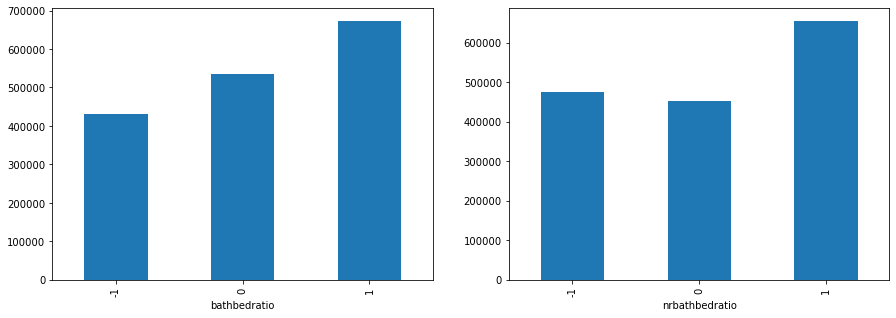

In [133]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
room_features.groupby('bathbedratio').mean()['price'].plot(kind='bar',
                                                           ax=ax[0])
room_features.groupby('nrbathbedratio').mean()['price'].plot(kind='bar',
                                                             ax=ax[1]);

Rounding up to the next integer for bathroom count shows that a bit more than 2/3 meet or exceed when rounding up. Additionally, the average price goes up as we move from not meeting to meeting to exceeding the ratio.

If we don't round the bathroom value up to the nearest integer, the majority of the previously matched ratio homes are now counted as below the ratio. 59.8% now do not meet the ratio, 35.2% exceed it, and only 5% match exactly

Not rounding there is a positive difference in price between exceeding and failing to meet the ratio, but the price drops from failing to meet to meeting.


>We are going to use the rounded ratio
______________

In [134]:
room_features['exceedbbr'] = room_features.nrbathbedratio.map(lambda x: 1 if x == 1 else 0)

>Additionally, we are going to try a new binary feature from the non-rounding feature. There doesn't seem to be too much of a difference in meeting exactly or not meeting the ratio, but there is a large jump to exceeding. So this feature is if the home exceeds the ratio of 3:2.
_______

Adding the two densities, the rounded bed:bath ratio and the binary exceeds ratio to the dataframe for modeling.

In [135]:
df_v2['bath_per_ft2'] = room_features.bath_per_ft2
df_v2['bed_per_ft2'] = room_features.bed_per_ft2
df_v2['bedbathratio'] = room_features.bathbedratio
df_v2['exceedbbr'] = room_features.exceedbbr

In [136]:
X = df_v2.drop(features_to_drop, axis=1)
y = df_v2.price

model_v3, predictors_v3, vif_v3 = model_evaluation(X,y)

Predictors where coefficient pvalue is > 0.05:
0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     2790.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:34:38   Log-Likelihood:            -2.9843e+05
No. Observations:               21597   AIC:                         5.969e+05
Df Residuals:                   21586   BIC:                         5.970e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.113e+05    1.7e+04    -18.358      0.000   -3.45e+05   -2.78e+05
sqft_living    276.8082      2.717    101.892      0.000     271.483     282.133
waterfront     6.99e+05   2.09e+04     33.498      0.000    6.58e+05     7.4e+05
condition       4.4e+04   2588.850     16.995      0.000    3.89e+04    4.91e+04
yr_renovated    65.4407      4.575     14.305      0.000      56.474      74.407
sqft_lot15      -0.6633      0.062    -10.723      0.000      -0.784      -0.542
has_view      1.654e+05   5967.345     27.711      0.000    1.54e+05    1.77e+05
bath_per_ft2  3.676e+07    8.8e+06      4.178      0.000    1.95e+07     5.4e+07
bed_per_ft2    2.59e+07   5.44e+06      4.759      0.000    1.52e+07    3.66e+07
bedbathratio -1.574e+04   4336.982     -3.629      0.000   -2.42e+04   -7236.218
exceedbbr     6.032e+04   5539.770     10.888      0.000    4.95e+04    7.12e+04
==============================================================================
Omnibus:                    13086.678   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           439952.283
Skew:                           2.367   Prob(JB):                         0.00
Kurtosis:                      24.598   Cond. No.                     1.71e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Reporting on Assumptions of Linear Regression
--------------------------------------------- 

Assumption 1: Independence of Residuals
---------------------------------------------
Evaluated by Durbin-Watson Score between 1.5 and 2.5
Score: 1.975	Assumption: passed. 

Assumption 2: Normal Distribution of Residuals
---------------------------------------------


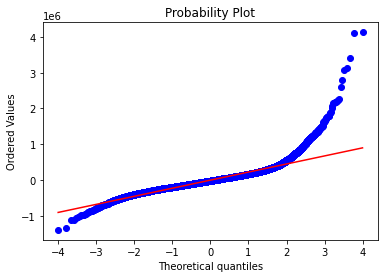

Assumption 3: Homoscedasticity in Residuals
---------------------------------------------


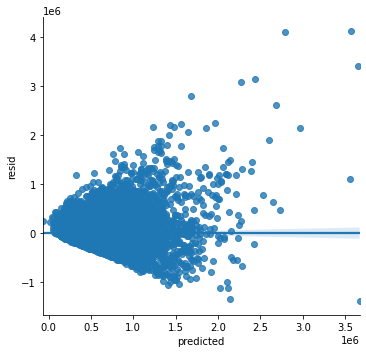

In [137]:
assumptions(model_v3)

In [138]:
vif_v3

,variables,VIF
0,sqft_living,6.725137
1,waterfront,1.078874
2,condition,20.703497
3,yr_renovated,1.051372
4,sqft_lot15,1.267050
5,has_view,1.275520
6,bath_per_ft2,31.103414
7,bed_per_ft2,31.690708
8,bedbathratio,3.850662
9,exceedbbr,4.043641


Neither of the square footage features seemed appropriate, but both the bedbathratio and the exceedbbr features are below our threshold. For now we will keep bedbathratio

In [139]:
features_to_drop.extend(['bed_per_ft2', 'bath_per_ft2', 'exceedbbr'])

## Model v4 - actual living space

The only room information we have on room count is bedrooms and bathrooms, but we can use that and try to make some extrapolations.

[Research](https://www.thespruce.com/average-kitchen-size-1822119#:~:text=Typically%2C%20a%20kitchen%20occupies%2010,include%20homes%20of%20all%20ages)
shows the in the United States there is generally an owners bedroom and then standard bedrooms. The average owner's room is 224 ft${^2}$ the average standard bedroom is 132 ft${^2}$. We will assume the one bedroom in each home is an owners room and the remaining bedrooms are standard when calculating sizes.

Average bathroom size is more difficult. The bathroom feature is a value composed of an unknown combination of bathroom types. Bathrooms can be a variety of square footage depending on components and purpose. Since the data we have is not whole number of bathrooms, we are going to use a coefficient we found during [research](https://www.homestratosphere.com/average-size-bathroom/) that the average bathroom size is 40 ft${^2}$. This way partial baths will be counted a bit smaller and should be more accurate for total square footage of all bathrooms in the home.


We can also say that every home needs a kitchen. [Researching](https://www.thespruce.com/average-kitchen-size-1822119#:~:text=Typically%2C%20a%20kitchen%20occupies%2010,include%20homes%20of%20all%20ages) average kitchen size in the United States shows that this varies based on the size of the home, but there is a generally agreed upon percentage of 10-15% total square footage; we will split the difference and use 12.5%.


There are no additional assumptions we could make other than to subtract all these figures from total square footage and that would give us a figure of actual living space in the home. That space may be made up of multiple other rooms, like a separate family/sitting room, formal dining, office, etc. But at least we can account for how much of the total home can be used for everyday activities and guests, and we will call that sqft_entertain

In [140]:
def living_area(df):
    area = df.sqft_living
    
    # total bedroom sqft, first bedroom is 224, all others 132
    bedrooms = 224 + ((df.bedrooms-1)*132)
    
    # total bathroom sqft
    bathrooms = 40*df.bathrooms
    
    # approximate kitchen sqft
    kitchen = area * .125
    
    return area-(bedrooms+bathrooms+kitchen)

In [141]:
space_features = df_v2[['price','sqft_living','bedrooms','bathrooms']].copy()

In [142]:
space_features['sqft_entertain'] = space_features.apply(lambda x: living_area(x), axis=1)

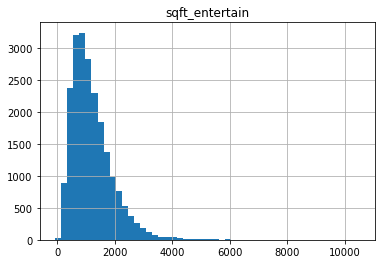

In [143]:
space_features.hist(column='sqft_entertain', bins=50);

In [144]:
space_features.sqft_entertain.describe()

count    21597.000000
mean      1198.569529
std        716.474009
min        -89.250000
25%        689.500000
50%       1046.625000
75%       1544.375000
max      10511.500000
Name: sqft_entertain, dtype: float64

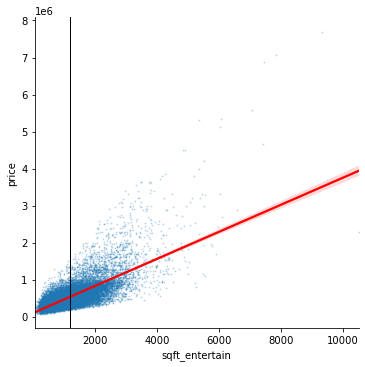

In [145]:
sns.lmplot(data=space_features[space_features.sqft_entertain > 0], x='sqft_entertain', y='price',
           scatter_kws={'alpha':0.2, 's':1},
           line_kws={'color':'red'})
plt.axvline(x=space_features.sqft_entertain.mean(), color='black', lw=1,
            label='Avg');

Definitely a relationship between this new measure of square footage in the home to price. BUT we do have some negative values

In [146]:
space_features[space_features.sqft_entertain <= 0]

,price,sqft_living,bedrooms,bathrooms,sqft_entertain
1166,290000.0,440,2,0.75,-1.00
4199,150000.0,490,3,0.75,-89.25


We will have to come back to these
_______
Maybe if we instead look at it as a percentage of total home that will be more revealing.

In [147]:
space_features['percent_entertain'] = space_features.sqft_entertain/space_features.sqft_living

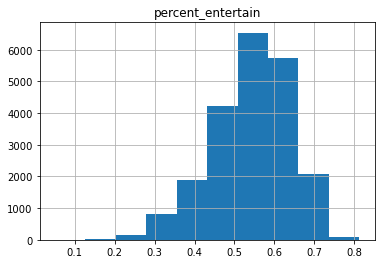

In [148]:
space_features[space_features.percent_entertain > 0].hist(column='percent_entertain', bins=10);

In [149]:
space_features.percent_entertain.describe()

count    21597.000000
mean         0.541946
std          0.098231
min         -0.182143
25%          0.480970
50%          0.551046
75%          0.613365
max          0.812719
Name: percent_entertain, dtype: float64

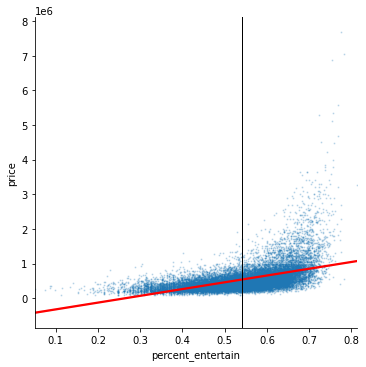

In [150]:
sns.lmplot(data=space_features[space_features.percent_entertain > 0],
           x='percent_entertain', y='price',
           scatter_kws={'alpha':0.2, 's':1},
           line_kws={'color':'red'})
plt.axvline(x=space_features.percent_entertain.mean(), color='black', lw=1,
            label='Avg');

There were two very tiny homes who's engineered features were below zero. Here we instead just set them equal to 0.

In [151]:
space_features.at[1166, ['sqft_entertain','percent_entertain']] = 0
space_features.at[4199, ['sqft_entertain','percent_entertain']] = 0

_______
We could also look at average room size. If we know how many bathrooms and bedrooms there are, and we know there is at least 1 kitchen and 1 common/living area, we could take the total square footage and divide by that number and get average room square footage. For larger homes with more than 1 common area (like a family room, den, sunroom) our estimate will be higher, but maybe that will be ok

In [152]:
space_features['avg_room_size'] = space_features.sqft_living/(space_features.bedrooms + space_features.bathrooms + 2)

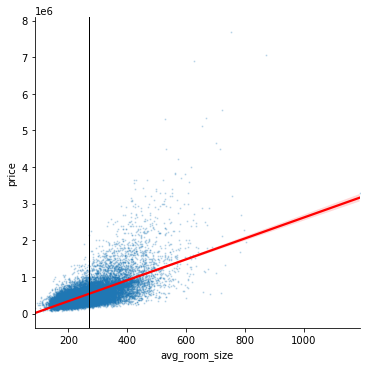

In [153]:
sns.lmplot(data=space_features, x='avg_room_size', y='price',
           scatter_kws={'alpha':0.2, 's':1},
           line_kws={'color':'red'})
plt.axvline(x=space_features.avg_room_size.mean(), color='black', lw=1,
            label='Avg');

___________
We'll put all three of these living space features in and see how they model

In [154]:
df_v2['sqft_entertain'] = space_features.sqft_entertain
df_v2['percent_entertain'] = space_features.percent_entertain
df_v2['avg_room_size'] = space_features.avg_room_size

In [155]:
X = df_v2.drop(features_to_drop, axis=1)
y = df_v2.price

model_v4, predictors_v4, vif_v4 = model_evaluation(X, y)

Predictors where coefficient pvalue is > 0.05:
0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     3215.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:34:45   Log-Likelihood:            -2.9754e+05
No. Observations:               21597   AIC:                         5.951e+05
Df Residuals:                   21586   BIC:                         5.952e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              6.854e+05   2.13e+04     32.217      0.000    6.44e+05    7.27e+05
sqft_living        -410.0898     16.759    -24.470      0.000    -442.938    -377.241
waterfront         6.551e+05   2.01e+04     32.615      0.000    6.16e+05    6.94e+05
condition          4.827e+04   2485.471     19.419      0.000    4.34e+04    5.31e+04
yr_renovated         67.9734      4.386     15.497      0.000      59.376      76.571
sqft_lot15           -0.8386      0.060    -14.066      0.000      -0.955      -0.722
has_view           1.515e+05   5738.708     26.392      0.000     1.4e+05    1.63e+05
bedbathratio      -8117.1659   2741.651     -2.961      0.003   -1.35e+04   -2743.327
sqft_entertain     1165.1820     28.463     40.937      0.000    1109.393    1220.971
percent_entertain -5.073e+05   4.47e+04    -11.342      0.000   -5.95e+05    -4.2e+05
avg_room_size     -2188.5456    105.722    -20.701      0.000   -2395.768   -1981.323
==============================================================================
Omnibus:                     9235.127   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           178594.221
Skew:                           1.578   Prob(JB):                         0.00
Kurtosis:                      16.730   Cond. No.                     8.67e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.67e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Reporting on Assumptions of Linear Regression
--------------------------------------------- 

Assumption 1: Independence of Residuals
---------------------------------------------
Evaluated by Durbin-Watson Score between 1.5 and 2.5
Score: 1.982	Assumption: passed. 

Assumption 2: Normal Distribution of Residuals
---------------------------------------------


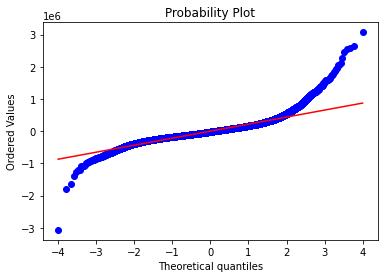

Assumption 3: Homoscedasticity in Residuals
---------------------------------------------


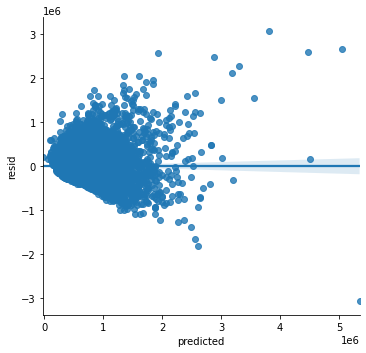

In [156]:
assumptions(model_v4)

In [157]:
vif_v4

,variables,VIF
0,sqft_living,306.799159
1,waterfront,1.084710
2,condition,25.983576
3,yr_renovated,1.050925
4,sqft_lot15,1.281490
5,has_view,1.282327
6,bedbathratio,1.686669
7,sqft_entertain,319.788189
8,percent_entertain,209.560226
9,avg_room_size,317.329546


The model didn't improve, really all we did was create multicollinearity with 'sqft_living'.

In [158]:
features_to_drop.extend(['sqft_entertain','percent_entertain','avg_room_size'])

## Model v5 - renovation

Set up new dataframe 'renovation_features' to hold engineered features before joining in with original features.

We are first working on the renovation status, so we will need some features: yr_built, yr_renovated, and sale_year

In [159]:
renovation_features = df_v2[['price', 'yr_built', 'yr_renovated', 'date']].copy()

During research on renovations, it seems like a general industry standard is that a home is considered renovated if the renovation took place within 15 years. We are engineering a new feature 'is_renovated' as a boolean, with 1 being the home is renovated within 15 years of sale, and 0 being either never renovated or renovations took place more than 15 years before sale.

In [160]:
def renovation_status(df):
    if df.yr_renovated == 0.0:
        return 0
    else:
        if (df.date.year - df.yr_renovated) > 15:
            return 0
        else:
            return 1

renovation_features['is_renovated'] = renovation_features.apply(renovation_status, axis=1)

In [161]:
renovation_features.is_renovated.value_counts()

0    21206
1      391
Name: is_renovated, dtype: int64

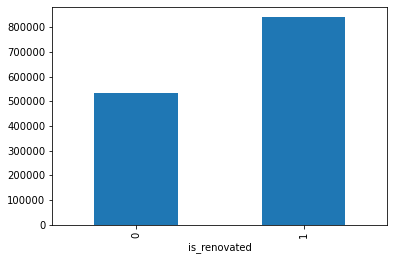

In [162]:
renovation_features.groupby('is_renovated').mean()['price'].plot(kind='bar');

Our renovation feature is now a boolean representing homes that were renovated with 15 years of the sale. There is a definite difference in average price of a renovated home versus one that is not.

In [163]:
df_v2['is_renovated'] = renovation_features.is_renovated

In [164]:
features_to_drop.extend(['yr_renovated'])

In [165]:
X = df_v2.drop(features_to_drop, axis=1)
y = df_v2.price

model_v5, predictors_v5, vif_v5 = model_evaluation(X,y)

Predictors where coefficient pvalue is > 0.05:
0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     3929.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:34:48   Log-Likelihood:            -2.9852e+05
No. Observations:               21597   AIC:                         5.971e+05
Df Residuals:                   21589   BIC:                         5.971e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -1.61e+05   9913.044    -16.238      0.000    -1.8e+05   -1.42e+05
sqft_living    259.5344      2.004    129.519      0.000     255.607     263.462
waterfront    7.187e+05   2.09e+04     34.365      0.000    6.78e+05     7.6e+05
condition     4.277e+04   2597.365     16.468      0.000    3.77e+04    4.79e+04
sqft_lot15      -0.6925      0.062    -11.190      0.000      -0.814      -0.571
has_view      1.688e+05   5969.498     28.277      0.000    1.57e+05     1.8e+05
bedbathratio  1.497e+04   2360.843      6.341      0.000    1.03e+04    1.96e+04
is_renovated  1.968e+05   1.25e+04     15.749      0.000    1.72e+05    2.21e+05
==============================================================================
Omnibus:                    13625.159   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           508179.717
Skew:                           2.479   Prob(JB):                         0.00
Kurtosis:                      26.241   Cond. No.                     3.81e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.81e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Reporting on Assumptions of Linear Regression
--------------------------------------------- 

Assumption 1: Independence of Residuals
---------------------------------------------
Evaluated by Durbin-Watson Score between 1.5 and 2.5
Score: 1.978	Assumption: passed. 

Assumption 2: Normal Distribution of Residuals
---------------------------------------------


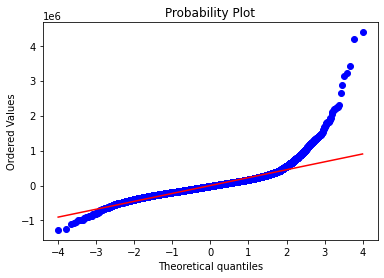

Assumption 3: Homoscedasticity in Residuals
---------------------------------------------


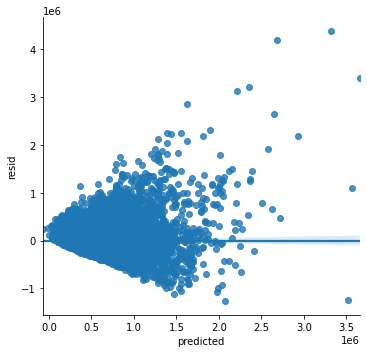

In [166]:
assumptions(model_v5)

In [167]:
vif_v5

,variables,VIF
0,sqft_living,6.257902
1,waterfront,1.074842
2,condition,5.723437
3,sqft_lot15,1.262934
4,has_view,1.254523
5,bedbathratio,1.148520
6,is_renovated,1.023309


## Model v6 - basement

The sqft_basement poses some interesting questions. I think first we want a column to see if there is a basement or not

In [168]:
basement_features = df_v2[['price', 'sqft_living', 'sqft_basement']].copy()

In [169]:
basement_features['has_basement'] = basement_features.sqft_basement.map(
    lambda x: 1 if x > 0 else 0)

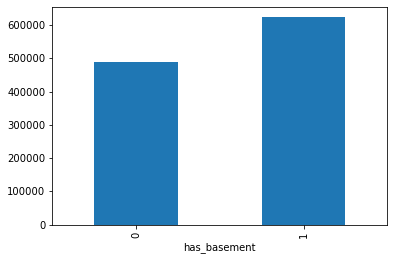

In [170]:
basement_features.groupby('has_basement').mean()['price'].plot(kind='bar');

Difference in average price by if a basement exists or not looks to be more than \\$100k USD.

In [171]:
def percent_basement(df):
    if df.has_basement == False:
        return 0
    else:
        return round(((df.sqft_basement / df.sqft_living) * 100), 2)

In [172]:
basement_features['basement_percent'] = basement_features.apply(
    percent_basement, axis=1)

In [173]:
basement_features[basement_features.basement_percent > 0
                 ].basement_percent.describe()

count    8317.000000
mean       31.688273
std        11.567126
min         1.000000
25%        23.140000
50%        32.210000
75%        40.780000
max        66.670000
Name: basement_percent, dtype: float64

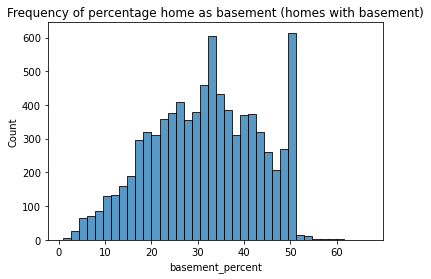

In [174]:
sns.histplot(data=basement_features[basement_features.basement_percent > 0
                                   ], x='basement_percent')
plt.title('Frequency of percentage home as basement (homes with basement)');

In our dataset, 60% of homes have no basement at all.

Of those that have basements, the above histogram shows the binned percent of sqft_living that is made up of sqft_basement.

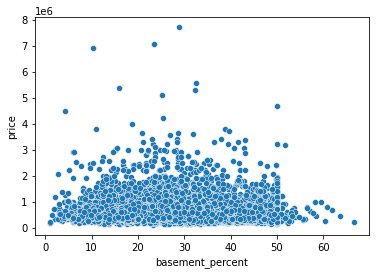

In [175]:
sns.scatterplot(data=basement_features[basement_features.basement_percent > 0],
                x='basement_percent', y='price');

There does not look to be any kind of linear relationship with the percentage basement and price. We would likely just use the boolean 'has_basement'

In [176]:
df_v2['has_basement'] = basement_features.has_basement

In [177]:
X = df_v2.drop(features_to_drop, axis=1)

model_v6, predictors_v6, vif_v6 = model_evaluation(X, y)

Predictors where coefficient pvalue is > 0.05:
['has_basement']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     3437.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:34:50   Log-Likelihood:            -2.9852e+05
No. Observations:               21597   AIC:                         5.971e+05
Df Residuals:                   21588   BIC:                         5.971e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.611e+05   9933.827    -16.222      0.000   -1.81e+05   -1.42e+05
sqft_living    259.6320      2.035    127.553      0.000     255.642     263.622
waterfront    7.186e+05   2.09e+04     34.356      0.000    6.78e+05     7.6e+05
condition     4.287e+04   2623.076     16.345      0.000    3.77e+04     4.8e+04
sqft_lot15      -0.6939      0.062    -11.172      0.000      -0.816      -0.572
has_view       1.69e+05   6025.351     28.052      0.000    1.57e+05    1.81e+05
bedbathratio  1.497e+04   2360.971      6.339      0.000    1.03e+04    1.96e+04
is_renovated  1.969e+05   1.25e+04     15.744      0.000    1.72e+05    2.21e+05
has_basement  -973.8605   3566.591     -0.273      0.785   -7964.642    6016.921
==============================================================================
Omnibus:                    13622.864   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           507837.840
Skew:                           2.479   Prob(JB):                         0.00
Kurtosis:                      26.233   Cond. No.                     3.81e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.81e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Reporting on Assumptions of Linear Regression
--------------------------------------------- 

Assumption 1: Independence of Residuals
---------------------------------------------
Evaluated by Durbin-Watson Score between 1.5 and 2.5
Score: 1.978	Assumption: passed. 

Assumption 2: Normal Distribution of Residuals
---------------------------------------------


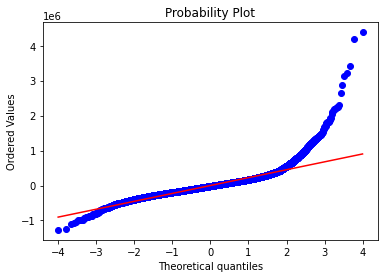

Assumption 3: Homoscedasticity in Residuals
---------------------------------------------


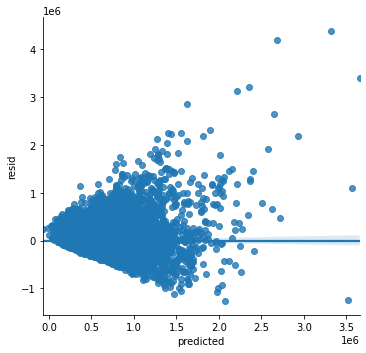

In [178]:
assumptions(model_v6)

In [179]:
vif_v6

,variables,VIF
0,sqft_living,6.430793
1,waterfront,1.075053
2,condition,5.926379
3,sqft_lot15,1.272304
4,has_view,1.280516
5,bedbathratio,1.148599
6,is_renovated,1.025172
7,has_basement,1.774426


## Model v7 - zipcode

In [180]:
zipcode_features = df_v2[['price', 'zipcode']].copy()

There at 70 different zipcode values in our dataset. We want to try and create a new feature that takes zipcodes and matches them up with cities in our area.

In [181]:
# https://zipdatamaps.com/king-wa-county-zipcodes
zip_city = pd.read_csv('data\zip_city.csv')

zipcode_features = pd.merge(left=zipcode_features, right=zip_city, on='zipcode', how='left')

zipcode_features can be merged into the larger dataframe to associate a home with a city instead of just a zipcode.

Let's explore this a bit more.

In [182]:
homes_by_zip = zipcode_features.groupby('city').count()
homes_by_zip.drop('price', axis=1, inplace=True)
homes_by_zip.reset_index(inplace=True)

In [183]:
homes_by_zip.sort_values('zipcode', ascending=False)

,city,zipcode
20,Seattle,8973
18,Renton,1597
1,Bellevue,1407
11,Kent,1201
12,Kirkland,977
17,Redmond,977
0,Auburn,911
19,Sammamish,800
8,Federal Way,779
9,Issaquah,733


We could reduce our 70 zipcodes to 24 cities we could then OneHotEncode. It's no surprise that Seattle dominates the frequency listing of cities in the data, it's the largest city in the state, let alone the county.
_________
The [website](https://www.communitiescount.org/king-county-geographies) where we found the region information listed the names of cities each region defined. We created lists for each of the regions first, then had to check if we had any cities in our data that were not mentioned on the website and assign them correctly

In [184]:
north = ['Bothell', 'Kenmore', 'Woodinville']
east = ['Bellevue', 'Carnation', 'Duvall', 'Issaquah', 'Kirkland', 'Medina',
        'Mercer Island', 'North Bend', 'Redmond', 'Sammamish']
south = ['Auburn', 'Enumclaw', 'Federal Way', 'Kent', 'Maple Valley',
         'Renton', 'Vashon']

In [185]:
region_cities = sorted(north + east + south)
data_cities = sorted(list(homes_by_zip.city))

missing_cities = []
for city in data_cities:
    if city not in region_cities:
        missing_cities.append(city)
        
missing_cities

['Black Diamond', 'Fall City', 'Seattle', 'Snoqualmie']

Seattle will be its own region, but we had to do a bit of map checking to place the three cities we had from our zipcode mapping that were not mentioned on the website discussing the 4 regions of the county.

In [186]:
south.extend(['Black Diamond'])
east.extend(['Fall City', 'Snoqualmie'])

In [187]:
def assignRegion(df):
    if df.city == 'Seattle':
        return 'Seattle'
    elif df.city in north:
        return 'north'
    elif df.city in east:
        return 'east'
    else:
        return 'south'

zipcode_features['region'] = zipcode_features.apply(assignRegion, axis=1)

In [188]:
zipcode_features

,price,zipcode,city,region
0,221900.0,98178,Seattle,Seattle
1,538000.0,98125,Seattle,Seattle
2,180000.0,98028,Kenmore,north
3,604000.0,98136,Seattle,Seattle
4,510000.0,98074,Sammamish,east
...,...,...,...,...
21592,360000.0,98103,Seattle,Seattle
21593,400000.0,98146,Seattle,Seattle
21594,402101.0,98144,Seattle,Seattle
21595,400000.0,98027,Issaquah,east


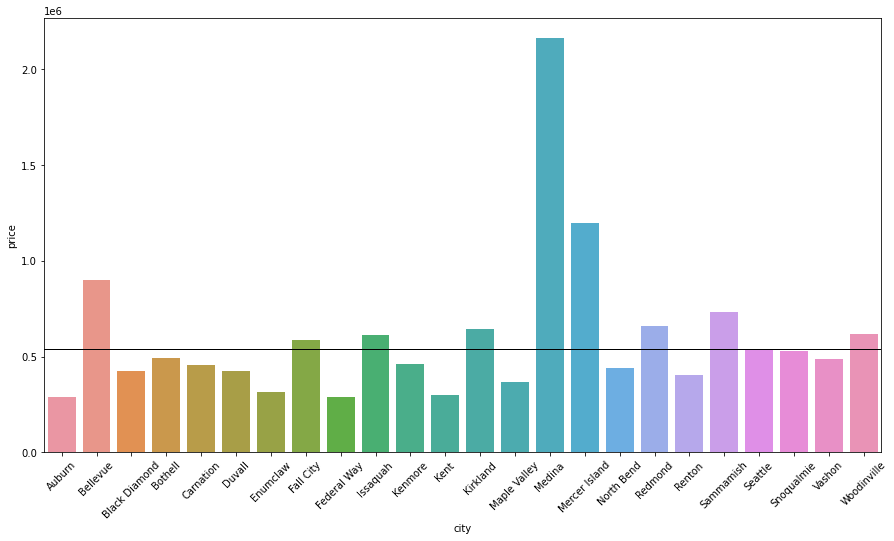

In [189]:
zipcode_city_df = zipcode_features.groupby('city').mean()[['price']]
zipcode_city_df.reset_index(inplace=True)

plt.figure(figsize = (15,8))
ax = sns.barplot(data=zipcode_city_df, x='city', y='price')
plt.axhline(y=df.price.mean(), color='black', lw=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

We can see a definite range in average home prices based on the city the home is in, from \\$281k in Auburn to over \\$2 million in Medina.

Seattle looks like it's right on our total average for home prices in our data, again endorsing the plan to drop that new encoded feature.

Some quick research shows that Medina is not only desirable for King County, but is one of the most desirable neighborhoods in the nation. There is apparently a very high concentration of millionaires. We saw earlier that only 50 homes in our data were in Medina.

Mercer Island is just sound of Medina and is also in high demand, shown by the average home prices. There were several times more homes in our data from Mercer Island compared to Medina, yet the average price is still quite high, more than double the county average.

Bellevue seems like it would be another wealthy area. There were about 1400 homes from that city in our data and the average price there was not quite double the county average.

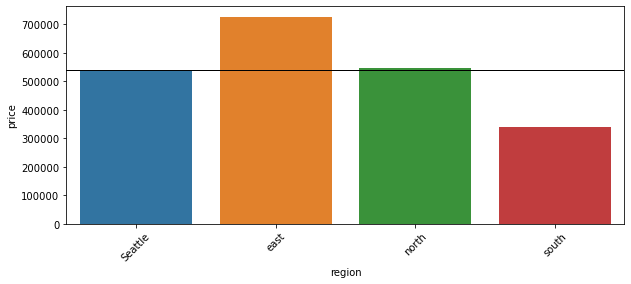

In [190]:
zipcode_region_df = zipcode_features.groupby('region').mean()[['price']]
zipcode_region_df.reset_index(inplace=True)

plt.figure(figsize = (10,4))
ax = sns.barplot(data=zipcode_region_df, x='region', y='price')
plt.axhline(y=df.price.mean(), color='black', lw=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

Here it looks like average home prices based on region has a clear winner in the east region. Seattle and the north region are both pretty even with county average (and each other), and the south regions' average price is less than half that of the easts'.

If we wanted to try a different way of modeling here, it would likely not be OneHotEncoding but a binary feature if the home was in the east region or not. We will try using cities first

-------------
First we will onehotencode the cities and drop Seattle

In [191]:
# import OHE
from sklearn.preprocessing import OneHotEncoder

# create temporary dataframe city_encode with zipcode feature in it
city_encode = zipcode_features[['city']].copy()

# create a onehotencoder, fit to city_encode
ohe = OneHotEncoder().fit(city_encode)

# create the array
onehotarray = ohe.transform(city_encode).toarray()

# create a list of the sorted zipcodes to make column names
ordered_cities = sorted(list(zipcode_features.city.unique()))

# create dataframe of array with correct column names
ohe_df = pd.DataFrame(onehotarray, columns=ordered_cities)

# remove the feature for Seattle
ohe_df.drop(['Seattle'], axis=1, inplace=True)

# concat the main dataframe df with the onehotencoded df we just made
df_v3 = pd.concat([df_v2, ohe_df], axis=1)

In [192]:
X = df_v3.drop(features_to_drop, axis=1)
y = df.price

model_v7, predictors_v7, vif_v7 = model_evaluation(X, y)

Predictors where coefficient pvalue is > 0.05:
['sqft_lot15']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     1551.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:34:54   Log-Likelihood:            -2.9473e+05
No. Observations:               21597   AIC:                         5.895e+05
Df Residuals:                   21565   BIC:                         5.898e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.557e+04   8566.381     -2.985      0.003   -4.24e+04   -8775.772
sqft_living     247.5527      1.849    133.857      0.000     243.928     251.178
waterfront     7.121e+05   1.77e+04     40.146      0.000    6.77e+05    7.47e+05
condition      3.524e+04   2238.855     15.738      0.000    3.08e+04    3.96e+04
sqft_lot15       -0.0055      0.057     -0.097      0.922      -0.117       0.106
has_view       1.273e+05   5165.823     24.640      0.000    1.17e+05    1.37e+05
bedbathratio    3.08e+04   2012.922     15.301      0.000    2.69e+04    3.47e+04
is_renovated   1.302e+05   1.06e+04     12.334      0.000    1.09e+05    1.51e+05
has_basement  -4.595e+04   3139.824    -14.634      0.000   -5.21e+04   -3.98e+04
Auburn        -2.821e+05   7244.660    -38.945      0.000   -2.96e+05   -2.68e+05
Bellevue       1.336e+05   6077.740     21.989      0.000    1.22e+05    1.46e+05
Black Diamond -1.981e+05   2.07e+04     -9.548      0.000   -2.39e+05   -1.57e+05
Bothell       -1.432e+05   1.49e+04     -9.629      0.000   -1.72e+05   -1.14e+05
Carnation     -1.617e+05    1.9e+04     -8.513      0.000   -1.99e+05   -1.24e+05
Duvall        -1.973e+05   1.52e+04    -12.986      0.000   -2.27e+05   -1.68e+05
Enumclaw      -2.695e+05   1.39e+04    -19.383      0.000   -2.97e+05   -2.42e+05
Fall City     -9.711e+04   2.34e+04     -4.154      0.000   -1.43e+05   -5.13e+04
Federal Way   -2.856e+05   7682.098    -37.176      0.000   -3.01e+05   -2.71e+05
Issaquah      -7.781e+04   8071.706     -9.640      0.000   -9.36e+04    -6.2e+04
Kenmore       -1.485e+05   1.24e+04    -11.987      0.000   -1.73e+05   -1.24e+05
Kent          -2.693e+05   6406.897    -42.027      0.000   -2.82e+05   -2.57e+05
Kirkland       1.407e+04   6952.587      2.024      0.043     442.905    2.77e+04
Maple Valley  -2.574e+05   8935.144    -28.808      0.000   -2.75e+05    -2.4e+05
Medina         1.075e+06   2.92e+04     36.768      0.000    1.02e+06    1.13e+06
Mercer Island  2.633e+05   1.26e+04     20.879      0.000    2.39e+05    2.88e+05
North Bend    -1.685e+05   1.41e+04    -11.943      0.000   -1.96e+05   -1.41e+05
Redmond        -4.29e+04   7166.887     -5.986      0.000    -5.7e+04   -2.89e+04
Renton        -2.067e+05   5694.762    -36.300      0.000   -2.18e+05   -1.96e+05
Sammamish     -7.216e+04   7902.862     -9.131      0.000   -8.77e+04   -5.67e+04
Snoqualmie    -2.111e+05   1.21e+04    -17.486      0.000   -2.35e+05   -1.87e+05
Vashon        -2.472e+05   1.97e+04    -12.524      0.000   -2.86e+05   -2.08e+05
Woodinville   -1.052e+05   9946.865    -10.576      0.000   -1.25e+05   -8.57e+04
==============================================================================
Omnibus:                    15919.198   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB

We're not surprised there is multicollinearity here. The value for 'sqft_lot15' is the average lot size for the 15 closest homes. Neighborhoods would tend to have similar sized lots, and we have just added a whole bunch of features placing homes in different cities. We will see if we can engineer another feature to utilize the 'sqft_lot15'.

In [193]:
features_to_drop.extend(['sqft_lot15'])

In [194]:
X = df_v3.drop(features_to_drop, axis=1)
y = df.price

model_v7i, predictors_v7i, vif_v7i = model_evaluation(X, y)

Predictors where coefficient pvalue is > 0.05:
0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     1603.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:34:56   Log-Likelihood:            -2.9473e+05
No. Observations:               21597   AIC:                         5.895e+05
Df Residuals:                   21566   BIC:                         5.898e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.554e+04   8561.248     -2.983      0.003   -4.23e+04   -8757.540
sqft_living     247.5250      1.827    135.454      0.000     243.943     251.107
waterfront     7.121e+05   1.77e+04     40.150      0.000    6.77e+05    7.47e+05
condition      3.523e+04   2238.431     15.740      0.000    3.08e+04    3.96e+04
has_view       1.273e+05   5163.387     24.649      0.000    1.17e+05    1.37e+05
bedbathratio    3.08e+04   2012.415     15.307      0.000    2.69e+04    3.47e+04
is_renovated   1.302e+05   1.06e+04     12.335      0.000    1.09e+05    1.51e+05
has_basement  -4.594e+04   3139.132    -14.635      0.000   -5.21e+04   -3.98e+04
Auburn        -2.822e+05   7218.603    -39.094      0.000   -2.96e+05   -2.68e+05
Bellevue       1.336e+05   6076.782     21.991      0.000    1.22e+05    1.46e+05
Black Diamond -1.983e+05   2.06e+04     -9.616      0.000   -2.39e+05   -1.58e+05
Bothell       -1.432e+05   1.49e+04     -9.630      0.000   -1.72e+05   -1.14e+05
Carnation     -1.621e+05   1.86e+04     -8.731      0.000   -1.98e+05   -1.26e+05
Duvall        -1.975e+05   1.51e+04    -13.077      0.000   -2.27e+05   -1.68e+05
Enumclaw      -2.698e+05   1.37e+04    -19.728      0.000   -2.97e+05   -2.43e+05
Fall City      -9.75e+04    2.3e+04     -4.234      0.000   -1.43e+05   -5.24e+04
Federal Way   -2.856e+05   7680.205    -37.188      0.000   -3.01e+05   -2.71e+05
Issaquah      -7.787e+04   8049.972     -9.673      0.000   -9.36e+04   -6.21e+04
Kenmore       -1.485e+05   1.24e+04    -11.989      0.000   -1.73e+05   -1.24e+05
Kent          -2.693e+05   6401.369    -42.067      0.000   -2.82e+05   -2.57e+05
Kirkland       1.406e+04   6952.070      2.023      0.043     437.060    2.77e+04
Maple Valley  -2.575e+05   8906.419    -28.909      0.000   -2.75e+05    -2.4e+05
Medina         1.075e+06   2.92e+04     36.769      0.000    1.02e+06    1.13e+06
Mercer Island  2.633e+05   1.26e+04     20.880      0.000    2.39e+05    2.88e+05
North Bend    -1.686e+05    1.4e+04    -12.014      0.000   -1.96e+05   -1.41e+05
Redmond       -4.295e+04   7149.195     -6.008      0.000    -5.7e+04   -2.89e+04
Renton        -2.067e+05   5691.754    -36.323      0.000   -2.18e+05   -1.96e+05
Sammamish     -7.218e+04   7900.695     -9.136      0.000   -8.77e+04   -5.67e+04
Snoqualmie    -2.111e+05   1.21e+04    -17.487      0.000   -2.35e+05   -1.87e+05
Vashon        -2.476e+05   1.93e+04    -12.832      0.000   -2.85e+05    -2.1e+05
Woodinville   -1.053e+05   9857.341    -10.686      0.000   -1.25e+05    -8.6e+04
==============================================================================
Omnibus:                    15920.069   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1061933.962
Skew:                           2.941   Prob(JB):         

Reporting on Assumptions of Linear Regression
--------------------------------------------- 

Assumption 1: Independence of Residuals
---------------------------------------------
Evaluated by Durbin-Watson Score between 1.5 and 2.5
Score: 1.994	Assumption: passed. 

Assumption 2: Normal Distribution of Residuals
---------------------------------------------


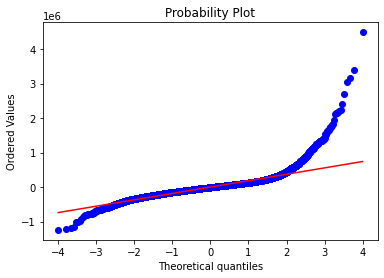

Assumption 3: Homoscedasticity in Residuals
---------------------------------------------


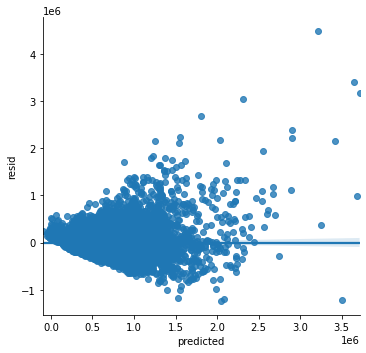

In [195]:
assumptions(model_v7i)

## Model v8 - distance from city center

Was having difficulty importing Geopy in the learn-env, so there is a separate notebook 'geopy' where I import the data and then calculate the distance from the city center of Seattle to the home in miles. I saved that dataframe as distance.csv in in the data folder and import it here.

In [196]:
distance_df = pd.read_csv('data\distances.csv', index_col=[0])

In [197]:
df_v3['d_from_seattle'] = distance_df.d_from_seattle

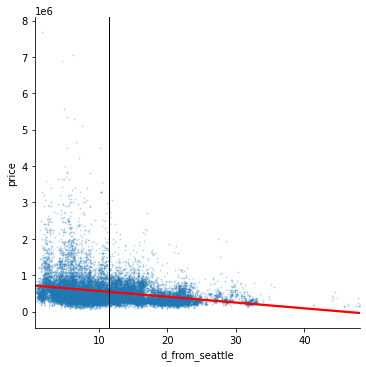

In [198]:
sns.lmplot(data=df_v3, x='d_from_seattle', y='price',
           line_kws={'color':'red'},
           scatter_kws={'s':1,'alpha':0.2})
plt.axvline(x=df_v3.d_from_seattle.mean(), color='black', lw=1,
            label='Avg');

In [199]:
X = df_v3.drop(features_to_drop, axis=1)
y = df.price

model_v8, predictors_v8, vif_v8 = model_evaluation(X, y)

Predictors where coefficient pvalue is > 0.05:
['Bothell', 'Kenmore', 'Vashon']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     1867.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:35:00   Log-Likelihood:            -2.9331e+05
No. Observations:               21597   AIC:                         5.867e+05
Df Residuals:                   21565   BIC:                         5.869e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.641e+05   8725.830     18.803      0.000    1.47e+05    1.81e+05
sqft_living      249.0870      1.711    145.544      0.000     245.733     252.442
waterfront      7.505e+05   1.66e+04     45.148      0.000    7.18e+05    7.83e+05
condition       3.405e+04   2096.218     16.245      0.000    2.99e+04    3.82e+04
has_view        1.285e+05   4835.144     26.578      0.000    1.19e+05    1.38e+05
bedbathratio    2.483e+04   1887.588     13.154      0.000    2.11e+04    2.85e+04
is_renovated    1.125e+05   9886.605     11.374      0.000    9.31e+04    1.32e+05
has_basement   -6.344e+04   2956.694    -21.458      0.000   -6.92e+04   -5.76e+04
Auburn          1.588e+05   1.05e+04     15.151      0.000    1.38e+05    1.79e+05
Bellevue        2.017e+05   5823.104     34.631      0.000     1.9e+05    2.13e+05
Black Diamond   3.296e+05   2.16e+04     15.284      0.000    2.87e+05    3.72e+05
Bothell         2.393e+04   1.43e+04      1.679      0.093   -3999.850    5.19e+04
Carnation       3.241e+05   1.95e+04     16.620      0.000    2.86e+05    3.62e+05
Duvall          1.949e+05   1.58e+04     12.306      0.000    1.64e+05    2.26e+05
Enumclaw        4.628e+05   1.85e+04     25.057      0.000    4.27e+05    4.99e+05
Fall City        3.07e+05   2.28e+04     13.475      0.000    2.62e+05    3.52e+05
Federal Way     1.272e+05   1.04e+04     12.241      0.000    1.07e+05    1.48e+05
Issaquah        1.825e+05   8899.561     20.505      0.000    1.65e+05       2e+05
Kenmore        -8353.5918   1.19e+04     -0.704      0.482   -3.16e+04    1.49e+04
Kent            6.687e+04   8557.945      7.814      0.000    5.01e+04    8.36e+04
Kirkland        1.018e+05   6702.435     15.190      0.000    8.87e+04    1.15e+05
Maple Valley    1.843e+05   1.16e+04     15.923      0.000    1.62e+05    2.07e+05
Medina          1.035e+06   2.74e+04     37.781      0.000    9.81e+05    1.09e+06
Mercer Island   2.573e+05   1.18e+04     21.788      0.000    2.34e+05     2.8e+05
North Bend      4.716e+05   1.76e+04     26.869      0.000    4.37e+05    5.06e+05
Redmond         1.515e+05   7569.367     20.009      0.000    1.37e+05    1.66e+05
Renton         -4.247e+04   6108.685     -6.953      0.000   -5.44e+04   -3.05e+04
Sammamish        1.49e+05   8419.569     17.699      0.000    1.33e+05    1.66e+05
Snoqualmie      2.606e+05   1.42e+04     18.369      0.000    2.33e+05    2.88e+05
Vashon         -1.507e+04   1.86e+04     -0.812      0.417   -5.14e+04    2.13e+04
Woodinville     1.384e+05   1.02e+04     13.520      0.000    1.18e+05    1.58e+05
d_from_seattle -2.911e+04    528.860    -55.037      0.000   -3.01e+04   -2.81e+04
==============================================================================
Omnibus:                    17023.053   Durbin-Watson:                   1.990
Prob(Omnibus):      

The only predictors with multicollinearity are the onehotencoded cities, which we do not drop.

In [200]:
vif_v8

,variables,VIF
0,sqft_living,7.895595
1,waterfront,1.098239
2,condition,10.280103
3,has_view,1.341276
4,bedbathratio,1.188172
5,is_renovated,1.032359
6,has_basement,1.980693
7,Auburn,2.537491
8,Bellevue,1.274437
9,Black Diamond,1.230128


Including this feature did improve the score, but there is some multicollinearity. One idea would be to multiply the square footage by the distance from the city center for a new feature

In [201]:
df_v3['sqftxdistfrsea'] = df_v3.sqft_living * df_v3.d_from_seattle

Another idea is to multiply the sqft_lot by the distance from the city center as well.

In [202]:
df_v3['lotxdistfrsea'] = df_v3.sqft_lot * df_v3.d_from_seattle

In [203]:
features_to_drop.extend(['d_from_seattle'])

In [204]:
X = df_v3.drop(features_to_drop, axis=1)
y = df.price

model_v8i, predictors_v8i, vif_v8i = model_evaluation(X, y)

Predictors where coefficient pvalue is > 0.05:
['Bothell']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     2168.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:35:03   Log-Likelihood:            -2.9185e+05
No. Observations:               21597   AIC:                         5.838e+05
Df Residuals:                   21564   BIC:                         5.840e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -8.782e+04   7538.961    -11.649      0.000   -1.03e+05    -7.3e+04
sqft_living      403.7839      2.514    160.593      0.000     398.856     408.712
waterfront      7.256e+05   1.55e+04     46.728      0.000    6.95e+05    7.56e+05
condition       2.097e+04   1967.127     10.659      0.000    1.71e+04    2.48e+04
has_view        1.081e+05   4529.397     23.873      0.000    9.93e+04    1.17e+05
bedbathratio    2.382e+04   1763.626     13.504      0.000    2.04e+04    2.73e+04
is_renovated    6.929e+04   9267.371      7.476      0.000    5.11e+04    8.75e+04
has_basement   -7.435e+04   2770.492    -26.837      0.000   -7.98e+04   -6.89e+04
Auburn          1.022e+05   7927.280     12.893      0.000    8.67e+04    1.18e+05
Bellevue        1.626e+05   5331.090     30.497      0.000    1.52e+05    1.73e+05
Black Diamond   2.726e+05   1.91e+04     14.301      0.000    2.35e+05     3.1e+05
Bothell        -3678.9460   1.31e+04     -0.280      0.779   -2.94e+04    2.21e+04
Carnation         2.1e+05   1.71e+04     12.267      0.000    1.76e+05    2.44e+05
Duvall          1.468e+05   1.39e+04     10.536      0.000    1.19e+05    1.74e+05
Enumclaw        3.108e+05   1.43e+04     21.698      0.000    2.83e+05    3.39e+05
Fall City       2.508e+05   2.08e+04     12.061      0.000     2.1e+05    2.92e+05
Federal Way     8.202e+04   8113.738     10.108      0.000    6.61e+04    9.79e+04
Issaquah        1.667e+05   7676.496     21.721      0.000    1.52e+05    1.82e+05
Kenmore        -3.521e+04   1.09e+04     -3.221      0.001   -5.66e+04   -1.38e+04
Kent            2.143e+04   6662.866      3.216      0.001    8367.699    3.45e+04
Kirkland        7.235e+04   6127.288     11.809      0.000    6.03e+04    8.44e+04
Maple Valley    1.476e+05   9288.337     15.894      0.000    1.29e+05    1.66e+05
Medina          8.708e+05   2.57e+04     33.860      0.000     8.2e+05    9.21e+05
Mercer Island   1.786e+05   1.11e+04     16.100      0.000    1.57e+05       2e+05
North Bend      4.017e+05   1.43e+04     28.072      0.000    3.74e+05     4.3e+05
Redmond         1.308e+05   6620.935     19.749      0.000    1.18e+05    1.44e+05
Renton         -7.059e+04   5260.217    -13.420      0.000   -8.09e+04   -6.03e+04
Sammamish       1.482e+05   7431.201     19.942      0.000    1.34e+05    1.63e+05
Snoqualmie      2.906e+05   1.23e+04     23.716      0.000    2.67e+05    3.15e+05
Vashon         -6.693e+04   1.71e+04     -3.903      0.000   -1.01e+05   -3.33e+04
Woodinville     1.241e+05   9111.969     13.616      0.000    1.06e+05    1.42e+05
sqftxdistfrsea   -13.8740      0.171    -81.112      0.000     -14.209     -13.539
lotxdistfrsea      0.0265      0.001     18.770      0.000       0.024       0.029
==============================================================================
Omnibus:        

Reporting on Assumptions of Linear Regression
--------------------------------------------- 

Assumption 1: Independence of Residuals
---------------------------------------------
Evaluated by Durbin-Watson Score between 1.5 and 2.5
Score: 1.992	Assumption: passed. 

Assumption 2: Normal Distribution of Residuals
---------------------------------------------


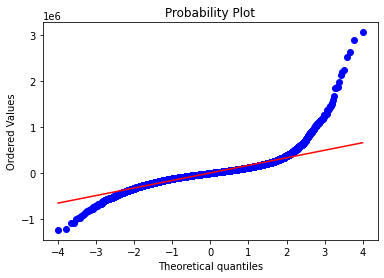

Assumption 3: Homoscedasticity in Residuals
---------------------------------------------


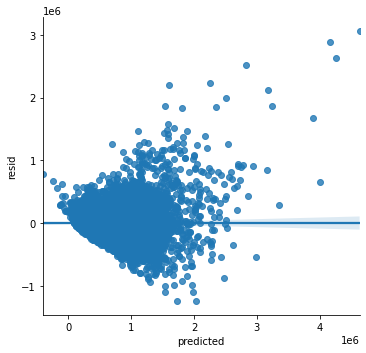

In [205]:
assumptions(model_v8i)

In [206]:
vif_v8i

,variables,VIF
0,sqft_living,19.781736
1,waterfront,1.097785
2,condition,7.701686
3,has_view,1.346156
4,bedbathratio,1.185985
5,is_renovated,1.041002
6,has_basement,1.989102
7,Auburn,1.762913
8,Bellevue,1.243433
9,Black Diamond,1.131786


There is multicollinearity between 'sqftxdistfrsea' and 'sqft_living', leaving it in for now because we are adding more features and maybe it will reduce.

## Model v9 - home quality: multiplying condition/grade

In [207]:
df_v3['home_quality'] = df_v3.condition * df_v3.grade

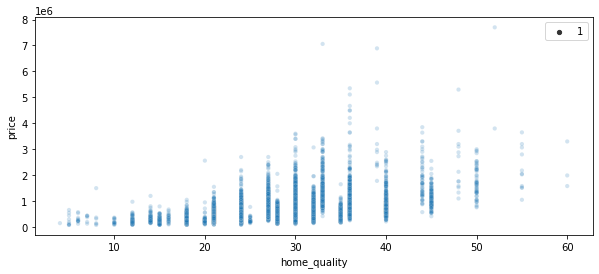

In [208]:
plt.figure(figsize = (10,4))
sns.scatterplot(data=df_v3, x='home_quality', y='price', size=1, alpha=0.2);

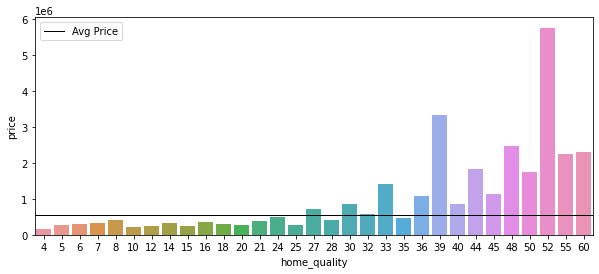

In [209]:
home_quality = df_v3.groupby('home_quality').mean()[['price']]
home_quality.reset_index(inplace=True)
plt.figure(figsize = (10,4))
sns.barplot(data=home_quality, x='home_quality', y='price')
plt.axhline(y=df_v3.price.mean(), color='black', lw=1, label='Avg Price')
plt.legend();

In [210]:
features_to_drop.extend(['condition'])

In [211]:
X = df_v3.drop(features_to_drop, axis=1)
y = df_v3.price

model_v9, predictors_v9, vif_v9 = model_evaluation(X, y)

Predictors where coefficient pvalue is > 0.05:
['Bothell']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     2274.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:35:08   Log-Likelihood:            -2.9145e+05
No. Observations:               21597   AIC:                         5.830e+05
Df Residuals:                   21564   BIC:                         5.832e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.647e+05   6055.000    -27.198      0.000   -1.77e+05   -1.53e+05
sqft_living      379.0726      2.608    145.376      0.000     373.962     384.184
waterfront      7.254e+05   1.52e+04     47.584      0.000    6.95e+05    7.55e+05
has_view        1.007e+05   4454.476     22.605      0.000     9.2e+04    1.09e+05
bedbathratio    1.989e+04   1714.602     11.602      0.000    1.65e+04    2.33e+04
is_renovated    8.675e+04   9102.458      9.530      0.000    6.89e+04    1.05e+05
has_basement   -7.295e+04   2702.164    -26.996      0.000   -7.82e+04   -6.77e+04
Auburn          9.523e+04   7775.917     12.247      0.000       8e+04     1.1e+05
Bellevue         1.46e+05   5259.824     27.751      0.000    1.36e+05    1.56e+05
Black Diamond   2.641e+05   1.87e+04     14.120      0.000    2.27e+05    3.01e+05
Bothell         -720.4635   1.29e+04     -0.056      0.955    -2.6e+04    2.45e+04
Carnation       2.154e+05   1.68e+04     12.814      0.000    1.82e+05    2.48e+05
Duvall          1.538e+05   1.37e+04     11.242      0.000    1.27e+05    1.81e+05
Enumclaw        2.925e+05    1.4e+04     20.829      0.000    2.65e+05     3.2e+05
Fall City       2.524e+05   2.04e+04     12.363      0.000    2.12e+05    2.92e+05
Federal Way     7.173e+04   7970.833      8.999      0.000    5.61e+04    8.74e+04
Issaquah        1.571e+05   7543.926     20.826      0.000    1.42e+05    1.72e+05
Kenmore        -3.281e+04   1.07e+04     -3.058      0.002   -5.38e+04   -1.18e+04
Kent            1.417e+04   6533.062      2.169      0.030    1364.838     2.7e+04
Kirkland        6.995e+04   6015.167     11.630      0.000    5.82e+04    8.17e+04
Maple Valley    1.466e+05   9116.400     16.078      0.000    1.29e+05    1.64e+05
Medina          8.616e+05   2.52e+04     34.122      0.000    8.12e+05    9.11e+05
Mercer Island   1.535e+05   1.09e+04     14.058      0.000    1.32e+05    1.75e+05
North Bend      3.947e+05   1.41e+04     28.092      0.000    3.67e+05    4.22e+05
Redmond         1.271e+05   6501.357     19.557      0.000    1.14e+05     1.4e+05
Renton         -7.316e+04   5155.382    -14.192      0.000   -8.33e+04   -6.31e+04
Sammamish       1.384e+05   7302.770     18.953      0.000    1.24e+05    1.53e+05
Snoqualmie      2.953e+05    1.2e+04     24.544      0.000    2.72e+05    3.19e+05
Vashon         -7.315e+04   1.68e+04     -4.348      0.000   -1.06e+05   -4.02e+04
Woodinville     1.125e+05   8954.783     12.560      0.000    9.49e+04     1.3e+05
sqftxdistfrsea   -13.4473      0.168    -79.864      0.000     -13.777     -13.117
lotxdistfrsea      0.0257      0.001     18.539      0.000       0.023       0.028
home_quality    7436.2497    244.370     30.430      0.000    6957.266    7915.233
==============================================================================
Omnibus:        

Reporting on Assumptions of Linear Regression
--------------------------------------------- 

Assumption 1: Independence of Residuals
---------------------------------------------
Evaluated by Durbin-Watson Score between 1.5 and 2.5
Score: 1.991	Assumption: passed. 

Assumption 2: Normal Distribution of Residuals
---------------------------------------------


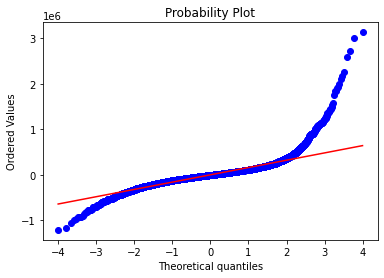

Assumption 3: Homoscedasticity in Residuals
---------------------------------------------


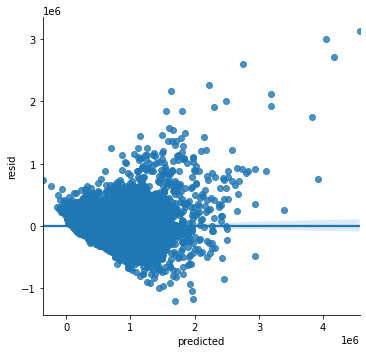

In [212]:
assumptions(model_v9)

In [213]:
vif_v9

,variables,VIF
0,sqft_living,24.028772
1,waterfront,1.097814
2,has_view,1.342616
3,bedbathratio,1.112578
4,is_renovated,1.042366
5,has_basement,1.957938
6,Auburn,1.732066
7,Bellevue,1.252366
8,Black Diamond,1.126499
9,Bothell,1.043430


## Model v10 - very good condition or not

In [214]:
df_v3['condition_5'] = df_v3.condition.map(lambda x: 1 if x == 5 else 0)

In [215]:
X = df_v3.drop(features_to_drop, axis=1)
y = df_v3.price

model_v10, predictors_v10, vif_v10 = model_evaluation(X, y)

Predictors where coefficient pvalue is > 0.05:
['Bothell']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     2226.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:35:12   Log-Likelihood:            -2.9137e+05
No. Observations:               21597   AIC:                         5.828e+05
Df Residuals:                   21563   BIC:                         5.831e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -2.09e+05   6968.479    -29.997      0.000   -2.23e+05   -1.95e+05
sqft_living      373.2540      2.638    141.499      0.000     368.084     378.424
waterfront      7.265e+05   1.52e+04     47.836      0.000    6.97e+05    7.56e+05
has_view         9.81e+04   4442.676     22.080      0.000    8.94e+04    1.07e+05
bedbathratio    1.775e+04   1716.535     10.341      0.000    1.44e+04    2.11e+04
is_renovated     8.79e+04   9069.185      9.692      0.000    7.01e+04    1.06e+05
has_basement   -7.099e+04   2696.530    -26.328      0.000   -7.63e+04   -6.57e+04
Auburn          9.447e+04   7747.339     12.195      0.000    7.93e+04     1.1e+05
Bellevue        1.386e+05   5272.654     26.278      0.000    1.28e+05    1.49e+05
Black Diamond   2.666e+05   1.86e+04     14.307      0.000     2.3e+05    3.03e+05
Bothell        -1466.2459   1.28e+04     -0.114      0.909   -2.66e+04    2.37e+04
Carnation       2.176e+05   1.67e+04     12.991      0.000    1.85e+05     2.5e+05
Duvall          1.567e+05   1.36e+04     11.498      0.000     1.3e+05    1.83e+05
Enumclaw        2.982e+05    1.4e+04     21.307      0.000    2.71e+05    3.26e+05
Fall City       2.533e+05   2.03e+04     12.455      0.000    2.13e+05    2.93e+05
Federal Way     6.692e+04   7950.294      8.418      0.000    5.13e+04    8.25e+04
Issaquah        1.535e+05   7521.215     20.414      0.000    1.39e+05    1.68e+05
Kenmore        -3.392e+04   1.07e+04     -3.172      0.002   -5.49e+04    -1.3e+04
Kent            1.288e+04   6509.648      1.979      0.048     122.118    2.56e+04
Kirkland        6.779e+04   5995.292     11.308      0.000     5.6e+04    7.95e+04
Maple Valley     1.48e+05   9083.287     16.290      0.000     1.3e+05    1.66e+05
Medina           8.51e+05   2.52e+04     33.809      0.000    8.02e+05       9e+05
Mercer Island   1.448e+05   1.09e+04     13.281      0.000    1.23e+05    1.66e+05
North Bend      3.958e+05    1.4e+04     28.276      0.000    3.68e+05    4.23e+05
Redmond         1.235e+05   6483.486     19.054      0.000    1.11e+05    1.36e+05
Renton          -7.26e+04   5136.477    -14.133      0.000   -8.27e+04   -6.25e+04
Sammamish       1.339e+05   7284.315     18.384      0.000     1.2e+05    1.48e+05
Snoqualmie       2.99e+05    1.2e+04     24.937      0.000    2.75e+05    3.22e+05
Vashon         -7.199e+04   1.68e+04     -4.295      0.000   -1.05e+05   -3.91e+04
Woodinville     1.065e+05   8933.802     11.925      0.000     8.9e+04    1.24e+05
sqftxdistfrsea   -13.4768      0.168    -80.329      0.000     -13.806     -13.148
lotxdistfrsea      0.0256      0.001     18.535      0.000       0.023       0.028
home_quality    9885.4325    310.449     31.842      0.000    9276.930    1.05e+04
condition_5    -7.313e+04   5751.596    -12.715      0.000   -8.44e+04   -6.19e+04
============

Reporting on Assumptions of Linear Regression
--------------------------------------------- 

Assumption 1: Independence of Residuals
---------------------------------------------
Evaluated by Durbin-Watson Score between 1.5 and 2.5
Score: 1.993	Assumption: passed. 

Assumption 2: Normal Distribution of Residuals
---------------------------------------------


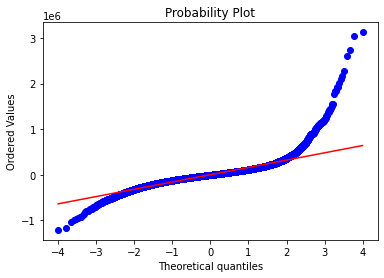

Assumption 3: Homoscedasticity in Residuals
---------------------------------------------


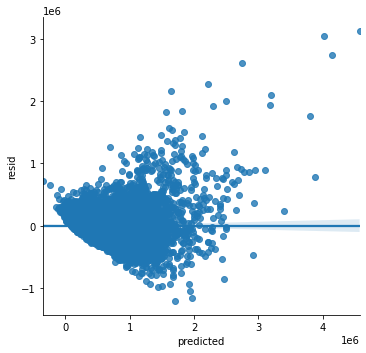

In [216]:
assumptions(model_v10)

In [217]:
vif_v10

,variables,VIF
0,sqft_living,25.295869
1,waterfront,1.098008
2,has_view,1.342766
3,bedbathratio,1.113045
4,is_renovated,1.043295
5,has_basement,1.958596
6,Auburn,1.746874
7,Bellevue,1.256556
8,Black Diamond,1.127323
9,Bothell,1.044988


The home being a condition 5 or not is a better fit for the model than home_quality, so we will drop that.

In [218]:
features_to_drop.extend(['home_quality'])

In [219]:
X = df_v3.drop(features_to_drop, axis=1)
y = df_v3.price

model_v10i, predictors_v10i, vif_v10i = model_evaluation(X, y)

Predictors where coefficient pvalue is > 0.05:
['Bothell']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     2163.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:35:16   Log-Likelihood:            -2.9187e+05
No. Observations:               21597   AIC:                         5.838e+05
Df Residuals:                   21564   BIC:                         5.841e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -2.02e+04   3744.207     -5.394      0.000   -2.75e+04   -1.29e+04
sqft_living      403.3227      2.520    160.034      0.000     398.383     408.263
waterfront      7.262e+05   1.55e+04     46.732      0.000    6.96e+05    7.57e+05
has_view        1.093e+05   4531.567     24.118      0.000       1e+05    1.18e+05
bedbathratio    2.211e+04   1750.783     12.631      0.000    1.87e+04    2.55e+04
is_renovated    6.451e+04   9249.272      6.975      0.000    4.64e+04    8.26e+04
has_basement   -7.235e+04   2758.791    -26.226      0.000   -7.78e+04   -6.69e+04
Auburn          1.061e+05   7918.442     13.396      0.000    9.06e+04    1.22e+05
Bellevue        1.681e+05   5310.637     31.662      0.000    1.58e+05    1.79e+05
Black Diamond   2.771e+05   1.91e+04     14.536      0.000     2.4e+05    3.15e+05
Bothell        -3795.4715   1.31e+04     -0.289      0.773   -2.95e+04     2.2e+04
Carnation       2.104e+05   1.71e+04     12.279      0.000    1.77e+05    2.44e+05
Duvall          1.458e+05   1.39e+04     10.456      0.000    1.18e+05    1.73e+05
Enumclaw         3.16e+05   1.43e+04     22.084      0.000    2.88e+05    3.44e+05
Fall City       2.529e+05   2.08e+04     12.149      0.000    2.12e+05    2.94e+05
Federal Way     8.619e+04   8111.300     10.625      0.000    7.03e+04    1.02e+05
Issaquah        1.687e+05   7680.398     21.965      0.000    1.54e+05    1.84e+05
Kenmore        -3.446e+04   1.09e+04     -3.150      0.002   -5.59e+04    -1.3e+04
Kent            2.565e+04   6648.132      3.858      0.000    1.26e+04    3.87e+04
Kirkland        7.446e+04   6130.746     12.145      0.000    6.24e+04    8.65e+04
Maple Valley    1.489e+05   9294.128     16.021      0.000    1.31e+05    1.67e+05
Medina          8.769e+05   2.57e+04     34.068      0.000    8.26e+05    9.27e+05
Mercer Island   1.852e+05   1.11e+04     16.719      0.000    1.63e+05    2.07e+05
North Bend      4.022e+05   1.43e+04     28.082      0.000    3.74e+05     4.3e+05
Redmond         1.321e+05   6628.274     19.933      0.000    1.19e+05    1.45e+05
Renton         -6.805e+04   5253.706    -12.954      0.000   -7.84e+04   -5.78e+04
Sammamish       1.489e+05   7437.929     20.015      0.000    1.34e+05    1.63e+05
Snoqualmie      2.903e+05   1.23e+04     23.671      0.000    2.66e+05    3.14e+05
Vashon         -6.198e+04   1.71e+04     -3.614      0.000   -9.56e+04   -2.84e+04
Woodinville     1.274e+05   9116.557     13.977      0.000     1.1e+05    1.45e+05
sqftxdistfrsea   -13.9129      0.171    -81.318      0.000     -14.248     -13.578
lotxdistfrsea      0.0267      0.001     18.895      0.000       0.024       0.030
condition_5      4.05e+04   4615.324      8.776      0.000    3.15e+04    4.95e+04
==============================================================================
Omnibus:        

Reporting on Assumptions of Linear Regression
--------------------------------------------- 

Assumption 1: Independence of Residuals
---------------------------------------------
Evaluated by Durbin-Watson Score between 1.5 and 2.5
Score: 1.992	Assumption: passed. 

Assumption 2: Normal Distribution of Residuals
---------------------------------------------


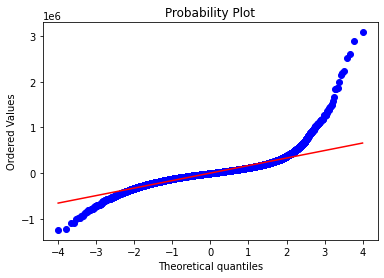

Assumption 3: Homoscedasticity in Residuals
---------------------------------------------


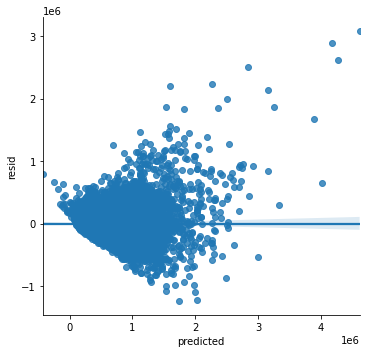

In [220]:
assumptions(model_v10i)

In [221]:
vif_v10i

,variables,VIF
0,sqft_living,11.164114
1,waterfront,1.097612
2,has_view,1.341724
3,bedbathratio,1.055358
4,is_renovated,1.041737
5,has_basement,1.937650
6,Auburn,1.564278
7,Bellevue,1.232148
8,Black Diamond,1.103937
9,Bothell,1.037872


## Model v11 - footprint

Started to explore this, initially it looks like we might be able to classify some of our homes as townhomes, and maybe that will help improve the model.

In [222]:
lot_use_df = df_v3[['price','sqft_living','floors','sqft_lot']].copy()

The footprint of the home would be the sqft_living divided by floors. We can then compare this to sqft_lot and see how much of a yard the home actually has.

In [223]:
lot_use_df['footprint'] = df_v3.sqft_living / df_v3.floors

In [224]:
lot_use_df.footprint.describe()

count    21597.000000
mean      1485.451595
std        654.358713
min        253.333333
25%       1025.000000
50%       1370.000000
75%       1820.000000
max       9640.000000
Name: footprint, dtype: float64

In [225]:
lot_use_df.groupby('floors').mean()

,price,sqft_living,sqft_lot,footprint
floors,,,,
1.0,4.423584e+05,1732.619601,14546.515506,1732.619601
1.5,5.590449e+05,1907.880628,16966.476440,1271.920419
2.0,6.491856e+05,2571.412386,16137.975956,1285.706193
2.5,1.061021e+06,3145.428571,17347.291925,1258.171429
3.0,5.834339e+05,1789.418985,4471.864157,596.472995
3.5,9.102143e+05,2440.000000,2792.285714,697.142857


The average home in the USA right now is [2,531](https://www.statista.com/statistics/529371/floor-area-size-new-single-family-homes-usa/#:~:text=In%202019%2C%20the%20average%20size,home%20measured%201%2C660%20square%20feet.) ft${^2}$. If you use that number as the numerator and divide by different floor quantities you get:

- 1.5 floors = 1,687 ft${^2}$
- 2 floors = 1,265 ft${^2}$

The [typical townhome layout](https://www.simpletwig.com/blog/the-ultimate-townhouse-layout/#:~:text=The%20design%20challenge%20is%20to,lost%20space%20in%20public%20areas.) is a footprint of 20'x45', or 900 ft${^2}$. 

We are wondering if there is a way to classify what kind of home it is based on this information

In [226]:
for x in sorted(list(lot_use_df.floors.unique())):
    
    homes_on_floor = lot_use_df[lot_use_df.floors == x]
    
    fp_under_900 = len(homes_on_floor[homes_on_floor.footprint < 900])
    
#     fp_under_900 = len(lot_use_df[(lot_use_df.floors == x) & (lot_use_df.footprint < 900)])

    percent_under = round((fp_under_900/len(homes_on_floor))*100, 2)

    avg_sqft_for_floor = round(homes_on_floor.sqft_living.mean(), 2)
    
    print(f'There are {len(homes_on_floor)} homes with floor count {x}')
    print(f'The average square footage of a home with these many floors is: {avg_sqft_for_floor}')
    print(f'Of that, there are {fp_under_900} homes with footprints under 900 ft2')
    print(f'{percent_under}% of homes with {x} floor(s) have footprint under 900ft2')
    print('----------------------------------------------------------')

There are 10673 homes with floor count 1.0
The average square footage of a home with these many floors is: 1732.62
Of that, there are 786 homes with footprints under 900 ft2
7.36% of homes with 1.0 floor(s) have footprint under 900ft2
----------------------------------------------------------
There are 1910 homes with floor count 1.5
The average square footage of a home with these many floors is: 1907.88
Of that, there are 407 homes with footprints under 900 ft2
21.31% of homes with 1.5 floor(s) have footprint under 900ft2
----------------------------------------------------------
There are 8235 homes with floor count 2.0
The average square footage of a home with these many floors is: 2571.41
Of that, there are 1706 homes with footprints under 900 ft2
20.72% of homes with 2.0 floor(s) have footprint under 900ft2
----------------------------------------------------------
There are 161 homes with floor count 2.5
The average square footage of a home with these many floors is: 3145.43
Of t

It looks like a majority of the homes with 3 floors and up can be classified as townhomes based on this method.
_____
Lets look at the 2.5 and 2 floor homes. I'm less certain that we can classify them as townhomes.

In [227]:
lot_use_df[(lot_use_df.floors == 2.0) & (lot_use_df.footprint < 900)].describe()

,price,sqft_living,floors,sqft_lot,footprint
count,1.706000e+03,1706.000000,1706.0,1706.000000,1706.000000
mean,3.889201e+05,1468.208675,2.0,5870.906213,734.104338
std,1.376272e+05,236.252166,0.0,19730.706856,118.126083
min,9.000000e+04,550.000000,2.0,572.000000,275.000000
25%,2.860000e+05,1320.000000,2.0,1485.000000,660.000000
50%,3.660000e+05,1510.000000,2.0,3133.500000,755.000000
75%,4.640000e+05,1660.000000,2.0,6000.000000,830.000000
max,1.240000e+06,1794.000000,2.0,577605.000000,897.000000


In [228]:
lot_use_df[lot_use_df.floors == 2.0].describe()

,price,sqft_living,floors,sqft_lot,footprint
count,8.235000e+03,8235.000000,8235.0,8.235000e+03,8235.000000
mean,6.491856e+05,2571.412386,2.0,1.613798e+04,1285.706193
std,4.342366e+05,954.544522,0.0,4.464476e+04,477.272261
min,9.000000e+04,550.000000,2.0,5.720000e+02,275.000000
25%,3.790000e+05,1894.500000,2.0,4.558500e+03,947.250000
50%,5.430000e+05,2440.000000,2.0,7.089000e+03,1220.000000
75%,7.725000e+05,3090.000000,2.0,1.081300e+04,1545.000000
max,7.060000e+06,10040.000000,2.0,1.024068e+06,5020.000000


Given the differences in averages for 2 floor homes with footprints under 900 ft${^2}$, we are going to say we will not classify them as townhomes. They seem to be just smaller single family homes. We will make the same assumption for 2.5 floor homes.

In [229]:
def townhome_check(df):
    if ((df.floors >= 3.0) & (df.footprint < 900)):
        return 1
    else:
        return 0

In [230]:
lot_use_df['is_townhome'] = lot_use_df.apply(townhome_check, axis=1)

In [231]:
lot_use_df.is_townhome.value_counts()

0    21058
1      539
Name: is_townhome, dtype: int64

In [232]:
df_v3['is_townhome'] = lot_use_df.is_townhome

In [233]:
X = df_v3.drop(features_to_drop, axis=1)
y = df_v3.price

model_v11, predictors_v11, vif_v11 = model_evaluation(X, y)

Predictors where coefficient pvalue is > 0.05:
['Bothell', 'is_townhome']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     2097.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:35:22   Log-Likelihood:            -2.9187e+05
No. Observations:               21597   AIC:                         5.838e+05
Df Residuals:                   21563   BIC:                         5.841e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.973e+04   3869.192     -5.100      0.000   -2.73e+04   -1.21e+04
sqft_living      403.2861      2.521    159.942      0.000     398.344     408.228
waterfront      7.262e+05   1.55e+04     46.728      0.000    6.96e+05    7.57e+05
has_view        1.093e+05   4532.314     24.106      0.000       1e+05    1.18e+05
bedbathratio    2.231e+04   1799.368     12.400      0.000    1.88e+04    2.58e+04
is_renovated    6.434e+04   9256.303      6.951      0.000    4.62e+04    8.25e+04
has_basement   -7.252e+04   2781.259    -26.075      0.000    -7.8e+04   -6.71e+04
Auburn          1.058e+05   7935.603     13.336      0.000    9.03e+04    1.21e+05
Bellevue        1.679e+05   5326.822     31.529      0.000    1.58e+05    1.78e+05
Black Diamond   2.769e+05   1.91e+04     14.520      0.000     2.4e+05    3.14e+05
Bothell        -4067.9505   1.32e+04     -0.309      0.757   -2.98e+04    2.17e+04
Carnation       2.101e+05   1.71e+04     12.255      0.000    1.77e+05    2.44e+05
Duvall          1.455e+05    1.4e+04     10.422      0.000    1.18e+05    1.73e+05
Enumclaw        3.158e+05   1.43e+04     22.059      0.000    2.88e+05    3.44e+05
Fall City       2.526e+05   2.08e+04     12.133      0.000    2.12e+05    2.93e+05
Federal Way     8.595e+04   8126.123     10.577      0.000       7e+04    1.02e+05
Issaquah        1.684e+05   7700.134     21.875      0.000    1.53e+05    1.84e+05
Kenmore        -3.472e+04    1.1e+04     -3.170      0.002   -5.62e+04   -1.33e+04
Kent            2.538e+04   6672.110      3.804      0.000    1.23e+04    3.85e+04
Kirkland        7.419e+04   6156.829     12.050      0.000    6.21e+04    8.63e+04
Maple Valley    1.486e+05   9318.527     15.945      0.000     1.3e+05    1.67e+05
Medina          8.767e+05   2.57e+04     34.051      0.000    8.26e+05    9.27e+05
Mercer Island    1.85e+05   1.11e+04     16.690      0.000    1.63e+05    2.07e+05
North Bend       4.02e+05   1.43e+04     28.045      0.000    3.74e+05     4.3e+05
Redmond         1.318e+05   6656.661     19.805      0.000    1.19e+05    1.45e+05
Renton         -6.832e+04   5282.272    -12.933      0.000   -7.87e+04    -5.8e+04
Sammamish       1.486e+05   7459.163     19.922      0.000    1.34e+05    1.63e+05
Snoqualmie        2.9e+05   1.23e+04     23.618      0.000    2.66e+05    3.14e+05
Vashon         -6.224e+04   1.72e+04     -3.627      0.000   -9.59e+04   -2.86e+04
Woodinville     1.272e+05   9133.604     13.922      0.000    1.09e+05    1.45e+05
sqftxdistfrsea   -13.9151      0.171    -81.299      0.000     -14.251     -13.580
lotxdistfrsea      0.0267      0.001     18.896      0.000       0.024       0.030
condition_5     4.041e+04   4619.375      8.748      0.000    3.14e+04    4.95e+04
is_townhome    -3929.0902   8260.841     -0.476      0.634   -2.01e+04    1.23e+04
============

In the end, it seems that was not a good way of trying to add to the model.

In [234]:
features_to_drop.extend(['is_townhome'])

## Model v12 - age of home

We dropped the year the home was built, lets see if instead having it as an age will tell us anything

In [235]:
df_v3.date[0].year

2014

In [236]:
df_v3['sold_year'] = df_v3['date'].map(lambda x: x.year)

In [237]:
df_v3['home_age'] = df_v3.sold_year - df_v3.yr_built

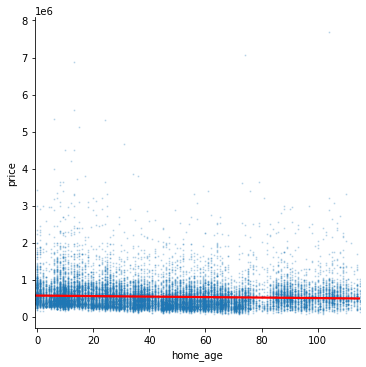

In [238]:
sns.lmplot(data=df_v3, x='home_age', y='price', line_kws={'color':'red'},
           scatter_kws={'s':1,'alpha':0.2});

In [239]:
df_v3.drop(['sold_year', 'home_age'], axis=1, inplace=True)

Not even going to model this, there is almost no relationship between the age of the home and the price

## Model v13 - relative size of home and lot

We have two original features that give the average square footage for both the living area and lot size of the 15 closest homes. We wonder if there is any relationship between them. Hopefully this would illuminate a bit more about the neighborhood the home is in, beyond the city.

In [240]:
df_v3['difference_living'] = df_v3.sqft_living - df_v3.sqft_living15
df_v3['difference_lot'] = df_v3.sqft_lot - df_v3.sqft_lot15

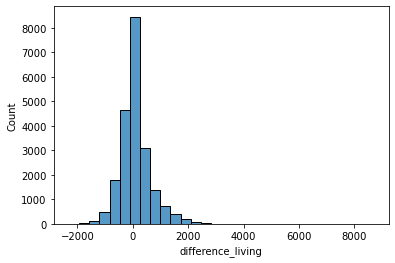

In [241]:
sns.histplot(data=df_v3, x='difference_living', bins=30);

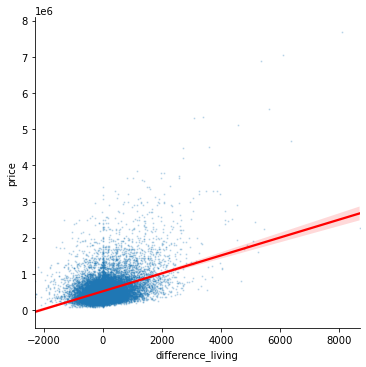

In [242]:
sns.lmplot(data=df_v3, x='difference_living', y='price',           
           scatter_kws={'alpha':0.2, 's':1},
           line_kws={'color':'red'});

In [243]:
df_v3.difference_living.describe()

count    21597.000000
mean        93.701533
std        600.611048
min      -2310.000000
25%       -220.000000
50%          0.000000
75%        310.000000
max       8690.000000
Name: difference_living, dtype: float64

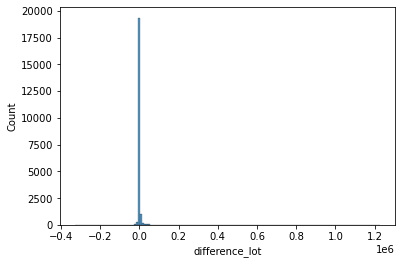

In [244]:
sns.histplot(data=df_v3, x='difference_lot', bins=150);

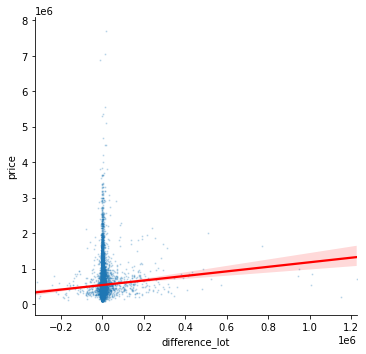

In [245]:
sns.lmplot(data=df_v3, x='difference_lot', y='price',           
           scatter_kws={'alpha':0.2, 's':1},
           line_kws={'color':'red'});

In [246]:
df_v3.difference_lot.describe()

count    2.159700e+04
mean     2.341125e+03
std      2.892178e+04
min     -3.268790e+05
25%     -4.210000e+02
50%      0.000000e+00
75%      6.800000e+02
max      1.225778e+06
Name: difference_lot, dtype: float64

Difference in lot size does not seem to be a good measure, but we could use difference in living 
______
We are going to say any home that is 15% bigger than neighbors average is considered large for the neighborhood, and will make this into a feature called 'above_average_living'

In [247]:
df_v3.drop(['difference_lot'], axis=1, inplace=True)

In [248]:
def above_avg(df):
    if df.difference_living > df.sqft_living*0.15:
        return 1
    else:
        return 0

df_v3['above_average_living'] = df_v3.apply(above_avg, axis=1)

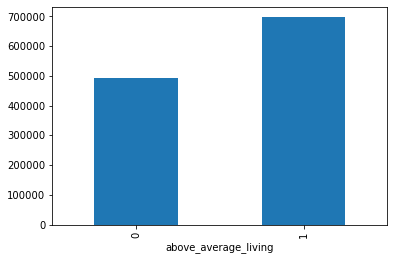

In [249]:
df_v3.groupby('above_average_living').mean()['price'].plot(kind='bar');

In [250]:
df_v3.drop(['difference_living'], axis=1, inplace=True)

In [251]:
X = df_v3.drop(features_to_drop, axis=1)
y = df_v3.price

model_v13, predictors_v13, vif_v13 = model_evaluation(X, y)

Predictors where coefficient pvalue is > 0.05:
['Bothell']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     2197.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:35:30   Log-Likelihood:            -2.9148e+05
No. Observations:               21597   AIC:                         5.830e+05
Df Residuals:                   21563   BIC:                         5.833e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -4.276e+04   3765.531    -11.356      0.000   -5.01e+04   -3.54e+04
sqft_living            430.2207      2.656    161.988      0.000     425.015     435.426
waterfront            7.277e+05   1.53e+04     47.666      0.000    6.98e+05    7.58e+05
has_view              9.439e+04   4483.359     21.053      0.000    8.56e+04    1.03e+05
bedbathratio          1.764e+04   1727.291     10.215      0.000    1.43e+04     2.1e+04
is_renovated          7.523e+04   9094.116      8.272      0.000    5.74e+04    9.31e+04
has_basement         -6.446e+04   2724.761    -23.656      0.000   -6.98e+04   -5.91e+04
Auburn                1.082e+05   7779.083     13.912      0.000     9.3e+04    1.23e+05
Bellevue              1.454e+05   5279.751     27.544      0.000    1.35e+05    1.56e+05
Black Diamond         2.828e+05   1.87e+04     15.098      0.000    2.46e+05     3.2e+05
Bothell              -2.198e+04   1.29e+04     -1.701      0.089   -4.73e+04    3352.149
Carnation             2.127e+05   1.68e+04     12.635      0.000     1.8e+05    2.46e+05
Duvall                1.389e+05   1.37e+04     10.142      0.000    1.12e+05    1.66e+05
Enumclaw              3.234e+05   1.41e+04     23.001      0.000    2.96e+05    3.51e+05
Fall City             2.494e+05   2.04e+04     12.198      0.000    2.09e+05    2.89e+05
Federal Way           8.205e+04   7969.530     10.295      0.000    6.64e+04    9.77e+04
Issaquah              1.522e+05   7567.989     20.106      0.000    1.37e+05    1.67e+05
Kenmore              -4.465e+04   1.08e+04     -4.153      0.000   -6.57e+04   -2.36e+04
Kent                  2.031e+04   6533.607      3.108      0.002    7499.042    3.31e+04
Kirkland              6.604e+04   6030.066     10.952      0.000    5.42e+04    7.79e+04
Maple Valley          1.414e+05   9134.048     15.481      0.000    1.23e+05    1.59e+05
Medina                8.455e+05   2.53e+04     33.402      0.000    7.96e+05    8.95e+05
Mercer Island         1.561e+05   1.09e+04     14.283      0.000    1.35e+05    1.78e+05
North Bend            4.095e+05   1.41e+04     29.100      0.000    3.82e+05    4.37e+05
Redmond               1.134e+05   6545.619     17.324      0.000    1.01e+05    1.26e+05
Renton               -7.944e+04   5177.014    -15.345      0.000   -8.96e+04   -6.93e+04
Sammamish              1.21e+05   7374.361     16.405      0.000    1.07e+05    1.35e+05
Snoqualmie            2.759e+05   1.21e+04     22.876      0.000    2.52e+05       3e+05
Vashon               -4.503e+04   1.69e+04     -2.671      0.008   -7.81e+04    -1.2e+04
Woodinville           1.057e+05   8989.236     11.759      0.000    8.81e+04    1.23e+05
sqftxdistfrsea         -14.2199      0.168    -84.426      0.000     -14.550     -13.890
lotxdistfrsea            0.0285      0.001     20.455    

Reporting on Assumptions of Linear Regression
--------------------------------------------- 

Assumption 1: Independence of Residuals
---------------------------------------------
Evaluated by Durbin-Watson Score between 1.5 and 2.5
Score: 1.994	Assumption: passed. 

Assumption 2: Normal Distribution of Residuals
---------------------------------------------


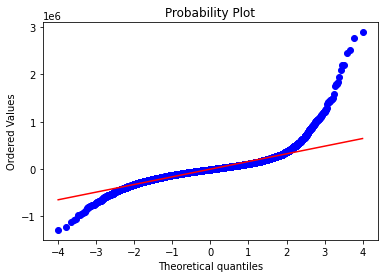

Assumption 3: Homoscedasticity in Residuals
---------------------------------------------


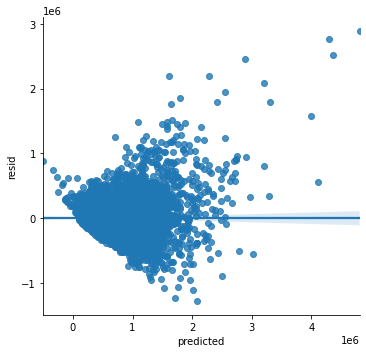

In [252]:
assumptions(model_v13)

In [253]:
vif_v13

,variables,VIF
0,sqft_living,12.319317
1,waterfront,1.097683
2,has_view,1.355071
3,bedbathratio,1.056043
4,is_renovated,1.043417
5,has_basement,1.948353
6,Auburn,1.571745
7,Bellevue,1.265292
8,Black Diamond,1.104551
9,Bothell,1.043109


There is still multicollinearity with 'sqftxdistfrsea', so we will add that to features to be removed.

In [254]:
features_to_drop.extend(['sqftxdistfrsea'])

In [255]:
X = df_v3.drop(features_to_drop, axis=1)
y = df_v3.price

model_v13i, predictors_v13i, vif_v13i = model_evaluation(X, y)

Predictors where coefficient pvalue is > 0.05:
['Kirkland']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     1535.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:35:35   Log-Likelihood:            -2.9457e+05
No. Observations:               21597   AIC:                         5.892e+05
Df Residuals:                   21564   BIC:                         5.895e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  7.28e+04   4046.304     17.991      0.000    6.49e+04    8.07e+04
sqft_living            264.3637      2.062    128.234      0.000     260.323     268.405
waterfront            7.148e+05   1.76e+04     40.596      0.000     6.8e+05    7.49e+05
has_view              1.172e+05   5162.053     22.696      0.000    1.07e+05    1.27e+05
bedbathratio          2.461e+04   1990.107     12.364      0.000    2.07e+04    2.85e+04
is_renovated          1.326e+05   1.05e+04     12.677      0.000    1.12e+05    1.53e+05
has_basement         -3.559e+04   3118.077    -11.413      0.000   -4.17e+04   -2.95e+04
Auburn               -2.839e+05   7198.039    -39.442      0.000   -2.98e+05    -2.7e+05
Bellevue              1.243e+05   6083.222     20.441      0.000    1.12e+05    1.36e+05
Black Diamond        -2.015e+05   2.06e+04     -9.794      0.000   -2.42e+05   -1.61e+05
Bothell              -1.611e+05   1.48e+04    -10.895      0.000    -1.9e+05   -1.32e+05
Carnation            -1.749e+05   1.87e+04     -9.361      0.000   -2.11e+05   -1.38e+05
Duvall               -2.149e+05    1.5e+04    -14.286      0.000   -2.44e+05   -1.85e+05
Enumclaw             -2.765e+05    1.4e+04    -19.756      0.000   -3.04e+05   -2.49e+05
Fall City            -1.115e+05   2.31e+04     -4.836      0.000   -1.57e+05   -6.63e+04
Federal Way          -2.904e+05   7655.593    -37.935      0.000   -3.05e+05   -2.75e+05
Issaquah             -9.409e+04   8055.037    -11.681      0.000    -1.1e+05   -7.83e+04
Kenmore               -1.58e+05   1.23e+04    -12.835      0.000   -1.82e+05   -1.34e+05
Kent                 -2.737e+05   6376.770    -42.918      0.000   -2.86e+05   -2.61e+05
Kirkland              9635.9987   6912.673      1.394      0.163   -3913.353    2.32e+04
Maple Valley         -2.719e+05   8895.008    -30.566      0.000   -2.89e+05   -2.54e+05
Medina                1.066e+06    2.9e+04     36.698      0.000    1.01e+06    1.12e+06
Mercer Island         2.535e+05   1.25e+04     20.220      0.000    2.29e+05    2.78e+05
North Bend           -1.795e+05   1.41e+04    -12.737      0.000   -2.07e+05   -1.52e+05
Redmond                  -6e+04   7168.885     -8.369      0.000    -7.4e+04   -4.59e+04
Renton                -2.15e+05   5676.856    -37.881      0.000   -2.26e+05   -2.04e+05
Sammamish            -9.839e+04   7960.613    -12.359      0.000   -1.14e+05   -8.28e+04
Snoqualmie           -2.352e+05    1.2e+04    -19.549      0.000   -2.59e+05   -2.12e+05
Vashon               -2.348e+05   1.93e+04    -12.187      0.000   -2.73e+05   -1.97e+05
Woodinville          -1.238e+05   9883.166    -12.530      0.000   -1.43e+05   -1.04e+05
lotxdistfrsea            0.0048      0.002      3.047      0.002       0.002       0.008
condition_5           7.802e+04   5222.718     14.939    

In [256]:
vif_v13i

,variables,VIF
0,sqft_living,5.606301
1,waterfront,1.097295
2,has_view,1.354299
3,bedbathratio,1.049531
4,is_renovated,1.035782
5,has_basement,1.874126
6,Auburn,1.113192
7,Bellevue,1.262950
8,Black Diamond,1.023464
9,Bothell,1.031985


# Train Test Split

We have attempted to use every feature from our original dataset in ways to improve the model when initially the features did not seem to work. Here is where we feel comfortable with the model and want to actually test it through a train test split.

In [257]:
df_v4 = df_v3.copy()

In [258]:
# removing the target from the drop list
features_to_drop.remove('price')

# dropping all the unnecessary features from our dataframe
df_v4.drop(features_to_drop, axis=1, inplace=True)

We can now use df_v4 as the dataframe to train/test split from. The constant is there for modeling purposes, and we have price in the dataframe to split off.

In [259]:
X = df_v4.drop('price', axis=1)
y = df_v3.price

In [260]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=0)

In [261]:
tts_model, tts_predictors, tts_vif = model_evaluation(X_train, y_train)

Predictors where coefficient pvalue is > 0.05:
['Kirkland', 'lotxdistfrsea']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     1215.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:35:38   Log-Likelihood:            -2.3598e+05
No. Observations:               17277   AIC:                         4.720e+05
Df Residuals:                   17244   BIC:                         4.723e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 6.298e+04   4620.679     13.630      0.000    5.39e+04     7.2e+04
sqft_living            270.4883      2.342    115.473      0.000     265.897     275.080
waterfront            6.827e+05   1.99e+04     34.391      0.000    6.44e+05    7.22e+05
has_view              1.162e+05   5902.627     19.679      0.000    1.05e+05    1.28e+05
bedbathratio          2.285e+04   2272.295     10.055      0.000    1.84e+04    2.73e+04
is_renovated          1.327e+05   1.18e+04     11.250      0.000     1.1e+05    1.56e+05
has_basement         -3.568e+04   3561.121    -10.018      0.000   -4.27e+04   -2.87e+04
Auburn               -2.852e+05   8191.150    -34.817      0.000   -3.01e+05   -2.69e+05
Bellevue                1.2e+05   6965.788     17.232      0.000    1.06e+05    1.34e+05
Black Diamond        -1.984e+05   2.28e+04     -8.712      0.000   -2.43e+05   -1.54e+05
Bothell              -1.679e+05    1.7e+04     -9.863      0.000   -2.01e+05   -1.35e+05
Carnation             -1.81e+05   2.16e+04     -8.371      0.000   -2.23e+05   -1.39e+05
Duvall               -2.116e+05   1.71e+04    -12.361      0.000   -2.45e+05   -1.78e+05
Enumclaw               -2.8e+05   1.61e+04    -17.377      0.000   -3.12e+05   -2.48e+05
Fall City            -1.065e+05   2.59e+04     -4.106      0.000   -1.57e+05   -5.57e+04
Federal Way          -2.923e+05   8846.916    -33.039      0.000    -3.1e+05   -2.75e+05
Issaquah              -9.35e+04   9085.270    -10.292      0.000   -1.11e+05   -7.57e+04
Kenmore              -1.565e+05   1.38e+04    -11.303      0.000   -1.84e+05   -1.29e+05
Kent                 -2.721e+05   7247.124    -37.548      0.000   -2.86e+05   -2.58e+05
Kirkland              1.353e+04   7976.087      1.697      0.090   -2099.006    2.92e+04
Maple Valley         -2.741e+05   1.01e+04    -27.033      0.000   -2.94e+05   -2.54e+05
Medina                1.076e+06   3.31e+04     32.504      0.000    1.01e+06    1.14e+06
Mercer Island         2.536e+05   1.42e+04     17.831      0.000    2.26e+05    2.82e+05
North Bend           -1.765e+05   1.62e+04    -10.901      0.000   -2.08e+05   -1.45e+05
Redmond              -6.013e+04   8160.894     -7.368      0.000   -7.61e+04   -4.41e+04
Renton               -2.165e+05   6461.784    -33.499      0.000   -2.29e+05   -2.04e+05
Sammamish            -9.831e+04   9093.189    -10.811      0.000   -1.16e+05   -8.05e+04
Snoqualmie           -2.419e+05    1.4e+04    -17.312      0.000   -2.69e+05   -2.15e+05
Vashon               -2.243e+05   2.13e+04    -10.513      0.000   -2.66e+05   -1.82e+05
Woodinville          -1.252e+05   1.14e+04    -10.939      0.000   -1.48e+05   -1.03e+05
lotxdistfrsea            0.0016      0.002      0.877      0.381      -0.002       0.005
condition_5           7.676e+04   5905.899     12.997    

In [262]:
tts_predictors.sort_values('coeff', ascending=False)

,coeff,pvalue
Medina,1.076177e+06,5.443630e-225
waterfront,6.827146e+05,9.502228e-251
Mercer Island,2.536243e+05,1.742134e-70
is_renovated,1.326800e+05,2.927693e-29
Bellevue,1.200376e+05,5.411525e-66
has_view,1.161579e+05,2.810614e-85
condition_5,7.675935e+04,1.926883e-38
const,6.297892e+04,4.400073e-42
bedbathratio,2.284893e+04,1.010552e-23
Kirkland,1.353493e+04,8.972620e-02


In [263]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual = y_test
predicted = tts_model.predict(X_test)

mse = mean_squared_error(actual, predicted)
rmse = math.sqrt(mse)

mae = mean_absolute_error(actual, predicted)

print(f'RMSE: \t{rmse}')
print(f'MAE: \t{mae}')

RMSE: 	186673.19887551072
MAE: 	127117.80054359858


Prior to train/test splitting, the feature 'lotxdistfrsea' coefficients p-value was below the threshold. After splitting, it was over the threshold (significantly). We will remove this feature and remodel.

In [264]:
X_train.drop('lotxdistfrsea', axis=1, inplace=True)
X_test.drop('lotxdistfrsea', axis=1, inplace=True)

In [265]:
tts_model2, tts_predictors2, tts_vif2 = model_evaluation(X_train, y_train)

Predictors where coefficient pvalue is > 0.05:
['Kirkland']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     1254.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:35:39   Log-Likelihood:            -2.3598e+05
No. Observations:               17277   AIC:                         4.720e+05
Df Residuals:                   17245   BIC:                         4.723e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  6.27e+04   4609.935     13.602      0.000    5.37e+04    7.17e+04
sqft_living            270.6710      2.333    116.012      0.000     266.098     275.244
waterfront            6.823e+05   1.98e+04     34.380      0.000    6.43e+05    7.21e+05
has_view              1.164e+05   5895.817     19.744      0.000    1.05e+05    1.28e+05
bedbathratio          2.285e+04   2272.276     10.054      0.000    1.84e+04    2.73e+04
is_renovated          1.326e+05   1.18e+04     11.241      0.000    1.09e+05    1.56e+05
has_basement         -3.574e+04   3560.292    -10.039      0.000   -4.27e+04   -2.88e+04
Auburn               -2.845e+05   8158.069    -34.879      0.000   -3.01e+05   -2.69e+05
Bellevue                1.2e+05   6965.507     17.226      0.000    1.06e+05    1.34e+05
Black Diamond        -1.963e+05   2.26e+04     -8.668      0.000   -2.41e+05   -1.52e+05
Bothell              -1.678e+05    1.7e+04     -9.859      0.000   -2.01e+05   -1.34e+05
Carnation            -1.775e+05   2.12e+04     -8.354      0.000   -2.19e+05   -1.36e+05
Duvall               -2.102e+05    1.7e+04    -12.333      0.000   -2.44e+05   -1.77e+05
Enumclaw             -2.764e+05   1.56e+04    -17.719      0.000   -3.07e+05   -2.46e+05
Fall City            -1.033e+05   2.57e+04     -4.023      0.000   -1.54e+05    -5.3e+04
Federal Way           -2.92e+05   8841.778    -33.028      0.000   -3.09e+05   -2.75e+05
Issaquah             -9.307e+04   9071.807    -10.259      0.000   -1.11e+05   -7.53e+04
Kenmore              -1.564e+05   1.38e+04    -11.297      0.000   -1.84e+05   -1.29e+05
Kent                 -2.718e+05   7235.559    -37.558      0.000   -2.86e+05   -2.58e+05
Kirkland              1.354e+04   7976.030      1.698      0.090   -2092.940    2.92e+04
Maple Valley         -2.734e+05   1.01e+04    -27.055      0.000   -2.93e+05   -2.54e+05
Medina                1.076e+06   3.31e+04     32.496      0.000    1.01e+06    1.14e+06
Mercer Island         2.534e+05   1.42e+04     17.818      0.000    2.26e+05    2.81e+05
North Bend            -1.74e+05   1.59e+04    -10.919      0.000   -2.05e+05   -1.43e+05
Redmond              -5.978e+04   8151.277     -7.334      0.000   -7.58e+04   -4.38e+04
Renton               -2.163e+05   6459.136    -33.488      0.000   -2.29e+05   -2.04e+05
Sammamish            -9.818e+04   9091.869    -10.798      0.000   -1.16e+05   -8.04e+04
Snoqualmie           -2.416e+05    1.4e+04    -17.295      0.000   -2.69e+05   -2.14e+05
Vashon                -2.22e+05   2.12e+04    -10.485      0.000   -2.63e+05    -1.8e+05
Woodinville          -1.244e+05   1.14e+04    -10.904      0.000   -1.47e+05   -1.02e+05
condition_5           7.675e+04   5905.838     12.995      0.000    6.52e+04    8.83e+04
above_average_living -7.828e+04   4355.945    -17.971    

In [266]:
actual = y_test
predicted = tts_model2.predict(X_test)

mse = mean_squared_error(actual, predicted)
rmse = math.sqrt(mse)

mae = mean_absolute_error(actual, predicted)

print(f'RMSE: \t{rmse}')
print(f'MAE: \t{mae}')

RMSE: 	186788.4580146925
MAE: 	127175.33809361496


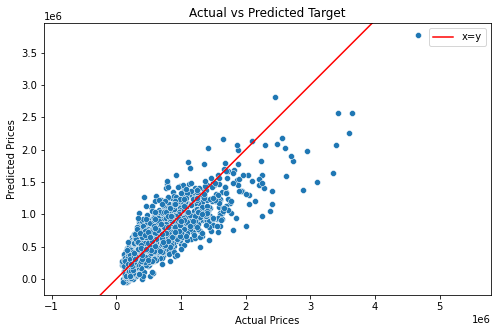

In [267]:
plt.figure(figsize = (8,5))
sns.scatterplot(x=actual, y=predicted)
plt.axline([0,0],[1,1], c='red', label='x=y')
plt.axis('equal')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Target')
plt.legend();

## Transform the predictors to compare

In [268]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train.values)
X_test_ss = ss.transform(X_test.values)

In [269]:
# create the dataframe for the scaled training predictors
X_train_scaled = pd.DataFrame(X_train_ss, index=X_train.index,
                                columns=X_train.columns)
# scaling changed the constant to 0, put it back to 1.0
X_train_scaled.const = 1.0

# create the dataframe for the scaled testing predictors
X_test_scaled = pd.DataFrame(X_test_ss, index=X_test.index,
                                columns=X_test.columns)
# scaling changed the constant to 0, put it back to 1.0
X_test_scaled.const = 1.0

In [270]:
scaled_model, scaled_predictors, scaled_vif = model_evaluation(X_train_scaled,
                                                               y_train)

Predictors where coefficient pvalue is > 0.05:
['Kirkland']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     1254.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:35:41   Log-Likelihood:            -2.3598e+05
No. Observations:               17277   AIC:                         4.720e+05
Df Residuals:                   17245   BIC:                         4.723e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  5.42e+05   1575.218    344.077      0.000    5.39e+05    5.45e+05
sqft_living           2.498e+05   2153.452    116.012      0.000    2.46e+05    2.54e+05
waterfront            5.667e+04   1648.300     34.380      0.000    5.34e+04    5.99e+04
has_view              3.461e+04   1752.845     19.744      0.000    3.12e+04     3.8e+04
bedbathratio          1.717e+04   1707.369     10.054      0.000    1.38e+04    2.05e+04
is_renovated          1.787e+04   1590.010     11.241      0.000    1.48e+04     2.1e+04
has_basement          -1.74e+04   1733.407    -10.039      0.000   -2.08e+04    -1.4e+04
Auburn               -5.735e+04   1644.339    -34.879      0.000   -6.06e+04   -5.41e+04
Bellevue              2.949e+04   1712.185     17.226      0.000    2.61e+04    3.29e+04
Black Diamond        -1.373e+04   1584.432     -8.668      0.000   -1.68e+04   -1.06e+04
Bothell              -1.572e+04   1594.908     -9.859      0.000   -1.89e+04   -1.26e+04
Carnation            -1.326e+04   1587.436     -8.354      0.000   -1.64e+04   -1.01e+04
Duvall                -1.97e+04   1597.009    -12.333      0.000   -2.28e+04   -1.66e+04
Enumclaw              -2.83e+04   1597.077    -17.719      0.000   -3.14e+04   -2.52e+04
Fall City            -6372.4036   1584.165     -4.023      0.000   -9477.528   -3267.280
Federal Way          -5.373e+04   1626.629    -33.028      0.000   -5.69e+04   -5.05e+04
Issaquah             -1.705e+04   1662.297    -10.259      0.000   -2.03e+04   -1.38e+04
Kenmore              -1.804e+04   1596.598    -11.297      0.000   -2.12e+04   -1.49e+04
Kent                 -6.253e+04   1664.815    -37.558      0.000   -6.58e+04   -5.93e+04
Kirkland              2778.5845   1636.678      1.698      0.090    -429.470    5986.639
Maple Valley         -4.457e+04   1647.212    -27.055      0.000   -4.78e+04   -4.13e+04
Medina                5.171e+04   1591.131     32.496      0.000    4.86e+04    5.48e+04
Mercer Island         2.892e+04   1622.903     17.818      0.000    2.57e+04    3.21e+04
North Bend           -1.742e+04   1595.596    -10.919      0.000   -2.05e+04   -1.43e+04
Redmond              -1.245e+04   1697.574     -7.334      0.000   -1.58e+04   -9123.079
Renton               -5.677e+04   1695.370    -33.488      0.000   -6.01e+04   -5.35e+04
Sammamish            -1.847e+04   1710.702    -10.798      0.000   -2.18e+04   -1.51e+04
Snoqualmie            -2.81e+04   1624.917    -17.295      0.000   -3.13e+04   -2.49e+04
Vashon               -1.684e+04   1605.875    -10.485      0.000      -2e+04   -1.37e+04
Woodinville          -1.786e+04   1638.182    -10.904      0.000   -2.11e+04   -1.47e+04
condition_5           2.083e+04   1602.658     12.995      0.000    1.77e+04     2.4e+04
above_average_living -3.339e+04   1858.277    -17.971    

In [271]:
scaled_predictors['abs_coeff'] = scaled_predictors.coeff.abs()

In [272]:
ordered_scaled_predictors = scaled_predictors.sort_values('abs_coeff',
                                                          ascending=False)

In [273]:
ordered_scaled_predictors.reset_index(inplace=True)

In [274]:
ordered_scaled_predictors.drop(0, axis=0, inplace=True)

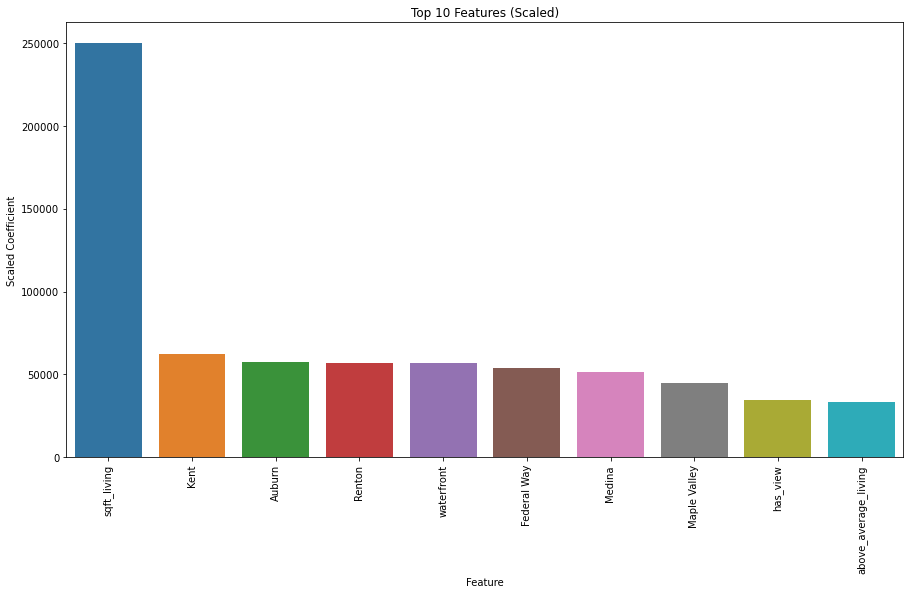

In [275]:
plt.figure(figsize = (15,8))
ax = sns.barplot(data=ordered_scaled_predictors[:10],
                 x='index', y='abs_coeff')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('Feature')
ax.set_ylabel('Scaled Coefficient')
ax.set_title('Top 10 Features (Scaled)');

In [276]:
top_10_pred = list(ordered_scaled_predictors[:10]['index'].values)
tts_predictors2[tts_predictors2.index.isin(top_10_pred)].sort_values('coeff',
            ascending=False)

,coeff,pvalue
Medina,1.075844e+06,6.887239e-225
waterfront,6.823403e+05,1.338408e-250
has_view,1.164056e+05,8.040220e-86
sqft_living,2.706710e+02,0.000000e+00
above_average_living,-7.827972e+04,1.483033e-71
Renton,-2.163052e+05,2.874293e-238
Kent,-2.717566e+05,8.166949e-297
Maple Valley,-2.733856e+05,6.496470e-158
Auburn,-2.845439e+05,1.283622e-257
Federal Way,-2.920303e+05,5.072715e-232


Our constant is $62,703.

The predictor with the largest absolute valued coefficient is 'sqft_living', by a factor of almost 4. Before scaling, the model showed that each increase in square footage resulted in an increase in price of about \\$270.

The next 3 highest predictors are the cities of Kent, Auburn and Renton. Checking our mapping, we see these three cities are clustered in the South region's northwest corner, just south of Seattle. Their un-scaled predictor coefficients were **negative** \\$272k, \\$285k and \\$216k respectively. It seems that area just south of Seattle has something that affects home values negatively.

The waterfront predictor follows that grouping, and has an unscaled positive effect on price of \\$682k.

Federal Way is located right in the grouping of 3 cities mentioned above, whose unscaled predictor coefficient was similar in value at -\\$292k.

Medina is the first city feature to impact the price positively, we have seen how small and expensive that city is so that makes sense. Its unscaled coefficient is just over \\$1 million.

Maple Valley is also in the South region, further southeast than the grouping of other cities. Its unscaled coefficient is -\\$273k. This also make sense from earlier analysis of zipcode data, when we looked at the average price for homes grouped by region, the South region was the lowest.

Finally two of our engineered features:
- 'has_view' impacts positively by about \\$116k
- 'above_average_living' impacts negatively by about \\$78,279
________
The short takeaway is:
>- 'sqft_living' is the most impactful feature on price of home, with each increase in square foot resulting in an increase in value of \\$270
>- of almost equal impact are having homes in the region just southeast of Seattle and having homes on the waterfront, with the location features impacting negatively and the waterfront feature impacting positively
>- Medina and Maple Valley locations have about the same impact of price but in opposite directions, Medina positively and Maple Valley negatively
>- 'has_view' and 'above_average_living' are at the bottom of our top 10 features of importance, also impacting price in opposite directions; the former positively and the latter negatively.
_______________________
Our model explains about 69% of the price variation in homes with an average error of \\$127,175.

Our average home price is about \\$540k, so an error of this magnitude would represent a 23% swing in either over or undervaluing. 

Because our stakeholder wants to use the model to determine if the price of a current home for sale is accurate or not to influence purchase decision, we advice further work to improve the model.

That being said, we can say that the cheaper homes tend to be just south of the city. Federal Way is the only one of our negative impact cities that has waterfront property in it.

So for concrete advice, look for a large home in Federal Way on the water with a view. If the sale price is less than the predicted price minus the average error, we would advise considering the property as it may be a good buy.